<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Airbus/Airbus_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIRFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 15:12:32,050 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 15:12:32,051 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AIRFREUR
2019-08-27 15:15:50,768 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 15:17:45,963 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-27 15:23:05,733 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 15:26:41,482 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 15:30:06,711 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 15:33:35,911 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 15:37:02,921 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 15:55:02,478 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AIRFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AIRFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AIRFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.83058  0.83288  0.82578  0.83068  20.071400
2018-01-02 09:00:00  0.83068  0.83077  0.82198  0.82277  20.329359
2018-01-02 10:00:00  0.82298  0.82767  0.82228  0.82517  17.612610
2018-01-02 11:00:00  0.82518  0.82608  0.82338  0.82368  12.789800
2018-01-02 12:00:00  0.82368  0.82828  0.82257  0.82747  12.433010
...                      ...      ...      ...      ...        ...
2018-12-31 08:00:00  0.83715  0.84217  0.83637  0.83647  10.723599
2018-12-31 09:00:00  0.83647  0.83928  0.83248  0.83877   9.321700
2018-12-31 10:00:00  0.83867  0.83968  0.83457  0.83688  10.258800
2018-12-31 11:00:00  0.83688  0.83798  0.83388  0.83728  10.813700
2018-12-31 12:00:00  0.83728  0.83948  0.83607  0.83908  10.268478

[2274 rows x 5 columns]

Open         High          Low        Close       Volume
count  2274.000000  2274.000000  2274.000000  2274.000000  2274.000000
mean      0.976365     0.979578     0.973153     0.976385     7.388286
std       0.068266     0.068044     0.068439     0.068232     5.992543
min       0.812670     0.815480     0.788070     0.812670     0.000600
25%       0.935872     0.938672     0.931445     0.935880     3.321757
50%       0.973380     0.976625     0.969980     0.973475     5.532890
75%       1.037930     1.042330     1.033022     1.037778     9.778217
max       1.106770     1.111180     1.104370     1.106780    48.234077

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-09 13:00:00  0.86798  0.86858  0.86667  0.86717  12.444700    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.868339  0.861843  0.863267  0.869408  0.867363  0.864535     0.86782    0.867520  0.861374  0.867985  0.868639  0.868723  0.868465  0.867985  0.868343  0.862505                0.872805                 0.867985                0.863165                0.875215                 0.867985                0.860755                0.877625                 0.867985                0.858345                0.880035                 0.867985                0.855935  0.867363  0.867970  0.863381                0.872184                 0.867363                0.862543                0.874594                 0.867363                0.860133                0.877004                 0.867363                0.857723                0.879414                 0.867363   
2018-01-09 14:00:00  0.86717  0.87128  0.86657  0.86981  18.854691    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.868412  0.862007  0.864556  0.869920  0.867907  0.864819     0.86782    0.867720  0.862261  0.868640  0.869298  0.869051  0.868871  0.868640  0.868490  0.863258                0.872805                 0.868640                0.864474                0.874888                 0.868640                0.862392                0.876971                 0.868640                0.860309                0.879054                 0.868640                0.858226  0.867907  0.869090  0.864114                0.872073                 0.867907                0.863742                0.874155                 0.867907                0.861659                0.876238                 0.867907                0.859576                0.878321                 0.867907   
2018-01-09 15:00:00  0.86981  0.86988  0.86737  0.86

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000    2224.000000  2224.000000   2224.000000     2224.000000     2224.000000       2224.000000  2224.000000  2224.000000  2224.000000  2224.000000   2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000  2224.000000  2224.000000  2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000   
mean      0.979243     0.982461     0.976004     0.979251     7.241760    15.998201     2.017536   185.370054      30.424011    11.376349      0.034173        0.023831        0.002248          0.004047     6.595324     2.533273    26.933453     2.017536      2.004496    26.933453     0.979307     0.979357     0.024001     0.979252     0.979298     0.979188     0.979192     0.978941     0.978532     0.979299     0.979252     0.979300     0.979283     0.979299     0.979261     0.979391                0.989402                 0.979299                0.969197                0.994453                 0.979299                0.964146                0.999505                 0.979299                0.959094                1.004556                 0.979299                0.954043     0.979298     0.979260     0.979377                0.989401                 0.979298                0.969196                0.994452                 0.979298                0.964144                0.999503   
std       0.066211     0.065966     0.066445     0.066198     5.945368     8.589347     1.412354   101.949002       0.854497     2.620037      0.181713        0.152557        0.047373          0.063500     3.354708     1.103615    14.564732     1.412354      1.404631    14.564732     0.065906     0.065220     0.980521     0.066300     0.065677     0.065861     0.065846     0.065991     0.066773     0.065812     0.066269     0.065876     0.065889     0.065812     0.066096     0.065130                0.065023                 0.065812                0.067383                0.064933                 0.065812                0.068447                0.065046                 0.065812                0.069686                0.065363                 0.065812                0.071089     0.065677     0.066059     0.065230                0.064914                 0.065677                0.067227                0.064837                 0.065677                0.068280                0.064964   
min       0.812670     0.815480     0.7880

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.188065  0.179574  0.248498  0.185305  0.257997    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.180829  0.136219  0.893202  0.185923  0.173804  0.152950    0.173526    0.188786  0.226869  0.172586  0.183381  0.176711  0.176855  0.172586  0.181483  0.146206                0.161201                 0.172586                0.257816                0.150781                 0.172586                0.341773                0.141073                 0.172586                0.408460                0.132434                 0.172586                0.462709  0.173804  0.182096  0.151046                0.154170                 0.173804                0.224935                0.141955                 0.173804                0.313521                0.132364                 0.173804                0.386128                0.124268                 0.173804   
2018-01-09 14:00:00  0.185311  0.188705  0.248182  0.194281  0.390892    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.181085  0.136827  0.893785  0.187676  0.175719  0.153957    0.173526    0.189475  0.229616  0.174884  0.185628  0.177857  0.178271  0.174884  0.181988  0.148948                0.161203                 0.174884                0.261924                0.149759                 0.174884                0.346319                0.139147                 0.174884                0.413354                0.129703                 0.174884                0.467885  0.175719  0.185955  0.153698                0.153805                 0.175719                0.228881                0.140597                 0.175719                0.317963                0.130129                 0.175719                0.390943                0.121252                 0.175719   
2018-01-09 15:00:00  0.194288  0.183970  

139792

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptd2muwj6
  JVM stdout: /tmp/tmptd2muwj6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptd2muwj6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_2yd6bd
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.539452  0.874709              0.495652  0.566480  0.320900
1  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.534783  0.726785              0.445733  0.514500  0.264711
2  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.527939  6.777643              0.486957  0.691004  0.477487
3  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.503301  2.291690              0.482609  0.670899  0.450105
4  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.500000  0.693082              0.500000  0.499967  0.249967
5  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.500000  0.692883              0.500000  0.499868  0.249868
6  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.499195  0.694330              0.500000  0.500591  0.250591
7              DeepLearning_1_AutoML_20190827_160506  0.477214  0.694894              0.500000  0.500878  0.250879
8  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.466506  0.865065              0.482890  0.569511  0.324343
9  DeepLearning_grid_1_AutoML_20190827_160506_mod...  0.466264  0.695822              0.500000  0.501334  0.251336

variable  relative_importance  scaled_importance  percentage
0                         hour             1.000000           1.000000    0.001480
1              CDLHOMINGPIGEON             0.989610           0.989610    0.001464
2            CDLSTALLEDPATTERN             0.972001           0.972001    0.001438
3                      weekday             0.912717           0.912717    0.001350
4                          OBV             0.908461           0.908461    0.001344
...                        ...                  ...                ...         ...
1032   BBANDS_middleband_8_7_4             0.571532           0.571532    0.000846
1033                   MA_20_3             0.571452           0.571452    0.000845
1034                  TYPPRICE             0.567662           0.567662    0.000840
1035   BBANDS_middleband_8_0_3             0.563689           0.563689    0.000834
1036  BBANDS_middleband_14_1_2             0.556592           0.556592    0.000823

[1037 rows x 4 columns]

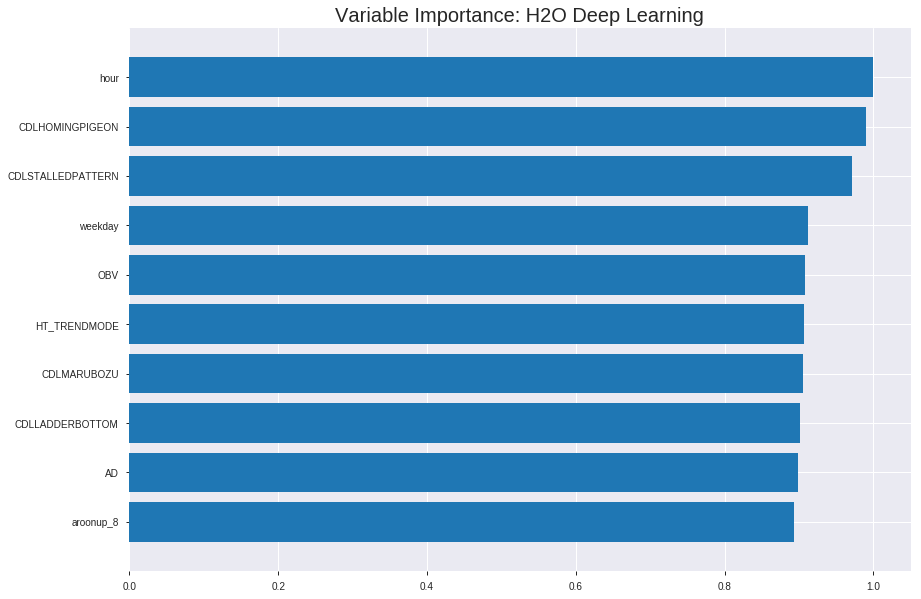

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_160506_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2594508892024048
RMSE: 0.5093632193262533
LogLoss: 0.7164066586235381
Mean Per-Class Error: 0.4619868296400884
AUC: 0.5427954031046074
pr_auc: 0.5475771949521048
Gini: 0.08559080620921478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2915888416558102: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    752   0.9934   (752.0/757.0)
1      0    799   0        (0.0/799.0)
Total  5    1551  0.4833   (752.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.291589     0.68       395
max f2                       0.291589     0.841584   395
max f0point5                 0.370639     0.573645   352
max accuracy                 0.495704     0.53856    252
max precision                0.88554      1          0
max recall                   0.291589     1          395
max specificity              0.88554      1          0
max absolute_mcc             0.573836     0.0763835  189
max min_per_class_accuracy   0.557361     0.534418   203
max mean_per_class_accuracy  0.573836     0.538013   189

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 55.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102828                   0.858195           1.21715   1.21715            0.625            0.870044  0.625                       0.870044            0.0125156       0.0125156                  21.7146    21.7146
    2        0.0205656                   0.837779           0.973717  1.09543            0.5              0.8488    0.5625                      0.859422            0.0100125       0.0225282                  -2.62829   9.54318
    3        0.0302057                   0.823476           1.29829   1.16017            0.666667         0.830149  0.595745                    0.85008             0.0125156       0.0350438                  29.829     16.0174
    4        0.0404884                   0.815362           0.973717  1.11282            0.5              0.81959   0.571429                    0.842336            0.0100125       0.0450563                  -2.62829   11.282
    5        0.0501285                   0.79998            1.16846   1.12352            0.6              0.806688  0.576923                    0.835481            0.0112641       0.0563204                  16.8461    12.352
    6        0.100257                    0.738717           1.14849   1.136              0.589744         0.766512  0.583333                    0.800996            0.057572        0.113892                   14.8487    13.6003
    7        0.150386                    0.696418           1.02365   1.09855            0.525641         0.715918  0.564103                    0.772637            0.0513141       0.165207                   2.36514    9.85527
    8        0.200514                    0.671959           1.07359   1.09231            0.551282         0.684959  0.560897                    0.750717            0.0538173       0.219024                   7.35856    9.23109
    9        0.300129                    0.625209           1.00513   1.06337            0.516129         0.648418  0.546039                    0.716763            0.100125        0.319149                   0.512738   6.33742
    10       0.400386                    0.589831           1.0611    1.06281            0.544872         0.607614  0.545746                    0.689432            0.106383        0.425532                   6.1102     6.28052
    11       0.5                         0.555617           1.10564   1.07134            0.567742         0.57335   0.550129                    0.666305            0.110138        0.53567                    10.564     7.13392
    12       0.600257                    0.514458           0.923783  1.04669            0.474359         0.535236  0.537473                    0.644414            0.0926158       0.628285                   -7.62171   4.66938
    13       0.699871                    0.469509           0.992563  1.03899            0.509677         0.489737  0.533517                    0.622398            0.0988736       0.727159                   -0.743672  3.89893
    14       0.800129                    0.428754           0.898816  1.02143            0.461538         0.448892  0.524498                    0.600658            0.0901126       0.817272                   -10.1184   2.14254
    15       0.899743                    0.381754           0.954871  1.01406            0.490323         0.406716  0.520714                    0.579186            0.0951189       0.91239                    -4.5129    1.40569
    16       1                           0.237457           0.873849  1                  0.448718         0.343462  0.513496                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2585469408064461
RMSE: 0.5084751132616483
LogLoss: 0.7114213703083112
Mean Per-Class Error: 0.45734837570764775
AUC: 0.5292798733843314
pr_auc: 0.5283648639293395
Gini: 0.05855974676866271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26806077898532676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268061     0.664662  399
max f2                       0.268061     0.832078  399
max f0point5                 0.392906     0.553737  358
max accuracy                 0.575064     0.542793  178
max precision                0.834329     1         0
max recall                   0.268061     1         399
max specificity              0.834329     1         0
max absolute_mcc             0.354858     0.131127  388
max min_per_class_accuracy   0.565176     0.529412  188
max mean_per_class_accuracy  0.575064     0.542652  178

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 54.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.744968           1.60724   1.60724            0.8              0.771983  0.8                         0.771983            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.727134           0.502262  1.11614            0.25             0.738126  0.555556                    0.756935            0.00452489      0.0226244                  -49.7738  11.6139
    3        0.0315315                   0.710622           1.60724   1.29153            0.8              0.716701  0.642857                    0.742566            0.0180995       0.040724                   60.724    29.1532
    4        0.0405405                   0.702108           0.502262  1.11614            0.25             0.706806  0.555556                    0.734619            0.00452489      0.0452489                  -49.7738  11.6139
    5        0.0518018                   0.696064           1.60724   1.2229             0.8              0.698554  0.608696                    0.726779            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.669729           1.18717   1.20543            0.590909         0.68031   0.6                         0.704061            0.0588235       0.122172                   18.7166   20.543
    7        0.150901                    0.653924           0.730564  1.0495             0.363636         0.660569  0.522388                    0.68978             0.0361991       0.158371                   -26.9436  4.95036
    8        0.20045                     0.643702           0.730564  0.970664           0.363636         0.647809  0.483146                    0.679405            0.0361991       0.19457                    -26.9436  -2.93355
    9        0.29955                     0.623067           1.27849   1.0725             0.636364         0.63373   0.533835                    0.664294            0.126697        0.321267                   27.8486   7.25003
    10       0.400901                    0.594134           1.07149   1.07225            0.533333         0.610711  0.533708                    0.650748            0.108597        0.429864                   7.14932   7.22457
    11       0.5                         0.554397           1.00452   1.05882            0.5              0.577475  0.527027                    0.636225            0.0995475       0.529412                   0.452489  5.88235
    12       0.599099                    0.518962           0.958865  1.04229            0.477273         0.540061  0.518797                    0.620318            0.0950226       0.624434                   -4.11353  4.2289
    13       0.70045                     0.475471           0.937557  1.02713            0.466667         0.496454  0.511254                    0.602396            0.0950226       0.719457                   -6.24434  2.71348
    14       0.79955                     0.436584           0.867544  1.00735            0.431818         0.454383  0.501408                    0.584051            0.0859729       0.80543                    -13.2456  0.735453
    15       0.898649                    0.396003           1.00452   1.00704            0.5              0.416168  0.501253                    0.565537            0.0995475       0.904977                   0.452489  0.704249
    16       1                           0.268061           0.937557  1                  0.466667         0.366136  0.497748                    0.545328           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:08:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:08:26  3 min 13.317 sec  451 obs/sec       0.572622  1             891        0.67406          6.4608              -0.818752      0.530606        0.385376           0.954625         0.486504                         0.664868           6.04158               -0.768232        0.550525          0.382834             1.46113            0.486486
    2019-08-27 16:08:35  3 min 22.826 sec  426 obs/sec       2.9126    5             4532       0.553945         0.946351            -0.228316      0.562698        0.573493           1.58229          0.484576                         0.585179           1.05299               -0.369766        0.553974          0.553846             1.20543            0.484234
    2019-08-27 16:08:44  3 min 31.861 sec  433 obs/sec       5.23522   9             8146       0.509363         0.716407            -0.0385602     0.542795        0.547577           1.21715          0.48329                          0.508475           0.711421              -0.0342087       0.52928           0.528365             1.60724            0.502252
    2019-08-27 16:08:53  3 min 40.791 sec  438 obs/sec       7.57905   13            11793      0.510608         0.720273            -0.0436411     0.561767        0.556647           1.46058          0.462725                         0.542851           0.799168              -0.178773        0.503206          0.499539             0.80362            0.502252
    2019-08-27 16:09:03  3 min 51.182 sec  448 obs/sec       10.4839   18            16313      0.530828         0.776611            -0.127937      0.53206         0.542045           1.33886          0.483933                         0.540403           0.79815               -0.168163        0.482154          0.483325             0.80362            0.486486
    2019-08-27 16:09:13  4 min  1.092 sec  441 obs/sec       12.8683   22            20023      0.508081         0.715037            -0.0333399     0.574818        0.58501            1.46058          0.48329                          0.519715           0.740485              -0.0804362       0.51184           0.502909             1.20543            0.502252
    2019-08-27 16:09:23  4 min 10.952 sec  451 obs/sec       15.786    27            24563      0.545965         0.848946            -0.19318       0.534206        0.546478           1.58229          0.486504                         0.573708           0.950573              -0.316592        0.473196          0.481432             0.80362            0.5
    2019-08-27 16:09:33  4 min 20.633 sec  460 obs/sec       18.7018   32            29100      0.568641         1.27311             -0.294355      0.548461        0.532382           1.21715          0.474293                         0.612459           1.57902               -0.500455        0.480632          0.478843             0.40181            0.502252
    2019-08-27 16:09:34  4 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
hour                      1.0                    1.0                  0.0014795077384839818
CDLHOMINGPIGEON           0.9896095991134644     0.9896095991134644   0.0014641350599664015
CDLSTALLEDPATTERN         0.9720009565353394     0.9720009565353394   0.0014380829370078672
weekday                   0.9127172231674194     0.9127172231674194   0.0013503721947238085
OBV                       0.9084611535072327     0.9084611535072327   0.0013440753067260353
---                       ---                    ---                  ---
BBANDS_middleband_8_7_4   0.571532130241394      0.571532130241394    0.0008455862094843775
MA_20_3                   0.5714520215988159     0.5714520215988159   0.0008454676881277637
TYPPRICE                  0.5676620006561279     0.5676620006561279   0.0008398603228140405
BBANDS_middleband_8_0_3   0.5636885166168213     0.5636885166168213   0.0008339815224291437
BBANDS_middleband_14_1_2  0.5565921068191528     0.5565921068191528   0.0008234823292180397


See the whole table with table.as_data_frame()


('accuracy', 0.5605381165919282)

('F1', 0.6545454545454547)

('auc', 0.5394524959742352)

('logloss', 0.8747091781642095)

('mean_per_class_error', 0.44396135265700476)

('rmse', 0.5664804881876713)

('mse', 0.32090014349734236)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


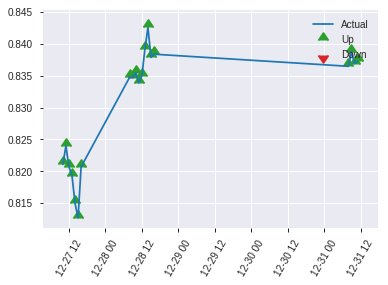


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.32090014349734236
RMSE: 0.5664804881876713
LogLoss: 0.8747091781642095
Mean Per-Class Error: 0.44396135265700476
AUC: 0.5394524959742352
pr_auc: 0.5206244999200472
Gini: 0.07890499194847034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5399551402889081: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    114  0.9913   (114.0/115.0)
1      0    108  0        (0.0/108.0)
Total  1    222  0.5112   (114.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539955     0.654545  221
max f2                       0.539955     0.825688  221
max f0point5                 0.621636     0.545852  201
max accuracy                 0.817928     0.560538  49
max precision                0.905116     1         0
max recall                   0.539955     1         221
max specificity              0.905116     1         0
max absolute_mcc             0.817928     0.124457  49
max min_per_class_accuracy   0.759568     0.555556  110
max mean_per_class_accuracy  0.759568     0.556039  110

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 74.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.902136           1.37654   1.37654            0.666667         0.90425   0.666667                    0.90425             0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.895957           1.03241   1.23889            0.5              0.898335  0.6                         0.901884            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.894679           1.03241   1.17989            0.5              0.895154  0.571429                    0.899961            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.893041           2.06481   1.37654            1                0.893922  0.666667                    0.898619            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.890946           1.37654   1.37654            0.666667         0.891737  0.666667                    0.896898            0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.885154           0.938552  1.16707            0.454545         0.888201  0.565217                    0.892739            0.0462963       0.12037                    -6.14478  16.7069
    7        0.152466                    0.873034           0.938552  1.09314            0.454545         0.88012   0.529412                    0.888656            0.0462963       0.166667                   -6.14478  9.31373
    8        0.201794                    0.826864           1.50168   1.193              0.727273         0.861355  0.577778                    0.881982            0.0740741       0.240741                   50.1684   19.3004
    9        0.300448                    0.800508           1.03241   1.14027            0.5              0.812219  0.552239                    0.859075            0.101852        0.342593                   3.24074   14.0271
    10       0.399103                    0.770829           0.938552  1.09041            0.454545         0.784437  0.52809                     0.840625            0.0925926       0.435185                   -6.14478  9.04078
    11       0.502242                    0.755015           1.16707   1.10615            0.565217         0.764527  0.535714                    0.824998            0.12037         0.555556                   16.7069   10.6151
    12       0.600897                    0.721986           0.563131  1.017              0.272727         0.740059  0.492537                    0.811053            0.0555556       0.611111                   -43.6869  1.69983
    13       0.699552                    0.68769            0.844697  0.992699           0.409091         0.700115  0.480769                    0.795408            0.0833333       0.694444                   -15.5303  -0.730057
    14       0.798206                    0.665555           1.03241   0.997607           0.5              0.675656  0.483146                    0.780607            0.101852        0.796296                   3.24074   -0.239284
    15       0.896861                    0.623591           1.22012   1.02208            0.590909         0.646119  0.495                       0.765813            0.12037         0.916667                   22.0118   2.20833
    16       1                           0.525459           0.807971  1                  0.391304         0.57608   0.484305                    0.746244     

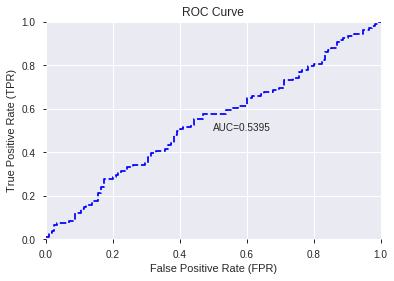

This function is available for GLM models only


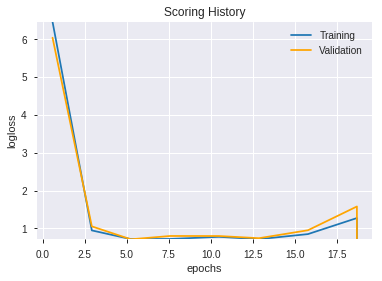

--2019-08-27 16:29:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.4MB/s    in 23s     

2019-08-27 16:30:22 (15.1 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_160506_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_160506_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_163035_model_8  0.581320  0.701021              0.474195  0.503905  0.253920
1  DeepLearning_grid_1_AutoML_20190827_163035_model_7  0.562399  0.939465              0.474195  0.563799  0.317869
2               DeepLearning_1_AutoML_20190827_163035  0.557568  0.855006              0.450644  0.549664  0.302131
3  DeepLearning_grid_1_AutoML_20190827_163035_model_4  0.550403  1.534239              0.487238  0.618141  0.382099
4  DeepLearning_grid_1_AutoML_20190827_163035_model_9  0.548631  0.691209              0.474477  0.499031  0.249032
5  DeepLearning_grid_1_AutoML_20190827_163035_model_3  0.538728  1.351012              0.470692  0.603701  0.364455
6  DeepLearning_grid_1_AutoML_20190827_163035_model_6  0.533092  0.704416              0.478543  0.505378  0.255407
7  DeepLearning_grid_1_AutoML_20190827_163035_model_5  0.532287  0.751929              0.486957  0.524871  0.275489
8  DeepLearning_grid_1_AutoML_20190827_163035_model_1  0.511675  1.585945              0.473913  0.613825  0.376781
9  DeepLearning_grid_1_AutoML_20190827_163035_model_2  0.503382  1.272183              0.478261  0.611903  0.374426

variable  relative_importance  scaled_importance  percentage
0                     AD             1.000000           1.000000    0.024835
1              aroonup_8             0.965966           0.965966    0.023989
2           HT_TRENDMODE             0.921791           0.921791    0.022892
3              CORREL_30             0.897922           0.897922    0.022300
4                BETA_30             0.882184           0.882184    0.021909
5                   hour             0.881567           0.881567    0.021893
6                    OBV             0.862940           0.862940    0.021431
7         STOCHRSI_fastk             0.849626           0.849626    0.021100
8      CDLLONGLEGGEDDOJI             0.849248           0.849248    0.021091
9                BETA_20             0.846106           0.846106    0.021013
10            aroonup_20             0.845224           0.845224    0.020991
11           CDLMARUBOZU             0.823494           0.823494    0.020451
12           AROONOSC_14             0.823367           0.823367    0.020448
13            aroonup_30             0.823025           0.823025    0.020439
14               WILLR_8             0.817763           0.817763    0.020309
15                MFI_14             0.817748           0.817748    0.020308
16                 DX_30             0.815602           0.815602    0.020255
17             dayofweek             0.815018           0.815018    0.020241
18     CDLSTALLEDPATTERN             0.811412           0.811412    0.020151
19              CORREL_8             0.810188           0.810188    0.020121
20         days_in_month             0.806449           0.806449    0.020028
21                   day             0.799989           0.799989    0.019867
22        is_month_start             0.798440           0.798440    0.019829
23            aroonup_12             0.795899           0.795899    0.019766
24                   SUB             0.794823           0.794823    0.019739
25                 MFI_8             0.790893           0.790893    0.019641
26          weekday_name             0.789372           0.789372    0.019604
27                 ADOSC             0.788244           0.788244    0.019576
28              WILLR_12             0.786189           0.786189    0.019525
29                 CCI_8             0.785740           0.785740    0.019514
30           STOCH_slowd             0.785129           0.785129    0.019498
31       CDLLADDERBOTTOM             0.784269           0.784269    0.019477
32        MACDFIX_hist_8             0.782274           0.782274    0.019427
33          aroondown_30             0.781194           0.781194    0.019401
34          STOCHF_fastk             0.780294           0.780294    0.019378
35     CDLINVERTEDHAMMER             0.778293           0.778293    0.019329
36          CDLTHRUSTING             0.772192           0.772192    0.019177
37  HT_PHASOR_quadrature             0.771487           0.771487    0.019160
38               weekday             0.770500           0.770500    0.019135
39          STOCHF_fastd             0.761768           0.761768    0.018918
40    CDLEVENINGDOJISTAR             0.761066           0.761066    0.018901
41        STOCHRSI_fastd             0.759280           0.759280    0.018856
42       CDLUNIQUE3RIVER             0.757245           0.757245    0.018806
43        CDLEVENINGSTAR             0.748878           0.748878    0.018598
44                   BOP             0.740312           0.740312    0.018385
45   CDLGAPSIDESIDEWHITE             0.735558           0.735558    0.018267
46     CDLDARKCLOUDCOVER             0.734244           0.734244    0.018235
47       CDLHOMINGPIGEON             0.730654           0.730654    0.018145
48       CDLSHOOTINGSTAR             0.718140           0.718140    0.017835
49          CDLTASUKIGAP             0.717436           0.717436    0.017817

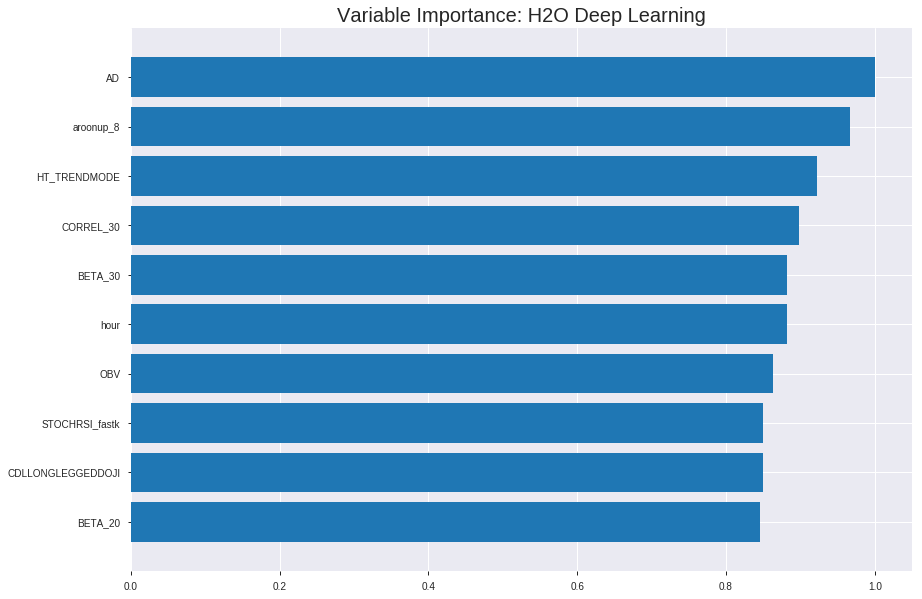

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_163035_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24710253095347398
RMSE: 0.4970940866209072
LogLoss: 0.6872703630917063
Mean Per-Class Error: 0.42478874683182244
AUC: 0.5999300644960758
pr_auc: 0.615299188094077
Gini: 0.19986012899215155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5182101925063485: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      116  641   0.8468   (641.0/757.0)
1      48   751   0.0601   (48.0/799.0)
Total  164  1392  0.4428   (689.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51821      0.685532  335
max f2                       0.491517     0.841407  395
max f0point5                 0.52632      0.590778  303
max accuracy                 0.549581     0.573907  192
max precision                0.664646     1         0
max recall                   0.491517     1         395
max specificity              0.664646     1         0
max absolute_mcc             0.561872     0.166186  131
max min_per_class_accuracy   0.546656     0.560701  205
max mean_per_class_accuracy  0.549581     0.575211  192

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 54.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.614866           1.70401   1.70401            0.875            0.628682  0.875                       0.628682            0.0175219       0.0175219                  70.4005   70.4005
    2        0.0205656                   0.602757           1.33886   1.52143            0.6875           0.606724  0.78125                     0.617703            0.0137672       0.0312891                  33.8861   52.1433
    3        0.0302057                   0.596881           1.68778   1.57452            0.866667         0.599274  0.808511                    0.611821            0.0162703       0.0475594                  68.7776   57.4521
    4        0.0404884                   0.59107            1.21715   1.48376            0.625            0.593716  0.761905                    0.607223            0.0125156       0.0600751                  21.7146   48.3759
    5        0.0501285                   0.586531           1.42812   1.47306            0.733333         0.587957  0.75641                     0.603518            0.0137672       0.0738423                  42.8118   47.3059
    6        0.100257                    0.575958           1.37319   1.42313            0.705128         0.580318  0.730769                    0.591918            0.068836        0.142678                   37.3191   42.3125
    7        0.150386                    0.570509           1.14849   1.33158            0.589744         0.572955  0.683761                    0.585597            0.057572        0.20025                    14.8487   33.1579
    8        0.200514                    0.566125           1.19842   1.29829            0.615385         0.568336  0.666667                    0.581282            0.0600751       0.260325                   19.8421   29.829
    9        0.300129                    0.558568           1.10564   1.23435            0.567742         0.562334  0.633833                    0.574993            0.110138        0.370463                   10.564    23.4348
    10       0.400386                    0.553032           0.973717  1.16909            0.5              0.555636  0.600321                    0.570146            0.097622        0.468085                   -2.62829  16.9086
    11       0.5                         0.546495           0.929743  1.1214             0.477419         0.549686  0.575835                    0.56607             0.0926158       0.560701                   -7.02572  12.1402
    12       0.600257                    0.540484           0.886332  1.08214            0.455128         0.543293  0.555675                    0.562266            0.0888611       0.649562                   -11.3668  8.21396
    13       0.699871                    0.534113           0.917179  1.05866            0.470968         0.537654  0.543618                    0.558763            0.0913642       0.740926                   -8.28213  5.86603
    14       0.800129                    0.527233           1.0611    1.05897            0.544872         0.53047   0.543775                    0.555217            0.106383        0.847309                   6.1102    5.89663
    15       0.899743                    0.517709           0.954871  1.04744            0.490323         0.523378  0.537857                    0.551692            0.0951189       0.942428                   -4.5129   4.74414
    16       1                           0.478182           0.574243  1                  0.294872         0.508066  0.513496                    0.547319          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2528211574840005
RMSE: 0.5028132431469964
LogLoss: 0.6988184049719239
Mean Per-Class Error: 0.4663981494633038
AUC: 0.5066250025363715
pr_auc: 0.5086694054890002
Gini: 0.013250005072743098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4942111645758517: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.494211     0.664662   399
max f2                       0.494211     0.832078   399
max f0point5                 0.494211     0.55333    399
max accuracy                 0.551377     0.533784   180
max precision                0.635411     1          0
max recall                   0.494211     1          399
max specificity              0.635411     1          0
max absolute_mcc             0.53197      0.0926374  315
max min_per_class_accuracy   0.549422     0.520179   196
max mean_per_class_accuracy  0.551377     0.533602   180

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 54.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.604336           1.60724   1.60724            0.8              0.622727  0.8                         0.622727            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.592687           0.502262  1.11614            0.25             0.597016  0.555556                    0.6113              0.00452489      0.0226244                  -49.7738  11.6139
    3        0.0315315                   0.585729           1.20543   1.14803            0.6              0.590306  0.571429                    0.603802            0.0135747       0.0361991                  20.543    14.8028
    4        0.0405405                   0.581757           0.502262  1.00452            0.25             0.583069  0.5                         0.599195            0.00452489      0.040724                   -49.7738  0.452489
    5        0.0518018                   0.580058           1.20543   1.0482             0.6              0.580951  0.521739                    0.595229            0.0135747       0.0542986                  20.543    4.81999
    6        0.101351                    0.570884           0.913204  0.982202           0.454545         0.573472  0.488889                    0.584592            0.0452489       0.0995475                  -8.67956  -1.77979
    7        0.150901                    0.567749           1.09585   1.01952            0.545455         0.569399  0.507463                    0.579603            0.0542986       0.153846                   9.58453   1.95178
    8        0.20045                     0.564096           1.18717   1.06096            0.590909         0.565887  0.52809                     0.576213            0.0588235       0.21267                    18.7166   6.09589
    9        0.29955                     0.559716           0.958865  1.02718            0.477273         0.561899  0.511278                    0.571477            0.0950226       0.307692                   -4.11353  2.71833
    10       0.400901                    0.555344           1.16078   1.06096            0.577778         0.557243  0.52809                     0.567879            0.117647        0.425339                   16.0784   6.09589
    11       0.5                         0.549402           0.958865  1.04072            0.477273         0.552146  0.518018                    0.564761            0.0950226       0.520362                   -4.11353  4.0724
    12       0.599099                    0.544749           0.958865  1.02718            0.477273         0.547064  0.511278                    0.561833            0.0950226       0.615385                   -4.11353  2.71833
    13       0.70045                     0.538088           0.758974  0.988375           0.377778         0.541823  0.491961                    0.558938            0.0769231       0.692308                   -24.1026  -1.1625
    14       0.79955                     0.531995           0.730564  0.956421           0.363636         0.535275  0.476056                    0.556005            0.0723982       0.764706                   -26.9436  -4.35791
    15       0.898649                    0.520391           1.32415   0.996972           0.659091         0.527961  0.496241                    0.552913            0.131222        0.895928                   32.4146   -0.302793
    16       1                           0.494211           1.02685   1                  0.511111         0.511691  0.497748                    0.548735      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:35:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:35:36  1 min 10.209 sec  698 obs/sec       0.615039  1             957        0.615236         1.05917             -0.515165      0.549607        0.56828            1.46058          0.471722                         0.616431           1.07597               -0.519979        0.49163           0.489115             1.20543            0.5
    2019-08-27 16:35:45  1 min 18.616 sec  1078 obs/sec      6.22429   10            9685       0.497094         0.68727             0.0108692      0.59993         0.615299           1.70401          0.442802                         0.502813           0.698818              -0.0113051       0.506625          0.508669             1.60724            0.502252
    2019-08-27 16:35:53  1 min 27.244 sec  1205 obs/sec      13.0199   21            20259      0.490841         0.674054            0.0355997      0.618083        0.637406           1.82572          0.446015                         0.503921           0.702361              -0.0157655       0.493476          0.503153             1.60724            0.502252
    2019-08-27 16:36:02  1 min 35.796 sec  1295 obs/sec      20.4306   33            31790      0.485041         0.660624            0.0582549      0.636278        0.65625            1.94743          0.431234                         0.504125           0.711868              -0.0165902       0.517958          0.534225             1.60724            0.497748
    2019-08-27 16:36:10  1 min 44.360 sec  1372 obs/sec      28.4987   46            44344      0.482993         0.654643            0.0661893      0.649763        0.676137           1.94743          0.409383                         0.508836           0.721466              -0.0356791       0.529067          0.546267             1.60724            0.5
    2019-08-27 16:36:19  1 min 52.842 sec  1446 obs/sec      37.1767   60            57847      0.470705         0.62745             0.1131         0.671562        0.704633           1.94743          0.388817                         0.507833           0.728221              -0.0315994       0.489936          0.524024             1.20543            0.497748
    2019-08-27 16:36:27  2 min  1.080 sec  1504 obs/sec      45.8445   74            71334      0.456127         0.592245            0.167184       0.708466        0.73007            1.94743          0.368252                         0.517082           0.779952              -0.0695152       0.513585          0.54719              1.60724            0.493243
    2019-08-27 16:36:28  2 min  1.933 sec  1503 obs/sec      45.8445   74            71334      0.497094         0.68727             0.0108692      0.59993         0.615299           1.70401          0.442802                         0.502813           0.698818              -0.0113051       0.506625          0.508669             1.60724            0.502252

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
AD                   1.0                    1.0                  0.024834574289156804
aroonup_8            0.9659662246704102     0.9659662246704102   0.023989359967393632
HT_TRENDMODE         0.9217905402183533     0.9217905402183533   0.022892275650094676
CORREL_30            0.8979222178459167     0.8979222178459167   0.022299516024978858
BETA_30              0.8821840286254883     0.8821840286254883   0.02190866479560732
---                  ---                    ---                  ---
CDLGAPSIDESIDEWHITE  0.7355579137802124     0.7355579137802124   0.01826726765375188
CDLDARKCLOUDCOVER    0.7342438697814941     0.7342438697814941   0.01823463393044649
CDLHOMINGPIGEON      0.7306543588638306     0.7306543588638306   0.018145489954900035
CDLSHOOTINGSTAR      0.7181403040885925     0.7181403040885925   0.01783470873192581
CDLTASUKIGAP         0.7174363136291504     0.7174363136291504   0.017817225428561935


See the whole table with table.as_data_frame()


('accuracy', 0.5874439461883408)

('F1', 0.6625386996904026)

('auc', 0.5813204508856682)

('logloss', 0.701020670068627)

('mean_per_class_error', 0.4104267310789049)

('rmse', 0.5039047887755608)

('mse', 0.2539200361509425)

deeplearning prediction progress: |███████████████████████████████████████| 100%


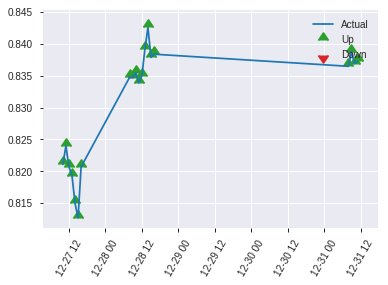


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2539200361509425
RMSE: 0.5039047887755608
LogLoss: 0.701020670068627
Mean Per-Class Error: 0.4104267310789049
AUC: 0.5813204508856682
pr_auc: 0.5503889296443465
Gini: 0.1626409017713364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5298390878812006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    108  0.9391   (108.0/115.0)
1      1    107  0.0093   (1.0/108.0)
Total  8    215  0.4888   (109.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529839     0.662539  214
max f2                       0.522185     0.828221  219
max f0point5                 0.561303     0.580065  125
max accuracy                 0.561303     0.587444  125
max precision                0.657265     1         0
max recall                   0.522185     1         219
max specificity              0.657265     1         0
max absolute_mcc             0.561303     0.180592  125
max min_per_class_accuracy   0.564469     0.556522  111
max mean_per_class_accuracy  0.561303     0.589573  125

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 56.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.62727            2.06481   2.06481            1                0.642213  1                           0.642213            0.0277778       0.0277778                  106.481   106.481
    2        0.0224215                   0.621676           0         1.23889            0                0.625351  0.6                         0.635468            0               0.0277778                  -100      23.8889
    3        0.0313901                   0.610012           2.06481   1.47487            1                0.615432  0.714286                    0.629743            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.607385           1.03241   1.37654            0.5              0.608202  0.666667                    0.624957            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.605941           0.688272  1.20448            0.333333         0.606468  0.583333                    0.620334            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.59447            1.12626   1.16707            0.545455         0.599789  0.565217                    0.610508            0.0555556       0.12037                    12.6263   16.7069
    7        0.152466                    0.592437           1.31397   1.2146             0.636364         0.593311  0.588235                    0.604944            0.0648148       0.185185                   31.3973   21.4597
    8        0.201794                    0.589071           1.31397   1.23889            0.636364         0.590652  0.6                         0.601451            0.0648148       0.25                       31.3973   23.8889
    9        0.300448                    0.580366           1.03241   1.17109            0.5              0.585585  0.567164                    0.596241            0.101852        0.351852                   3.24074   17.1089
    10       0.399103                    0.57238            0.844697  1.09041            0.409091         0.577209  0.52809                     0.591537            0.0833333       0.435185                   -15.5303  9.04078
    11       0.502242                    0.564469           1.25684   1.12459            0.608696         0.56878   0.544643                    0.586863            0.12963         0.564815                   25.6844   12.4587
    12       0.600897                    0.559319           1.22012   1.14027            0.590909         0.561599  0.552239                    0.582715            0.12037         0.685185                   22.0118   14.0271
    13       0.699552                    0.554747           0.656987  1.07212            0.318182         0.557135  0.519231                    0.579108            0.0648148       0.75                       -34.3013  7.21154
    14       0.798206                    0.549665           0.656987  1.02081            0.318182         0.552149  0.494382                    0.575776            0.0648148       0.814815                   -34.3013  2.08073
    15       0.896861                    0.542474           1.22012   1.04273            0.590909         0.547049  0.505                       0.572616            0.12037         0.935185                   22.0118   4.27315
    16       1                           0.515972           0.628422  1                  0.304348         0.531682  0.484305                    0.568394         

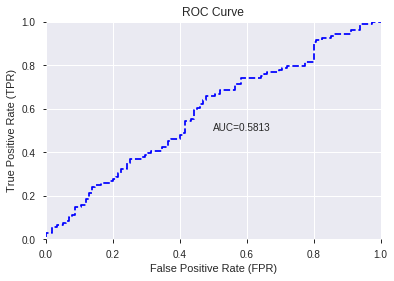

This function is available for GLM models only


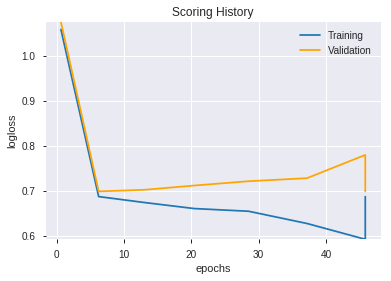

--2019-08-27 16:37:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_163035_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_163035_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['AD',
 'aroonup_8',
 'HT_TRENDMODE',
 'CORREL_30',
 'BETA_30',
 'hour',
 'OBV',
 'STOCHRSI_fastk',
 'CDLLONGLEGGEDDOJI',
 'BETA_20',
 'aroonup_20',
 'CDLMARUBOZU',
 'AROONOSC_14',
 'aroonup_30',
 'WILLR_8',
 'MFI_14',
 'DX_30',
 'dayofweek',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'days_in_month',
 'day',
 'is_month_start',
 'aroonup_12',
 'SUB',
 'MFI_8',
 'weekday_name',
 'ADOSC',
 'WILLR_12',
 'CCI_8',
 'STOCH_slowd',
 'CDLLADDERBOTTOM',
 'MACDFIX_hist_8',
 'aroondown_30',
 'STOCHF_fastk',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'HT_PHASOR_quadrature',
 'weekday',
 'STOCHF_fastd',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastd',
 'CDLUNIQUE3RIVER',
 'CDLEVENINGSTAR',
 'BOP',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'CDLSHOOTINGSTAR',
 'CDLTASUKIGAP']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_163740_model_1  0.564171  0.693499              0.491304  0.500176  0.250176

variable  relative_importance  scaled_importance  percentage
0                     AD             0.009196           1.000000    0.059175
1              CORREL_30             0.007025           0.763925    0.045205
2         CDLEVENINGSTAR             0.006732           0.732000    0.043316
3                BETA_30             0.006727           0.731485    0.043286
4      CDLSTALLEDPATTERN             0.006653           0.723496    0.042813
5                BETA_20             0.006446           0.700894    0.041475
6                    OBV             0.006296           0.684629    0.040513
7            CDLMARUBOZU             0.006142           0.667851    0.039520
8           HT_TRENDMODE             0.005599           0.608838    0.036028
9        CDLLADDERBOTTOM             0.005245           0.570302    0.033748
10       CDLSHOOTINGSTAR             0.004931           0.536165    0.031728
11             aroonup_8             0.004908           0.533713    0.031582
12          CDLTHRUSTING             0.004253           0.462519    0.027370
13          CDLTASUKIGAP             0.004251           0.462257    0.027354
14    CDLEVENINGDOJISTAR             0.004034           0.438633    0.025956
15                  hour             0.003931           0.427436    0.025294
16        STOCHRSI_fastk             0.003770           0.409969    0.024260
17        is_month_start             0.003642           0.396089    0.023439
18     CDLINVERTEDHAMMER             0.003606           0.392149    0.023205
19       CDLUNIQUE3RIVER             0.003175           0.345215    0.020428
20            aroonup_12             0.003146           0.342119    0.020245
21          aroondown_30             0.003137           0.341099    0.020185
22          STOCHF_fastk             0.003089           0.335913    0.019878
23   CDLGAPSIDESIDEWHITE             0.003089           0.335911    0.019878
24                   BOP             0.003075           0.334412    0.019789
25            aroonup_30             0.003054           0.332070    0.019650
26     CDLLONGLEGGEDDOJI             0.002973           0.323264    0.019129
27                 MFI_8             0.002619           0.284774    0.016851
28              CORREL_8             0.002581           0.280648    0.016607
29            aroonup_20             0.002277           0.247586    0.014651
30                   day             0.002192           0.238307    0.014102
31              WILLR_12             0.002015           0.219129    0.012967
32               WILLR_8             0.001856           0.201794    0.011941
33                 CCI_8             0.001592           0.173068    0.010241
34       CDLHOMINGPIGEON             0.001534           0.166805    0.009871
35  HT_PHASOR_quadrature             0.001510           0.164202    0.009717
36        STOCHRSI_fastd             0.001478           0.160744    0.009512
37                 DX_30             0.001408           0.153131    0.009062
38        MACDFIX_hist_8             0.001396           0.151770    0.008981
39           STOCH_slowd             0.001312           0.142619    0.008440
40                 ADOSC             0.001166           0.126801    0.007503
41          STOCHF_fastd             0.000745           0.080995    0.004793
42                MFI_14             0.000565           0.061452    0.003636
43           AROONOSC_14             0.000556           0.060441    0.003577
44     CDLDARKCLOUDCOVER             0.000199           0.021679    0.001283
45          weekday_name             0.000129           0.014029    0.000830
46             dayofweek             0.000055           0.006032    0.000357
47               weekday             0.000052           0.005660    0.000335
48         days_in_month             0.000046           0.005015    0.000297
49                   SUB             0.000000           0.000000    0.000000

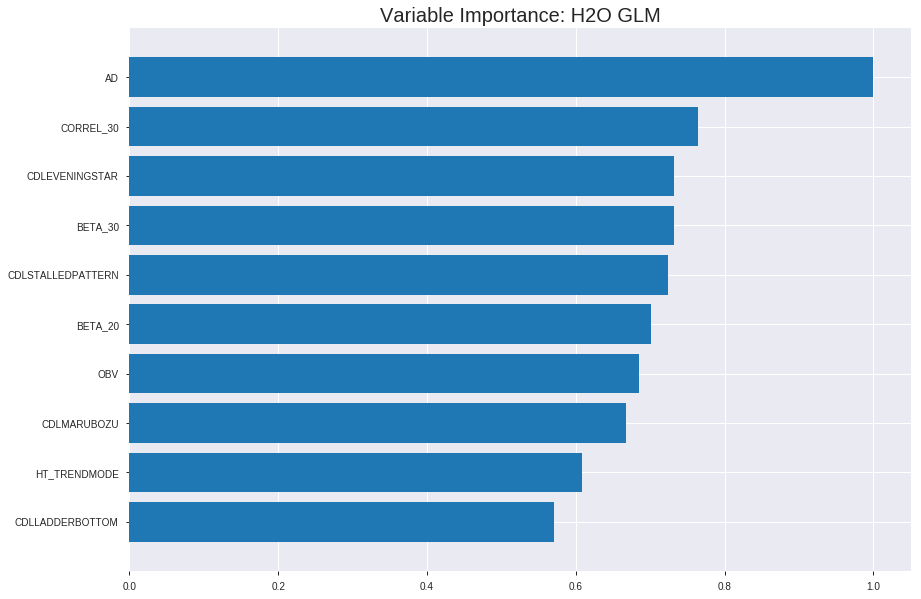

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163740_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24833417107579345
RMSE: 0.4983313868058016
LogLoss: 0.6898105074308292
Null degrees of freedom: 1555
Residual degrees of freedom: 1506
Null deviance: 2155.940212106897
Residual deviance: 2146.6902991247402
AIC: 2246.6902991247402
AUC: 0.5959885457879153
pr_auc: 0.6162834420931889
Gini: 0.19197709157583054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49344391438501556: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    749   0.9894   (749.0/757.0)
1      1    798   0.0013   (1.0/799.0)
Total  9    1547  0.482    (750.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493444     0.680307  391
max f2                       0.490441     0.841407  395
max f0point5                 0.507541     0.585457  288
max accuracy                 0.515273     0.573265  176
max precision                0.566162     1         0
max recall                   0.490441     1         395
max specificity              0.566162     1         0
max absolute_mcc             0.515273     0.157696  176
max min_per_class_accuracy   0.512986     0.562748  211
max mean_per_class_accuracy  0.515273     0.576564  176

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.539308           1.70401   1.70401            0.875            0.547523  0.875                       0.547523            0.0175219       0.0175219                  70.4005   70.4005
    2        0.0205656                   0.532733           1.58229   1.64315            0.8125           0.535623  0.84375                     0.541573            0.0162703       0.0337922                  58.229    64.3148
    3        0.0302057                   0.530052           1.55795   1.61596            0.8              0.531294  0.829787                    0.538292            0.0150188       0.048811                   55.7947   61.5956
    4        0.0404884                   0.528155           1.46058   1.57649            0.75             0.529034  0.809524                    0.535941            0.0150188       0.0638298                  46.0576   57.6494
    5        0.0501285                   0.527159           1.42812   1.54796            0.733333         0.527507  0.794872                    0.534319            0.0137672       0.077597                   42.8118   54.7961
    6        0.100257                    0.52327            1.14849   1.34822            0.589744         0.524983  0.692308                    0.529651            0.057572        0.135169                   14.8487   34.8224
    7        0.150386                    0.521218           1.29829   1.33158            0.666667         0.52224   0.683761                    0.527181            0.0650814       0.20025                    29.829    33.1579
    8        0.200514                    0.519578           1.07359   1.26708            0.551282         0.520398  0.650641                    0.525485            0.0538173       0.254068                   7.35856   26.7081
    9        0.300129                    0.517103           1.06795   1.20099            0.548387         0.51843   0.616702                    0.523143            0.106383        0.360451                   6.79478   20.0987
    10       0.400386                    0.514908           1.07359   1.16909            0.551282         0.515935  0.600321                    0.521338            0.107635        0.468085                   7.35856   16.9086
    11       0.5                         0.513079           0.942307  1.1239             0.483871         0.51398   0.577121                    0.519872            0.0938673       0.561952                   -5.76931  12.3905
    12       0.600257                    0.511044           0.873849  1.08214            0.448718         0.512014  0.555675                    0.51856             0.0876095       0.649562                   -12.6151  8.21396
    13       0.699871                    0.50922            0.979999  1.0676             0.503226         0.510129  0.548209                    0.51736             0.097622        0.747184                   -2.00008  6.76017
    14       0.800129                    0.506959           0.923783  1.04958            0.474359         0.508064  0.538956                    0.516195            0.0926158       0.8398                     -7.62171  4.95811
    15       0.899743                    0.503859           0.904615  1.03353            0.464516         0.505583  0.530714                    0.51502             0.0901126       0.929912                   -9.53854  3.35312
    16       1                           0.473128           0.699079  1                  0.358974         0.49982   0.513496                    0.513496         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25050710748459587
RMSE: 0.5005068505870782
LogLoss: 0.6941617288390962
Null degrees of freedom: 443
Residual degrees of freedom: 394
Null deviance: 615.9463007458467
Residual deviance: 616.4156152091174
AIC: 716.4156152091174
AUC: 0.4875210518840168
pr_auc: 0.5072325016724056
Gini: -0.024957896231966425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47621359108991534: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476214     0.664662  399
max f2                       0.476214     0.832078  399
max f0point5                 0.476214     0.55333   399
max accuracy                 0.525838     0.52027   17
max precision                0.535923     0.8       4
max recall                   0.476214     1         399
max specificity              0.563781     0.995516  0
max absolute_mcc             0.4989       0.147738  387
max min_per_class_accuracy   0.513935     0.488789  197
max mean_per_class_accuracy  0.522482     0.518384  35

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.534662           1.60724   1.60724            0.8              0.547939  0.8                         0.547939            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.529778           1.00452   1.33937            0.5              0.531257  0.666667                    0.540525            0.00904977      0.0271493                  0.452489  33.9367
    3        0.0315315                   0.527011           1.20543   1.29153            0.6              0.527945  0.642857                    0.536032            0.0135747       0.040724                   20.543    29.1532
    4        0.0405405                   0.525826           2.00905   1.45098            1                0.526443  0.722222                    0.533901            0.0180995       0.0588235                  100.905   45.098
    5        0.0518018                   0.524513           0.40181   1.2229             0.2              0.52506   0.608696                    0.531979            0.00452489      0.0633484                  -59.819   22.29
    6        0.101351                    0.521745           1.09585   1.16078            0.545455         0.522975  0.577778                    0.527577            0.0542986       0.117647                   9.58453   16.0784
    7        0.150901                    0.520272           0.730564  1.01952            0.363636         0.521009  0.507463                    0.52542             0.0361991       0.153846                   -26.9436  1.95178
    8        0.20045                     0.518853           1.18717   1.06096            0.590909         0.519425  0.52809                     0.523938            0.0588235       0.21267                    18.7166   6.09589
    9        0.29955                     0.517349           0.821884  0.981866           0.409091         0.518001  0.488722                    0.521974            0.081448        0.294118                   -17.8116  -1.81336
    10       0.400901                    0.515712           0.892911  0.959378           0.444444         0.516596  0.477528                    0.520615            0.0904977       0.384615                   -10.7089  -4.06223
    11       0.5                         0.51394            1.05019   0.977376           0.522727         0.514716  0.486486                    0.519446            0.104072        0.488688                   5.01851   -2.26244
    12       0.599099                    0.511651           0.913204  0.966761           0.454545         0.512925  0.481203                    0.518367            0.0904977       0.579186                   -8.67956  -3.32392
    13       0.70045                     0.509449           0.937557  0.962535           0.466667         0.510544  0.4791                      0.517235            0.0950226       0.674208                   -6.24434  -3.74649
    14       0.79955                     0.507119           1.14151   0.984717           0.568182         0.508279  0.490141                    0.516125            0.113122        0.78733                    14.1506   -1.52826
    15       0.898649                    0.503782           1.09585   0.996972           0.545455         0.505708  0.496241                    0.514976            0.108597        0.895928                   9.58453   -0.302793
    16       1                           0.476214           1.02685   1                  0.511111         0.499329  0.497748                    0.51339      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:37:41  0.000 sec   2            3.9       50            1.37962           1.38832
    2019-08-27 16:37:41  0.066 sec   4            2.4       51            1.37671           1.389
    2019-08-27 16:37:41  0.136 sec   6            1.5       51            1.37281           1.39011
    2019-08-27 16:37:41  0.166 sec   8            0.93      51            1.36794           1.39185
    2019-08-27 16:37:41  0.199 sec   10           0.58      51            1.36231           1.3945

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6565349544072948)

('auc', 0.564170692431562)

('logloss', 0.6934992812886872)

('mean_per_class_error', 0.4341384863123994)

('rmse', 0.5001763639699363)

('mse', 0.2501763950741861)

glm prediction progress: |████████████████████████████████████████████████| 100%


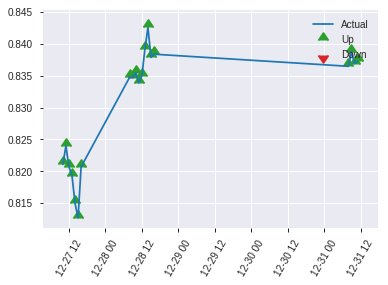


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501763950741861
RMSE: 0.5001763639699363
LogLoss: 0.6934992812886872
Null degrees of freedom: 222
Residual degrees of freedom: 173
Null deviance: 309.68415973716924
Residual deviance: 309.3006794547546
AIC: 409.3006794547546
AUC: 0.564170692431562
pr_auc: 0.5229341476671012
Gini: 0.12834138486312408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048715536517343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    108  0        (0.0/108.0)
Total  2    221  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504872     0.656535  220
max f2                       0.504872     0.826953  220
max f0point5                 0.510226     0.559955  193
max accuracy                 0.517823     0.565022  116
max precision                0.543758     1         0
max recall                   0.504872     1         220
max specificity              0.543758     1         0
max absolute_mcc             0.510226     0.134584  193
max min_per_class_accuracy   0.518053     0.547826  111
max mean_per_class_accuracy  0.517823     0.565862  116

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.540757           1.37654   1.37654            0.666667         0.542037  0.666667                    0.542037            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.536775           1.03241   1.23889            0.5              0.538517  0.6                         0.540629            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.532883           1.03241   1.17989            0.5              0.534591  0.571429                    0.538904            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.532419           1.03241   1.14712            0.5              0.53273   0.555556                    0.537532            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.53191            0.688272  1.03241            0.333333         0.532146  0.5                         0.536185            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.528647           0.750842  0.897746           0.363636         0.5304    0.434783                    0.533418            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.527526           1.12626   0.971678           0.545455         0.528052  0.470588                    0.531682            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.52501            1.50168   1.10123            0.727273         0.526384  0.533333                    0.530387            0.0740741       0.222222                   50.1684   10.1235
    9        0.300448                    0.522036           1.22012   1.14027            0.590909         0.523306  0.552239                    0.528062            0.12037         0.342593                   22.0118   14.0271
    10       0.399103                    0.51979            1.03241   1.11361            0.5              0.520866  0.539326                    0.526283            0.101852        0.444444                   3.24074   11.3608
    11       0.502242                    0.518053           1.07729   1.10615            0.521739         0.518922  0.535714                    0.524772            0.111111        0.555556                   7.72947   10.6151
    12       0.600897                    0.516736           0.938552  1.07863            0.454545         0.517379  0.522388                    0.523558            0.0925926       0.648148                   -6.14478  7.86346
    13       0.699552                    0.515116           1.03241   1.07212            0.5              0.516025  0.519231                    0.522496            0.101852        0.75                       3.24074   7.21154
    14       0.798206                    0.512692           0.938552  1.05561            0.454545         0.513886  0.511236                    0.521431            0.0925926       0.842593                   -6.14478  5.56076
    15       0.896861                    0.509291           0.844697  1.03241            0.409091         0.511082  0.5                         0.520293            0.0833333       0.925926                   -15.5303  3.24074
    16       1                           0.499862           0.718196  1                  0.347826         0.507127  0.484305                    0.518935       

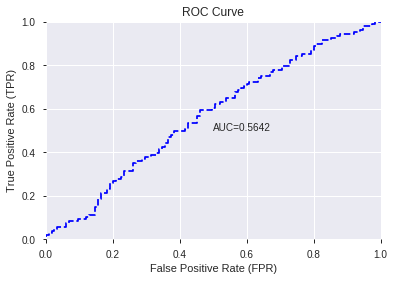

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


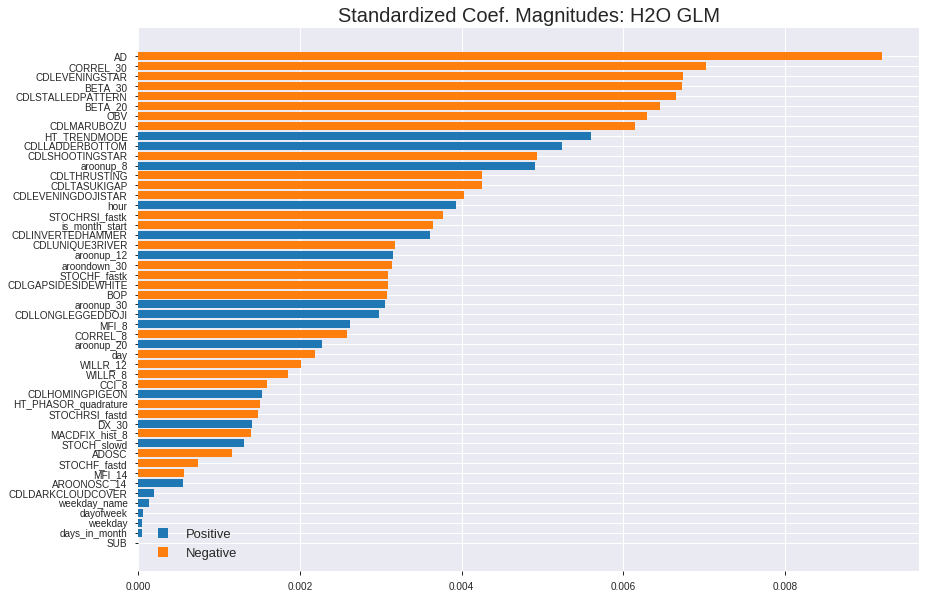

'log_likelihood'
--2019-08-27 16:37:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163740_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163740_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['AD',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'BETA_30',
 'CDLSTALLEDPATTERN',
 'BETA_20',
 'OBV',
 'CDLMARUBOZU',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLSHOOTINGSTAR',
 'aroonup_8',
 'CDLTHRUSTING',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'hour',
 'STOCHRSI_fastk',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLUNIQUE3RIVER',
 'aroonup_12',
 'aroondown_30',
 'STOCHF_fastk',
 'CDLGAPSIDESIDEWHITE',
 'BOP',
 'aroonup_30',
 'CDLLONGLEGGEDDOJI',
 'MFI_8',
 'CORREL_8',
 'aroonup_20',
 'day',
 'WILLR_12',
 'WILLR_8',
 'CCI_8',
 'CDLHOMINGPIGEON',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'DX_30',
 'MACDFIX_hist_8',
 'STOCH_slowd',
 'ADOSC',
 'STOCHF_fastd',
 'MFI_14',
 'AROONOSC_14',
 'CDLDARKCLOUDCOVER',
 'weekday_name',
 'dayofweek',
 'weekday',
 'days_in_month',
 'SUB']

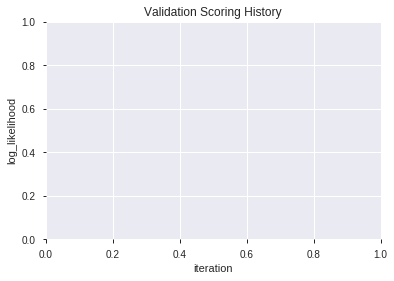

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_163757  0.587359  0.690160              0.482609  0.498413  0.248415
1               XGBoost_1_AutoML_20190827_163757  0.574155  0.697412              0.396095  0.501646  0.251649
2  XGBoost_grid_1_AutoML_20190827_163757_model_6  0.569565  0.700602              0.441385  0.503290  0.253301
3  XGBoost_grid_1_AutoML_20190827_163757_model_1  0.562238  0.706175              0.425121  0.505799  0.255833
4  XGBoost_grid_1_AutoML_20190827_163757_model_5  0.556280  0.724362              0.478261  0.513159  0.263332
5  XGBoost_grid_1_AutoML_20190827_163757_model_7  0.548631  0.704558              0.449799  0.504940  0.254965
6               XGBoost_2_AutoML_20190827_163757  0.547665  0.699303              0.495652  0.502913  0.252922
7  XGBoost_grid_1_AutoML_20190827_163757_model_2  0.542432  0.696027              0.470129  0.501296  0.251298
8  XGBoost_grid_1_AutoML_20190827_163757_model_3  0.534944  0.714051              0.469847  0.509648  0.259742
9  XGBoost_grid_1_AutoML_20190827_163757_model_4  0.531159  0.697614              0.491586  0.502167  0.252172

variable  relative_importance  scaled_importance  percentage
0              CORREL_30           300.678925           1.000000    0.073663
1                     AD           269.710388           0.897005    0.066076
2                BETA_20           248.336777           0.825920    0.060840
3                    BOP           212.819626           0.707797    0.052139
4                    OBV           211.199280           0.702408    0.051742
5   HT_PHASOR_quadrature           203.798752           0.677795    0.049929
6                BETA_30           170.598114           0.567376    0.041795
7                  CCI_8           165.900345           0.551752    0.040644
8                  DX_30           161.466049           0.537005    0.039558
9                  MFI_8           158.396942           0.526798    0.038806
10          STOCHF_fastd           149.077454           0.495803    0.036523
11                   SUB           144.352997           0.480090    0.035365
12        MACDFIX_hist_8           136.288116           0.453268    0.033389
13        STOCHRSI_fastd           130.707108           0.434707    0.032022
14                MFI_14           128.558350           0.427560    0.031496
15           AROONOSC_14           117.958809           0.392308    0.028899
16          STOCHF_fastk           110.947266           0.368989    0.027181
17              CORREL_8           104.978058           0.349137    0.025719
18              WILLR_12           103.383438           0.343833    0.025328
19                 ADOSC            99.749641           0.331748    0.024438
20                   day            84.684258           0.281643    0.020747
21                  hour            80.379738           0.267327    0.019692
22             aroonup_8            78.744385           0.261889    0.019292
23               WILLR_8            77.731964           0.258521    0.019044
24          aroondown_30            73.551193           0.244617    0.018019
25            aroonup_20            66.395935           0.220820    0.016266
26           STOCH_slowd            59.955193           0.199399    0.014688
27            aroonup_30            59.629501           0.198316    0.014609
28            aroonup_12            54.355438           0.180776    0.013317
29          HT_TRENDMODE            39.640884           0.131838    0.009712
30        STOCHRSI_fastk            36.774769           0.122306    0.009009
31             dayofweek            25.153675           0.083656    0.006162
32           CDLMARUBOZU             5.898708           0.019618    0.001445
33          weekday_name             5.607990           0.018651    0.001374
34               weekday             4.296232           0.014288    0.001053
35         days_in_month             0.084885           0.000282    0.000021

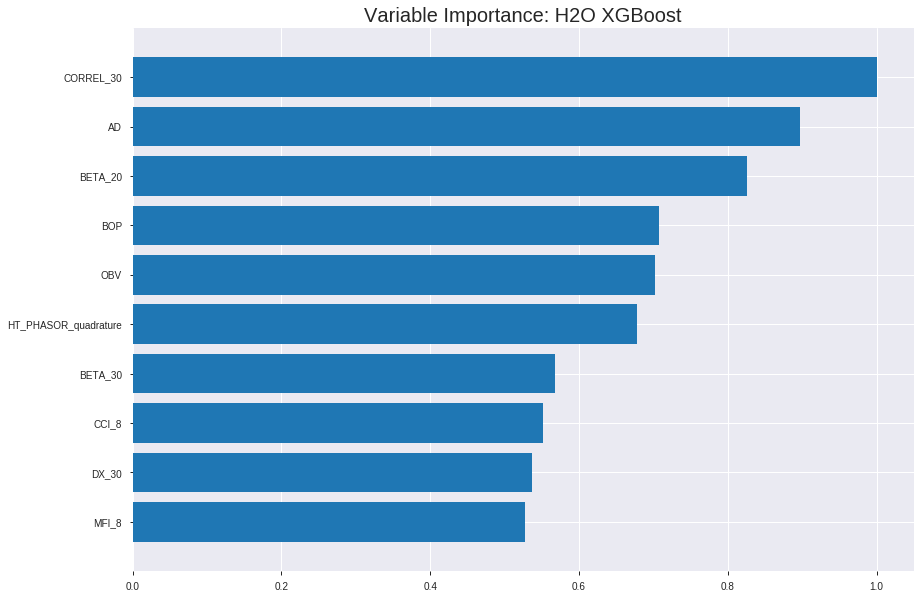

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_163757


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19003525975495236
RMSE: 0.43593033819057875
LogLoss: 0.5703208919166287
Mean Per-Class Error: 0.14882622432598214
AUC: 0.9256418607804009
pr_auc: 0.9251588627183707
Gini: 0.8512837215608018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5044951836268107: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      621  136  0.1797   (136.0/757.0)
1      96   703  0.1202   (96.0/799.0)
Total  717  839  0.1491   (232.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504495     0.858364  207
max f2                       0.465966     0.907153  247
max f0point5                 0.541963     0.861502  164
max accuracy                 0.508062     0.851542  203
max precision                0.81445      1         0
max recall                   0.343472     1         360
max specificity              0.81445      1         0
max absolute_mcc             0.508062     0.702844  203
max min_per_class_accuracy   0.512362     0.847309  198
max mean_per_class_accuracy  0.508062     0.851174  203

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.728419           1.94743    1.94743            1                0.748199  1                           0.748199            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.703062           1.94743    1.94743            1                0.716149  1                           0.732174            0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.685102           1.94743    1.94743            1                0.697012  1                           0.720952            0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.676095           1.82572    1.91652            0.9375           0.681267  0.984127                    0.710874            0.0187735       0.077597                   82.572    91.6523
    5        0.0501285                   0.667332           1.94743    1.92247            1                0.671733  0.987179                    0.703347            0.0187735       0.0963705                  94.7434   92.2467
    6        0.100257                    0.628309           1.94743    1.93495            1                0.646706  0.99359                     0.675026            0.097622        0.193992                   94.7434   93.4951
    7        0.150386                    0.613911           1.84757    1.90582            0.948718         0.620508  0.978632                    0.656854            0.0926158       0.286608                   84.7566   90.5822
    8        0.200514                    0.597897           1.8226     1.88502            0.935897         0.60505   0.967949                    0.643903            0.0913642       0.377972                   82.2599   88.5017
    9        0.300129                    0.567168           1.82179    1.86403            0.935484         0.581293  0.957173                    0.623122            0.181477        0.559449                   82.1793   86.4032
    10       0.400386                    0.543728           1.48554    1.76926            0.762821         0.553856  0.908507                    0.605778            0.148936        0.708385                   48.5543   76.9258
    11       0.5                         0.515792           1.28154    1.67209            0.658065         0.5292    0.858612                    0.590521            0.12766         0.836045                   28.1537   67.209
    12       0.600257                    0.484748           0.886332   1.54085            0.455128         0.500302  0.791221                    0.575453            0.0888611       0.924906                   -11.3668  54.085
    13       0.699871                    0.456009           0.464871   1.3877             0.23871          0.469228  0.71258                     0.560334            0.0463079       0.971214                   -53.5129  38.7703
    14       0.800129                    0.424427           0.21222    1.24041            0.108974         0.441259  0.636948                    0.545413            0.0212766       0.992491                   -78.778   24.0414
    15       0.899743                    0.379105           0.0628205  1.11004            0.0322581        0.403662  0.57                        0.529719            0.00625782      0.998748                   -93.718   11.0038
    16       1                           0.229949           0.0124836  1                  0.00641026       0.337918  0.513496                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24986995201618706
RMSE: 0.49986993509930866
LogLoss: 0.6929083684264996
Mean Per-Class Error: 0.4492725686342147
AUC: 0.5415559117748513
pr_auc: 0.5435869823008177
Gini: 0.08311182354970259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33607131242752075: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    222  0.9955   (222.0/223.0)
1      0    221  0        (0.0/221.0)
Total  1    443  0.5      (222.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336071     0.665663  398
max f2                       0.336071     0.832705  398
max f0point5                 0.37455      0.558717  383
max accuracy                 0.560771     0.551802  102
max precision                0.683572     1         0
max recall                   0.336071     1         398
max specificity              0.683572     1         0
max absolute_mcc             0.560771     0.116707  102
max min_per_class_accuracy   0.516474     0.529412  194
max mean_per_class_accuracy  0.559036     0.550727  105

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.668734           0.80362   0.80362            0.4              0.675311  0.4                         0.675311            0.00904977      0.00904977                 -19.638   -19.638
    2        0.0202703                   0.65121            2.00905   1.33937            1                0.659597  0.666667                    0.668327            0.0180995       0.0271493                  100.905   33.9367
    3        0.0315315                   0.641367           1.20543   1.29153            0.6              0.647567  0.642857                    0.660913            0.0135747       0.040724                   20.543    29.1532
    4        0.0405405                   0.629166           0.502262  1.11614            0.25             0.633929  0.555556                    0.654916            0.00452489      0.0452489                  -49.7738  11.6139
    5        0.0518018                   0.622963           1.60724   1.2229             0.8              0.626975  0.608696                    0.648842            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.602899           1.18717   1.20543            0.590909         0.612272  0.6                         0.630963            0.0588235       0.122172                   18.7166   20.543
    7        0.150901                    0.584335           1.18717   1.19943            0.590909         0.593351  0.597015                    0.618613            0.0588235       0.180995                   18.7166   19.9433
    8        0.20045                     0.571424           1.09585   1.17383            0.545455         0.576669  0.58427                     0.608245            0.0542986       0.235294                   9.58453   17.3827
    9        0.29955                     0.55047            1.05019   1.13292            0.522727         0.560633  0.56391                     0.592493            0.104072        0.339367                   5.01851   13.2923
    10       0.400901                    0.529574           1.02685   1.10611            0.511111         0.539491  0.550562                    0.579094            0.104072        0.443439                   2.68477   10.6106
    11       0.5                         0.514999           0.867544  1.05882            0.431818         0.52261   0.527027                    0.567899            0.0859729       0.529412                   -13.2456  5.88235
    12       0.599099                    0.500357           0.958865  1.04229            0.477273         0.506586  0.518797                    0.557757            0.0950226       0.624434                   -4.11353  4.2289
    13       0.70045                     0.479769           0.669683  0.988375           0.333333         0.491428  0.491961                    0.54816             0.0678733       0.692308                   -33.0317  -1.1625
    14       0.79955                     0.453843           1.14151   1.00735            0.568182         0.465967  0.501408                    0.537972            0.113122        0.80543                    14.1506   0.735453
    15       0.898649                    0.413712           1.09585   1.01711            0.545455         0.435401  0.506266                    0.526661            0.108597        0.914027                   9.58453   1.71129
    16       1                           0.300285           0.848265  1                  0.422222         0.377217  0.497748                    0.511515            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:38:00  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.486504                         0.5                0.693147              0.5               0                    1                  0.502252
    2019-08-27 16:38:00  0.133 sec   5                  0.49148          0.676229            0.770499        0.769021           1.82572          0.311697                         0.500057           0.69326               0.506838          0.50901              0.80362            0.5
    2019-08-27 16:38:00  0.210 sec   10                 0.483898         0.661342            0.810068        0.807311           1.94743          0.272494                         0.500409           0.693966              0.509324          0.526347             1.60724            0.502252
    2019-08-27 16:38:01  0.290 sec   15                 0.477191         0.648284            0.837494        0.837242           1.94743          0.264781                         0.500347           0.693832              0.51394           0.532406             1.20543            0.493243
    2019-08-27 16:38:01  0.375 sec   20                 0.469754         0.63396             0.86316         0.860253           1.94743          0.227506                         0.500145           0.693426              0.521458          0.540652             1.20543            0.495495
    2019-08-27 16:38:01  0.449 sec   25                 0.462074         0.619286            0.88246         0.881329           1.94743          0.196658                         0.500178           0.693452              0.519327          0.535781             1.60724            0.47973
    2019-08-27 16:38:01  0.516 sec   30                 0.456755         0.609207            0.894327        0.892372           1.94743          0.185733                         0.499481           0.692051              0.537143          0.55266              1.60724            0.484234
    2019-08-27 16:38:01  0.589 sec   35                 0.450573         0.597619            0.906982        0.906282           1.94743          0.163882                         0.499934           0.693026              0.539537          0.547495             1.60724            0.5
    2019-08-27 16:38:01  0.681 sec   40                 0.445612         0.588216            0.909537        0.908405           1.94743          0.163882                         0.499817           0.692765              0.539902          0.54897              1.20543            0.495495
    2019-08-27 16:38:01  0.765 sec   45                 0.440561         0.578843            0.917632        0.917953           1.94743          0.156812                         0.499933           0.693027              0.54116           0.540706             1.20543            0.495495
    2019-08-27 16:38:01  0.852 sec   50                 0.43593          0.570321            0.925642        0.925159           1.94743          0.1491                           0.49987            0.692908              0.541556          0.543587             0.80362            0.5

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ----------------------
CORREL_30      300.6789245605469      1.0                    0.07366347547461707
AD             269.71038818359375     0.8970046323592026     0.06607647873641002
BETA_20        248.33677673339844     0.8259201309049233     0.060840147306907344
BOP            212.8196258544922      0.7077969504032774     0.05213878329704059
OBV            211.19927978515625     0.7024079924917639     0.051741813928092066
---            ---                    ---                    ---
dayofweek      25.153675079345703     0.08365626262668296    0.0061624110502987856
CDLMARUBOZU    5.898707866668701      0.01961796250033113    0.0014451272995050996
weekday_name   5.607990264892578      0.018651091934989653   0.0013739042533279387
weekday        4.296232223510742      0.014288438173010766   0.0010525360149281609
days_in_month  0.0848846435546875     0.0002823099213845782  2.0795929970153948e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.6605504587155963)

('auc', 0.5873590982286634)

('logloss', 0.6901601216240327)

('mean_per_class_error', 0.40591787439613525)

('rmse', 0.4984125263170719)

('mse', 0.24841504638976586)

xgboost prediction progress: |████████████████████████████████████████████| 100%


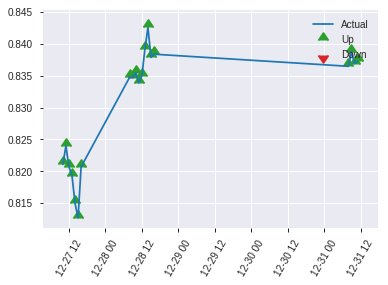


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24841504638976586
RMSE: 0.4984125263170719
LogLoss: 0.6901601216240327
Mean Per-Class Error: 0.40591787439613525
AUC: 0.5873590982286634
pr_auc: 0.5354422532886091
Gini: 0.17471819645732678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4264248013496399: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      0    108  0        (0.0/108.0)
Total  4    219  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426425     0.66055   218
max f2                       0.426425     0.829493  218
max f0point5                 0.513384     0.587838  157
max accuracy                 0.513384     0.587444  157
max precision                0.67118      0.666667  5
max recall                   0.426425     1         218
max specificity              0.695187     0.991304  0
max absolute_mcc             0.513384     0.206925  157
max min_per_class_accuracy   0.550258     0.565217  111
max mean_per_class_accuracy  0.513384     0.594082  157

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 54.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.689375           0.688272  0.688272           0.333333         0.694197  0.333333                    0.694197            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.6732             2.06481   1.23889            1                0.675586  0.6                         0.686753            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.65925            1.03241   1.17989            0.5              0.666541  0.571429                    0.680978            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.652292           1.03241   1.14712            0.5              0.655935  0.555556                    0.675413            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.646214           0.688272  1.03241            0.333333         0.64861   0.5                         0.668712            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.627577           1.12626   1.07729            0.545455         0.637243  0.521739                    0.653662            0.0555556       0.111111                   12.6263   7.72947
    7        0.152466                    0.614221           1.31397   1.15387            0.636364         0.618849  0.558824                    0.642399            0.0648148       0.175926                   31.3973   15.3867
    8        0.201794                    0.602368           1.31397   1.193              0.636364         0.60787   0.577778                    0.633959            0.0648148       0.240741                   31.3973   19.3004
    9        0.300448                    0.582452           1.03241   1.14027            0.5              0.590991  0.552239                    0.61985             0.101852        0.342593                   3.24074   14.0271
    10       0.399103                    0.568755           1.03241   1.11361            0.5              0.57566   0.539326                    0.608927            0.101852        0.444444                   3.24074   11.3608
    11       0.502242                    0.550258           1.25684   1.14302            0.608696         0.55948   0.553571                    0.598772            0.12963         0.574074                   25.6844   14.3022
    12       0.600897                    0.530432           1.03241   1.12486            0.5              0.540844  0.544776                    0.589262            0.101852        0.675926                   3.24074   12.4862
    13       0.699552                    0.516202           1.12626   1.12506            0.545455         0.522904  0.544872                    0.579904            0.111111        0.787037                   12.6263   12.5059
    14       0.798206                    0.496978           0.750842  1.07881            0.363636         0.506386  0.522472                    0.570817            0.0740741       0.861111                   -24.9158  7.88077
    15       0.896861                    0.470929           0.656987  1.03241            0.318182         0.484806  0.5                         0.561356            0.0648148       0.925926                   -34.3013  3.24074
    16       1                           0.365583           0.718196  1                  0.347826         0.444349  0.484305                    0.549288        

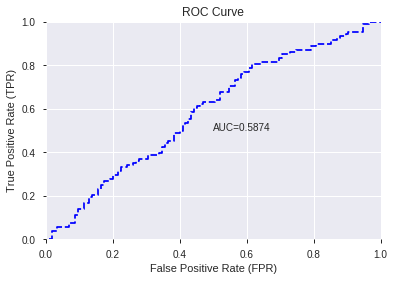

This function is available for GLM models only


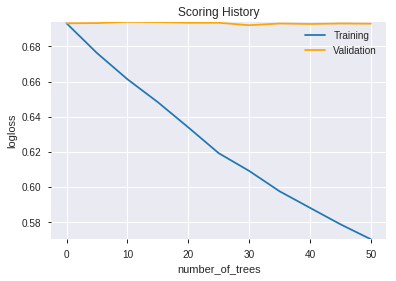

--2019-08-27 16:38:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_163757',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_163757',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_a105',
   'type

['CORREL_30',
 'AD',
 'BETA_20',
 'BOP',
 'OBV',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'CCI_8',
 'DX_30',
 'MFI_8',
 'STOCHF_fastd',
 'SUB',
 'MACDFIX_hist_8',
 'STOCHRSI_fastd',
 'MFI_14',
 'AROONOSC_14',
 'STOCHF_fastk',
 'CORREL_8',
 'WILLR_12',
 'ADOSC',
 'day',
 'hour',
 'aroonup_8',
 'WILLR_8',
 'aroondown_30',
 'aroonup_20',
 'STOCH_slowd',
 'aroonup_30',
 'aroonup_12',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'dayofweek',
 'CDLMARUBOZU',
 'weekday_name',
 'weekday',
 'days_in_month']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_163828_model_1  0.578422  0.695637              0.457931  0.501239  0.251241

variable  relative_importance  scaled_importance  percentage
0                           AD             0.008672           1.000000    0.017075
1                    CORREL_30             0.006635           0.765114    0.013064
2               CDLEVENINGSTAR             0.006632           0.764793    0.013058
3            CDLSTALLEDPATTERN             0.006540           0.754193    0.012878
4                      BETA_30             0.006210           0.716138    0.012228
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_14_1_2             0.000000           0.000000    0.000000
1033  BBANDS_middleband_14_1_3             0.000000           0.000000    0.000000
1034  BBANDS_middleband_14_1_4             0.000000           0.000000    0.000000
1035  BBANDS_middleband_14_1_5             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000

[1037 rows x 4 columns]

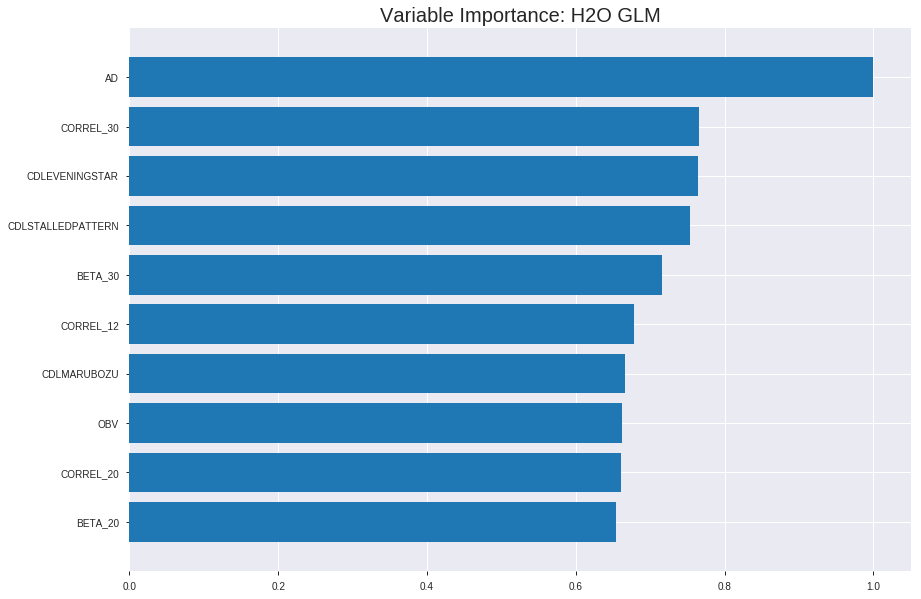

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163828_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24693796272670532
RMSE: 0.49692852879131955
LogLoss: 0.6870088256200565
Null degrees of freedom: 1555
Residual degrees of freedom: 527
Null deviance: 2155.940212106897
Residual deviance: 2137.971465329616
AIC: 4195.971465329616
AUC: 0.5992199628663968
pr_auc: 0.6113966890180089
Gini: 0.19843992573279357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4782635029850976: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   742   0.9802   (742.0/757.0)
1      4    795   0.005    (4.0/799.0)
Total  19   1537  0.4794   (746.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478264     0.680651  383
max f2                       0.471342     0.840885  393
max f0point5                 0.498329     0.592929  302
max accuracy                 0.513863     0.573907  204
max precision                0.585764     1         0
max recall                   0.465573     1         398
max specificity              0.585764     1         0
max absolute_mcc             0.520796     0.151208  159
max min_per_class_accuracy   0.512035     0.568032  216
max mean_per_class_accuracy  0.513863     0.574933  204

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.558459           1.58229   1.58229            0.8125           0.565981  0.8125                      0.565981            0.0162703       0.0162703                  58.229    58.229
    2        0.0205656                   0.551784           1.58229   1.58229            0.8125           0.555243  0.8125                      0.560612            0.0162703       0.0325407                  58.229    58.229
    3        0.0302057                   0.548635           1.68778   1.61596            0.866667         0.550217  0.829787                    0.557294            0.0162703       0.048811                   68.7776   61.5956
    4        0.0404884                   0.546248           1.33886   1.54558            0.6875           0.547473  0.793651                    0.5548              0.0137672       0.0625782                  33.8861   54.5583
    5        0.0501285                   0.544709           1.03863   1.44809            0.533333         0.545429  0.74359                     0.552998            0.0100125       0.0725907                  3.86316   44.8092
    6        0.100257                    0.536878           1.24836   1.34822            0.641026         0.540103  0.692308                    0.546551            0.0625782       0.135169                   24.8355   34.8224
    7        0.150386                    0.531843           1.22339   1.30661            0.628205         0.534335  0.67094                     0.542479            0.0613267       0.196496                   22.3388   30.6612
    8        0.200514                    0.528059           1.12352   1.26084            0.576923         0.529991  0.647436                    0.539357            0.0563204       0.252816                   12.352    26.0839
    9        0.300129                    0.521888           1.1182    1.2135             0.574194         0.524466  0.623126                    0.534414            0.111389        0.364205                   11.8204   21.3498
    10       0.400386                    0.517073           1.02365   1.16596            0.525641         0.519431  0.598716                    0.530662            0.102628        0.466834                   2.36514   16.596
    11       0.5                         0.512174           1.00513   1.13392            0.516129         0.514526  0.582262                    0.527448            0.100125        0.566959                   0.512738  13.3917
    12       0.600257                    0.507864           0.873849  1.09048            0.448718         0.510075  0.559957                    0.524546            0.0876095       0.654568                   -12.6151  9.04798
    13       0.699871                    0.503635           0.967435  1.07297            0.496774         0.505818  0.550964                    0.52188             0.0963705       0.750939                   -3.25649  7.29666
    14       0.800129                    0.498614           1.03613   1.06835            0.532051         0.500942  0.548594                    0.519257            0.10388         0.854819                   3.61349   6.83515
    15       0.899743                    0.491935           0.703589  1.02797            0.36129          0.495352  0.527857                    0.51661             0.0700876       0.924906                   -29.6411  2.79671
    16       1                           0.457779           0.749013  1                  0.384615         0.48555   0.513496                    0.513496            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24981842175325378
RMSE: 0.49981838877061513
LogLoss: 0.6927809569455985
Null degrees of freedom: 443
Residual degrees of freedom: -585
Null deviance: 615.9463007458467
Residual deviance: 615.1894897676915
AIC: 2673.1894897676916
AUC: 0.5193981697542763
pr_auc: 0.5200068189413309
Gini: 0.03879633950855266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46710467031731173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467105     0.664662  399
max f2                       0.467105     0.832078  399
max f0point5                 0.491963     0.560976  362
max accuracy                 0.535155     0.533784  40
max precision                0.57996      1         0
max recall                   0.467105     1         399
max specificity              0.57996      1         0
max absolute_mcc             0.535155     0.107024  40
max min_per_class_accuracy   0.51477      0.506726  200
max mean_per_class_accuracy  0.535155     0.531979  40

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.552673           1.20543   1.20543            0.6              0.565597  0.6                         0.565597            0.0135747       0.0135747                  20.543    20.543
    2        0.0202703                   0.54656            1.50679   1.33937            0.75             0.549799  0.666667                    0.558576            0.0135747       0.0271493                  50.6787   33.9367
    3        0.0315315                   0.543271           0.40181   1.00452            0.2              0.544976  0.5                         0.553719            0.00452489      0.0316742                  -59.819   0.452489
    4        0.0405405                   0.542108           1.50679   1.11614            0.75             0.54298   0.555556                    0.551332            0.0135747       0.0452489                  50.6787   11.6139
    5        0.0518018                   0.540916           1.60724   1.2229             0.8              0.541442  0.608696                    0.549182            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.534856           1.36981   1.29472            0.681818         0.538141  0.644444                    0.543784            0.0678733       0.131222                   36.9807   29.4721
    7        0.150901                    0.531166           0.639243  1.07949            0.318182         0.53256   0.537313                    0.540099            0.0316742       0.162896                   -36.0757  7.94894
    8        0.20045                     0.528699           0.913204  1.03839            0.454545         0.529846  0.516854                    0.537564            0.0452489       0.208145                   -8.67956  3.83853
    9        0.29955                     0.522813           1.00452   1.02718            0.5              0.525149  0.511278                    0.533457            0.0995475       0.307692                   0.452489  2.71833
    10       0.400901                    0.517971           1.02685   1.0271             0.511111         0.520346  0.511236                    0.530142            0.104072        0.411765                   2.68477   2.70985
    11       0.5                         0.514718           0.958865  1.01357            0.477273         0.516441  0.504505                    0.527427            0.0950226       0.506787                   -4.11353  1.35747
    12       0.599099                    0.511451           0.958865  1.00452            0.477273         0.513058  0.5                         0.52505             0.0950226       0.60181                    -4.11353  0.452489
    13       0.70045                     0.507517           1.02685   1.00775            0.511111         0.50963   0.501608                    0.522819            0.104072        0.705882                   2.68477   0.775487
    14       0.79955                     0.502289           1.18717   1.02999            0.590909         0.505103  0.512676                    0.520623            0.117647        0.823529                   18.7166   2.99917
    15       0.898649                    0.493126           0.867544  1.01208            0.431818         0.498019  0.503759                    0.51813             0.0859729       0.909502                   -13.2456  1.20777
    16       1                           0.467105           0.892911  1                  0.444444         0.485473  0.497748                    0.514821         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:38:30  0.000 sec   2            3.9       1029          1.37402           1.38556
    2019-08-27 16:38:32  1.892 sec   4            2.8       1029          1.37085           1.38581
    2019-08-27 16:38:34  3.802 sec   6            2.1       1031          1.36702           1.38627
    2019-08-27 16:38:36  5.735 sec   8            1.5       1037          1.36249           1.38713
    2019-08-27 16:38:38  7.801 sec   10           1.1       1037          1.35727           1.38853
    2019-08-27 16:38:40  9.693 sec   12           0.79      1038          1.35143           1.39067

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.662379421221865)

('auc', 0.5784219001610306)

('logloss', 0.6956365067634369)

('mean_per_class_error', 0.39851046698872783)

('rmse', 0.5012392508149394)

('mse', 0.2512407865575217)

glm prediction progress: |████████████████████████████████████████████████| 100%


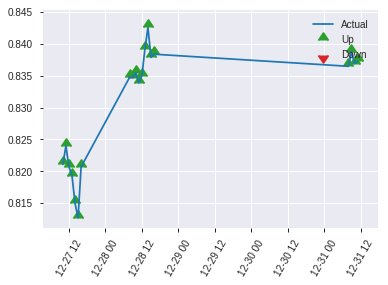


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2512407865575217
RMSE: 0.5012392508149394
LogLoss: 0.6956365067634369
Null degrees of freedom: 222
Residual degrees of freedom: -806
Null deviance: 309.68415973716924
Residual deviance: 310.25388201649287
AIC: 2368.2538820164928
AUC: 0.5784219001610306
pr_auc: 0.523991395903372
Gini: 0.15684380032206113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5204949809735862: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   100  0.8696   (100.0/115.0)
1      5    103  0.0463   (5.0/108.0)
Total  20   203  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520495     0.662379  202
max f2                       0.514708     0.825688  221
max f0point5                 0.535903     0.589789  114
max accuracy                 0.535903     0.600897  114
max precision                0.56437      0.714286  6
max recall                   0.514708     1         221
max specificity              0.5714       0.991304  0
max absolute_mcc             0.535903     0.202979  114
max min_per_class_accuracy   0.536716     0.592593  109
max mean_per_class_accuracy  0.535903     0.60149   114

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 53.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.569392           0.688272  0.688272           0.333333         0.57045   0.333333                    0.57045             0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.566774           2.06481   1.23889            1                0.567989  0.6                         0.569466            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.564212           2.06481   1.47487            1                0.565184  0.714286                    0.568242            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.562739           1.03241   1.37654            0.5              0.563657  0.666667                    0.567223            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.561673           0         1.03241            0                0.562373  0.5                         0.566011            0               0.0555556                  -100      3.24074
    6        0.103139                    0.556193           0.750842  0.897746           0.363636         0.558975  0.434783                    0.562646            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.552449           1.12626   0.971678           0.545455         0.554001  0.470588                    0.559849            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.549319           1.50168   1.10123            0.727273         0.550648  0.533333                    0.5576              0.0740741       0.222222                   50.1684   10.1235
    9        0.300448                    0.543565           0.938552  1.04782            0.454545         0.546873  0.507463                    0.554078            0.0925926       0.314815                   -6.14478  4.78165
    10       0.399103                    0.538714           1.59554   1.18321            0.772727         0.541307  0.573034                    0.550921            0.157407        0.472222                   59.5539   18.3208
    11       0.502242                    0.536307           1.25684   1.19833            0.608696         0.537475  0.580357                    0.54816             0.12963         0.601852                   25.6844   19.833
    12       0.600897                    0.533161           0.750842  1.12486            0.363636         0.534783  0.544776                    0.545963            0.0740741       0.675926                   -24.9158  12.4862
    13       0.699552                    0.52981            0.656987  1.05888            0.318182         0.531677  0.512821                    0.543949            0.0648148       0.740741                   -34.3013  5.88794
    14       0.798206                    0.525713           1.03241   1.05561            0.5              0.528077  0.511236                    0.541987            0.101852        0.842593                   3.24074   5.56076
    15       0.896861                    0.520559           1.03241   1.05306            0.5              0.522959  0.51                        0.539894            0.101852        0.944444                   3.24074   5.30556
    16       1                           0.500034           0.538647  1                  0.26087          0.517442  0.484305                    0.537578       

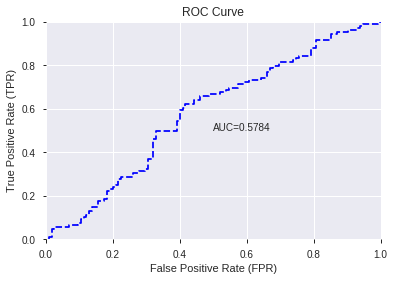

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


'log_likelihood'
--2019-08-27 16:39:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

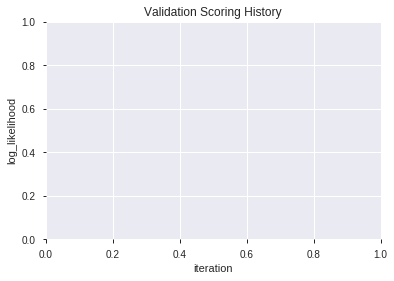

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_163916_model_5  0.588164  0.687032              0.482609  0.496798  0.246808
1  XGBoost_grid_1_AutoML_20190827_163916_model_3  0.572705  0.686515              0.461151  0.496672  0.246683
2  XGBoost_grid_1_AutoML_20190827_163916_model_6  0.553623  0.691926              0.478824  0.499237  0.249237
3  XGBoost_grid_1_AutoML_20190827_163916_model_1  0.545692  0.693211              0.452174  0.499942  0.249942
4               XGBoost_3_AutoML_20190827_163916  0.544605  0.690127              0.475040  0.498549  0.248551
5  XGBoost_grid_1_AutoML_20190827_163916_model_4  0.536111  0.695404              0.475040  0.501021  0.251022
6  XGBoost_grid_1_AutoML_20190827_163916_model_2  0.522625  0.696652              0.449235  0.501672  0.251675
7  XGBoost_grid_1_AutoML_20190827_163916_model_7  0.507729  0.716003              0.487520  0.510503  0.260614
8               XGBoost_1_AutoML_20190827_163916  0.500161  0.706774              0.478543  0.506694  0.256739
9               XGBoost_2_AutoML_20190827_163916  0.495813  0.711289              0.495652  0.508619  0.258694

variable  relative_importance  scaled_importance  percentage
0                     Volume           451.518982           1.000000    0.021026
1                        BOP           358.503296           0.793994    0.016695
2                       Open           340.492889           0.754105    0.015856
3                       High           230.243698           0.509931    0.010722
4                      CCI_8           223.402054           0.494779    0.010403
..                       ...                  ...                ...         ...
650                  MA_14_0             1.189709           0.002635    0.000055
651  BBANDS_lowerband_14_1_4             1.188967           0.002633    0.000055
652   BBANDS_upperband_8_5_4             1.130653           0.002504    0.000053
653  BBANDS_lowerband_12_3_4             1.089744           0.002414    0.000051
654  BBANDS_middleband_8_5_2             0.228620           0.000506    0.000011

[655 rows x 4 columns]

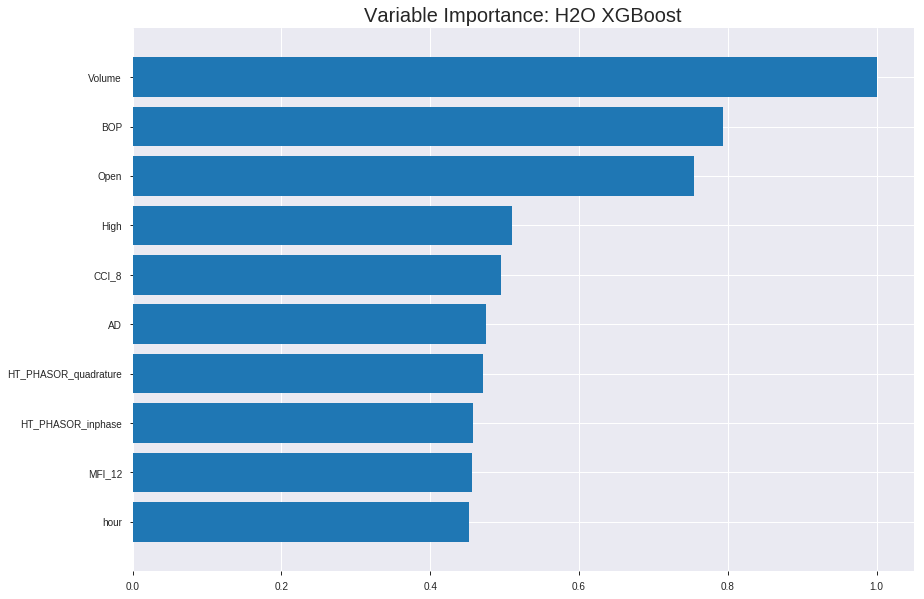

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_163916_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.040673970103633286
RMSE: 0.20167788699714526
LogLoss: 0.21517744454995225
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9974968710888611
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5376829206943512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      757  0    0        (0.0/757.0)
1      0    799  0        (0.0/799.0)
Total  757  799  0        (0.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.537683     1        193
max f2                       0.537683     1        193
max f0point5                 0.537683     1        193
max accuracy                 0.537683     1        193
max precision                0.930153     1        0
max recall                   0.537683     1        193
max specificity              0.930153     1        0
max absolute_mcc             0.537683     1        193
max min_per_class_accuracy   0.537683     1        193
max mean_per_class_accuracy  0.537683     1        193

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.908572           1.94743   1.94743            1                0.917728  1                           0.917728            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.900263           1.94743   1.94743            1                0.903172  1                           0.91045             0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.893446           1.94743   1.94743            1                0.896018  1                           0.905844            0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.888351           1.94743   1.94743            1                0.890844  1                           0.902034            0.020025        0.0788486                  94.7434   94.7434
    5        0.0501285                   0.885045           1.94743   1.94743            1                0.886856  1                           0.899115            0.0187735       0.097622                   94.7434   94.7434
    6        0.100257                    0.868476           1.94743   1.94743            1                0.876401  1                           0.887758            0.097622        0.195244                   94.7434   94.7434
    7        0.150386                    0.853191           1.94743   1.94743            1                0.860396  1                           0.878638            0.097622        0.292866                   94.7434   94.7434
    8        0.200514                    0.836774           1.94743   1.94743            1                0.845012  1                           0.870231            0.097622        0.390488                   94.7434   94.7434
    9        0.300129                    0.807821           1.94743   1.94743            1                0.822466  1                           0.854378            0.193992        0.584481                   94.7434   94.7434
    10       0.400386                    0.767653           1.94743   1.94743            1                0.787971  1                           0.83775             0.195244        0.779725                   94.7434   94.7434
    11       0.5                         0.676605           1.94743   1.94743            1                0.73102   1                           0.816486            0.193992        0.973717                   94.7434   94.7434
    12       0.600257                    0.251134           0.262155  1.66595            0.134615         0.349004  0.85546                     0.738406            0.0262829       1                          -73.7845  66.5953
    13       0.699871                    0.206549           0         1.42883            0                0.225599  0.733701                    0.665416            0               1                          -100      42.8834
    14       0.800129                    0.169637           0         1.2498             0                0.188517  0.641767                    0.60566             0               1                          -100      24.9799
    15       0.899743                    0.133601           0         1.11143            0                0.152866  0.570714                    0.55553             0               1                          -100      11.1429
    16       1                           0.0744449          0         1                  0                0.111422  0.513496                    0.511005         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27064228352227687
RMSE: 0.5202329127633861
LogLoss: 0.7393166308555121
Mean Per-Class Error: 0.4732057707525922
AUC: 0.4941156179615689
pr_auc: 0.4888087985708035
Gini: -0.011768764076862226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15494941174983978: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.154949     0.664662   399
max f2                       0.154949     0.832078   399
max f0point5                 0.318025     0.553466   367
max accuracy                 0.557363     0.527027   179
max precision                0.786707     0.8        4
max recall                   0.154949     1          399
max specificity              0.834821     0.995516   0
max absolute_mcc             0.684637     0.0810145  49
max min_per_class_accuracy   0.541606     0.511312   197
max mean_per_class_accuracy  0.557363     0.526794   179

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 52.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.780794           1.60724   1.60724            0.8              0.814151  0.8                         0.814151            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.754778           0.502262  1.11614            0.25             0.766818  0.555556                    0.793114            0.00452489      0.0226244                  -49.7738  11.6139
    3        0.0315315                   0.743358           0.80362   1.00452            0.4              0.748383  0.5                         0.777139            0.00904977      0.0316742                  -19.638   0.452489
    4        0.0405405                   0.737776           0.502262  0.892911           0.25             0.740395  0.444444                    0.768973            0.00452489      0.0361991                  -49.7738  -10.7089
    5        0.0518018                   0.727045           0.40181   0.78615            0.2              0.730726  0.391304                    0.760659            0.00452489      0.040724                   -59.819   -21.385
    6        0.101351                    0.699628           1.00452   0.892911           0.5              0.711027  0.444444                    0.736394            0.0497738       0.0904977                  0.452489  -10.7089
    7        0.150901                    0.671137           0.913204  0.899575           0.454545         0.683276  0.447761                    0.718952            0.0452489       0.135747                   -8.67956  -10.0425
    8        0.20045                     0.646715           1.00452   0.925517           0.5              0.656052  0.460674                    0.703404            0.0497738       0.18552                    0.452489  -7.44827
    9        0.29955                     0.604813           1.14151   0.996972           0.568182         0.627269  0.496241                    0.678217            0.113122        0.298643                   14.1506   -0.302793
    10       0.400901                    0.569389           1.11614   1.0271             0.555556         0.586521  0.511236                    0.655035            0.113122        0.411765                   11.6139   2.70985
    11       0.5                         0.539102           1.00452   1.02262            0.5              0.55589   0.509009                    0.635385            0.0995475       0.511312                   0.452489  2.26244
    12       0.599099                    0.500333           0.958865  1.01208            0.477273         0.519379  0.503759                    0.616196            0.0950226       0.606335                   -4.11353  1.20777
    13       0.70045                     0.465603           0.848265  0.988375           0.422222         0.480962  0.491961                    0.596628            0.0859729       0.692308                   -15.1735  -1.1625
    14       0.79955                     0.416236           1.05019   0.996036           0.522727         0.439497  0.495775                    0.577153            0.104072        0.79638                    5.01851   -0.396406
    15       0.898649                    0.3495             1.00452   0.996972           0.5              0.384418  0.496241                    0.555899            0.0995475       0.895928                   0.452489  -0.302793
    16       1                           0.154949           1.02685   1                  0.511111         0.284669  0.497748                    0.52840


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:39:50  15.998 sec  0                  0.5              0.693147            0.5             0                  1                0.486504                         0.5                0.693147              0.5               0                    1                  0.502252
    2019-08-27 16:39:51  17.579 sec  5                  0.448241         0.594187            0.968248        0.967719           1.94743          0.0835476                        0.501876           0.696929              0.502161          0.500393             0.40181            0.495495
    2019-08-27 16:39:52  18.282 sec  10                 0.404355         0.516454            0.993183        0.990118           1.94743          0.0392031                        0.505126           0.703625              0.486375          0.489016             1.20543            0.493243
    2019-08-27 16:39:53  19.044 sec  15                 0.363147         0.4481              0.998841        0.997647           1.94743          0.0128535                        0.508169           0.710141              0.483879          0.481646             1.20543            0.502252
    2019-08-27 16:39:53  19.751 sec  20                 0.331824         0.398611            0.99972         0.998485           1.94743          0.00771208                       0.510262           0.714863              0.487896          0.478161             0.80362            0.502252
    2019-08-27 16:39:54  20.450 sec  25                 0.305125         0.358199            0.999913        0.998667           1.94743          0.00514139                       0.504              0.701997              0.525455          0.505728             0.40181            0.502252
    2019-08-27 16:39:55  21.263 sec  30                 0.420294         0.534253            0.834207        0.894868           1.94743          0.278278                         0.507579           0.709803              0.49373           0.486333             0.80362            0.502252
    2019-08-27 16:39:56  21.982 sec  35                 0.41466          0.521769            0.834226        0.894902           1.94743          0.278278                         0.505252           0.704777              0.524887          0.513166             1.20543            0.502252
    2019-08-27 16:39:56  22.731 sec  40                 0.407727         0.506008            0.834803        0.896664           1.94743          0.274422                         0.508947           0.713079              0.488982          0.482476             0.80362            0.502252
    2019-08-27 16:39:57  23.472 sec  45                 0.219126         0.237512            0.999998        0.998747           1.94743          0.000642674                      0.517809           0.733368              0.496753          0.493069             1.60724            0.502252
    2019-08-27 16:39:58  24.292 sec  50                 0.201678         0.215177            1               0.997497           1.94743          0                                0.520233           0.739317              0.494116          0.488809             1.60724            0.502252

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   451.51898193359375     1.0                    0.021026157194278458
BOP                      358.5032958984375      0.7939938524027849     0.016694639551911684
Open                     340.4928894042969      0.7541053710436789     0.015855938072614074
High                     230.2436981201172      0.5099313812547084     0.010721897380557038
CCI_8                    223.4020538330078      0.4947788748023538     0.010403298398002511
---                      ---                    ---                    ---
MA_14_0                  1.1897088289260864     0.002634903241124557   5.540188973959873e-05
BBANDS_lowerband_14_1_4  1.1889667510986328     0.0026332597269930454  5.536733295311855e-05
BBANDS_upperband_8_5_4   1.130652666091919      0.002504108822291346   5.2651785729077336e-05
BBANDS_lowerband_12_3_4  1.0897443294525146     0.00241350723459238    5.074678250406768e-05
BBANDS_middleband_8_5_2  0.22862038016319275    0.000506336143796534   1.0646303352610705e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6605504587155963)

('auc', 0.5881642512077294)

('logloss', 0.687031719045957)

('mean_per_class_error', 0.4035829307568438)

('rmse', 0.4967975021317255)

('mse', 0.24680775812432182)

xgboost prediction progress: |████████████████████████████████████████████| 100%


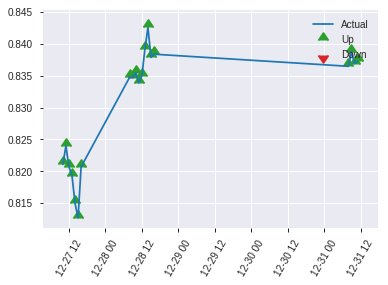


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24680775812432182
RMSE: 0.4967975021317255
LogLoss: 0.687031719045957
Mean Per-Class Error: 0.4035829307568438
AUC: 0.5881642512077294
pr_auc: 0.5606437280349916
Gini: 0.17632850241545883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28595954179763794: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      0    108  0        (0.0/108.0)
Total  4    219  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28596      0.66055   218
max f2                       0.28596      0.829493  218
max f0point5                 0.516039     0.578231  119
max accuracy                 0.578847     0.600897  76
max precision                0.741828     0.8       4
max recall                   0.28596      1         218
max specificity              0.772146     0.991304  0
max absolute_mcc             0.578847     0.202093  76
max min_per_class_accuracy   0.527931     0.556522  111
max mean_per_class_accuracy  0.576192     0.596417  78

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.749793           1.37654   1.37654            0.666667         0.76302   0.666667                    0.76302             0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.737391           2.06481   1.65185            1                0.7444    0.8                         0.755572            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.726901           0         1.17989            0                0.729719  0.571429                    0.748186            0               0.037037                   -100      17.9894
    4        0.0403587                   0.722584           2.06481   1.37654            1                0.725585  0.666667                    0.743163            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.714284           1.37654   1.37654            0.666667         0.71803   0.666667                    0.73688             0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.681473           1.31397   1.34662            0.636364         0.698196  0.652174                    0.718379            0.0648148       0.138889                   31.3973   34.6618
    7        0.152466                    0.656856           1.12626   1.27533            0.545455         0.664986  0.617647                    0.701105            0.0555556       0.194444                   12.6263   27.5327
    8        0.201794                    0.631229           0.938552  1.193              0.454545         0.641844  0.577778                    0.686619            0.0462963       0.240741                   -6.14478  19.3004
    9        0.300448                    0.594217           1.31397   1.23273            0.636364         0.609529  0.597015                    0.661306            0.12963         0.37037                    31.3973   23.2725
    10       0.399103                    0.564072           0.938552  1.16001            0.454545         0.57714   0.561798                    0.640501            0.0925926       0.462963                   -6.14478  16.0008
    11       0.502242                    0.527931           0.98752   1.12459            0.478261         0.544506  0.544643                    0.620787            0.101852        0.564815                   -1.24799  12.4587
    12       0.600897                    0.492905           0.844697  1.07863            0.409091         0.507854  0.522388                    0.602246            0.0833333       0.648148                   -15.5303  7.86346
    13       0.699552                    0.451684           1.12626   1.08535            0.545455         0.473511  0.525641                    0.584091            0.111111        0.759259                   12.6263   8.53514
    14       0.798206                    0.408608           0.656987  1.03241            0.318182         0.432215  0.5                         0.56532             0.0648148       0.824074                   -34.3013  3.24074
    15       0.896861                    0.345473           1.12626   1.04273            0.545455         0.383066  0.505                       0.545272            0.111111        0.935185                   12.6263   4.27315
    16       1                           0.233116           0.628422  1                  0.304348         0.308451  0.484305                    0.520847         

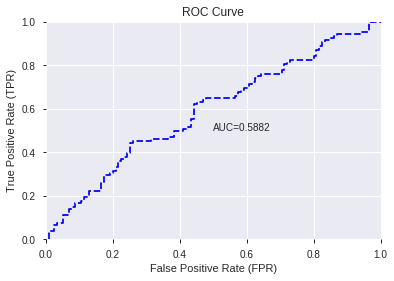

This function is available for GLM models only


--2019-08-27 16:40:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_163916_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_163916_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_164020_model_7  0.569565  0.866762              0.424557  0.550965  0.303563
1  DeepLearning_grid_1_AutoML_20190827_164020_model_8  0.550242  0.691284              0.456522  0.499070  0.249071
2  DeepLearning_grid_1_AutoML_20190827_164020_model_4  0.549034  0.980233              0.491304  0.570695  0.325693
3  DeepLearning_grid_1_AutoML_20190827_164020_model_5  0.547021  0.703876              0.495652  0.504619  0.254640
4  DeepLearning_grid_1_AutoML_20190827_164020_model_9  0.545572  0.690934              0.470129  0.498893  0.248894
5  DeepLearning_grid_1_AutoML_20190827_164020_model_1  0.533977  2.372191              0.473913  0.643652  0.414288
6  DeepLearning_grid_1_AutoML_20190827_164020_model_3  0.524960  1.327056              0.478543  0.602487  0.362991
7               DeepLearning_1_AutoML_20190827_164020  0.521014  0.765369              0.495652  0.526114  0.276796
8  DeepLearning_grid_1_AutoML_20190827_164020_model_6  0.518035  0.724360              0.491304  0.514056  0.264253
9  DeepLearning_grid_1_AutoML_20190827_164020_model_2  0.515539  1.691166              0.457367  0.629427  0.396178

variable  relative_importance  scaled_importance  percentage
0                     AD             1.000000           1.000000    0.021547
1      CDLLONGLEGGEDDOJI             0.979407           0.979407    0.021104
2    CDLGAPSIDESIDEWHITE             0.978362           0.978362    0.021081
3              aroonup_8             0.970268           0.970268    0.020907
4                BETA_20             0.962755           0.962755    0.020745
5              CORREL_30             0.956478           0.956478    0.020609
6      CDLINVERTEDHAMMER             0.953446           0.953446    0.020544
7                    day             0.951549           0.951549    0.020503
8      CDLSTALLEDPATTERN             0.950798           0.950798    0.020487
9            CDLMARUBOZU             0.949706           0.949706    0.020464
10         days_in_month             0.949126           0.949126    0.020451
11                MFI_14             0.947679           0.947679    0.020420
12          CDLTHRUSTING             0.947400           0.947400    0.020414
13                  hour             0.946011           0.946011    0.020384
14        CDLEVENINGSTAR             0.944765           0.944765    0.020357
15       CDLLADDERBOTTOM             0.943744           0.943744    0.020335
16            aroonup_20             0.943181           0.943181    0.020323
17        is_month_start             0.942380           0.942380    0.020306
18       CDLUNIQUE3RIVER             0.941579           0.941579    0.020288
19               BETA_30             0.938564           0.938564    0.020223
20                 DX_30             0.936663           0.936663    0.020182
21          HT_TRENDMODE             0.935874           0.935874    0.020165
22  HT_PHASOR_quadrature             0.932013           0.932013    0.020082
23     CDLDARKCLOUDCOVER             0.931359           0.931359    0.020068
24            aroonup_30             0.928099           0.928099    0.019998
25                   SUB             0.926612           0.926612    0.019966
26    CDLEVENINGDOJISTAR             0.926441           0.926441    0.019962
27                 ADOSC             0.924831           0.924831    0.019928
28           STOCH_slowd             0.923348           0.923348    0.019896
29            aroonup_12             0.919752           0.919752    0.019818
30                 MFI_8             0.917088           0.917088    0.019761
31        STOCHRSI_fastk             0.914907           0.914907    0.019714
32           AROONOSC_14             0.914150           0.914150    0.019697
33               weekday             0.913753           0.913753    0.019689
34       CDLHOMINGPIGEON             0.912378           0.912378    0.019659
35                 CCI_8             0.911965           0.911965    0.019650
36          aroondown_30             0.911914           0.911914    0.019649
37        MACDFIX_hist_8             0.911757           0.911757    0.019646
38                   BOP             0.910891           0.910891    0.019627
39       CDLSHOOTINGSTAR             0.909542           0.909542    0.019598
40             dayofweek             0.905001           0.905001    0.019500
41          STOCHF_fastd             0.904538           0.904538    0.019490
42              WILLR_12             0.901193           0.901193    0.019418
43               WILLR_8             0.900556           0.900556    0.019404
44          CDLTASUKIGAP             0.897754           0.897754    0.019344
45          STOCHF_fastk             0.892169           0.892169    0.019224
46                   OBV             0.882060           0.882060    0.019006
47        STOCHRSI_fastd             0.873726           0.873726    0.018826
48              CORREL_8             0.872058           0.872058    0.018790
49          weekday_name             0.870085           0.870085    0.018748

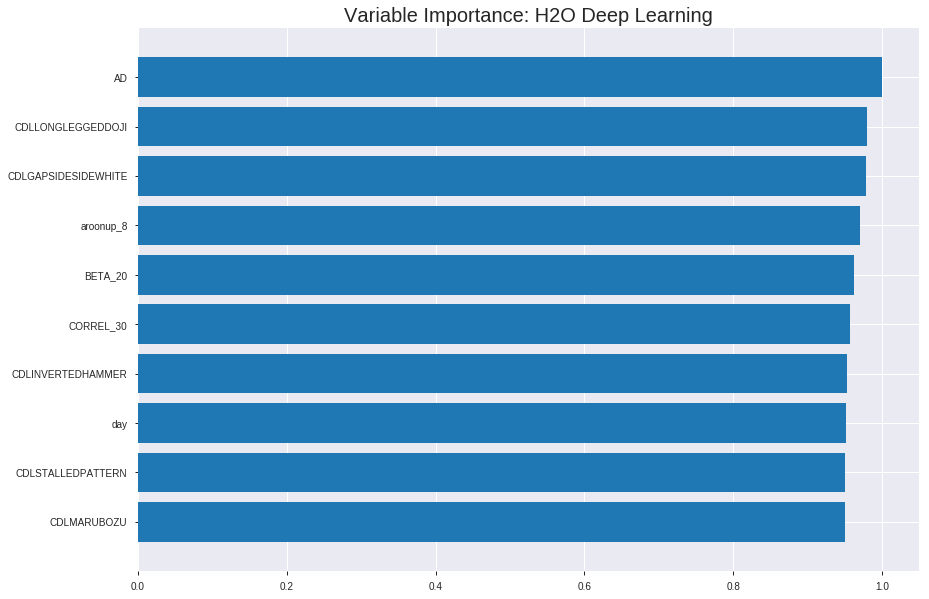

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_164020_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22073273518858877
RMSE: 0.46982202501435455
LogLoss: 0.6261613043830777
Mean Per-Class Error: 0.34757449453825207
AUC: 0.7141018413042723
pr_auc: 0.7266864377231513
Gini: 0.4282036826085447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46541563004041253: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      259  498   0.6579   (498.0/757.0)
1      85   714   0.1064   (85.0/799.0)
Total  344  1212  0.3747   (583.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465416     0.710094  268
max f2                       0.256486     0.851224  347
max f0point5                 0.643459     0.662375  164
max accuracy                 0.612254     0.652956  186
max precision                0.99958      1         0
max recall                   0.0484995    1         396
max specificity              0.99958      1         0
max absolute_mcc             0.612254     0.305085  186
max min_per_class_accuracy   0.620728     0.64831   180
max mean_per_class_accuracy  0.612254     0.652426  186

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 60.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.997042           1.94743   1.94743            1                0.998648  1                           0.998648            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.975145           1.94743   1.94743            1                0.989096  1                           0.993872            0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.95653            1.94743   1.94743            1                0.966542  1                           0.98515             0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.939063           1.94743   1.94743            1                0.948267  1                           0.975783            0.020025        0.0788486                  94.7434   94.7434
    5        0.0501285                   0.918528           1.68778   1.8975             0.866667         0.928786  0.974359                    0.966745            0.0162703       0.0951189                  68.7776   89.75
    6        0.100257                    0.84677            1.62286   1.76018            0.833333         0.882151  0.903846                    0.924448            0.0813517       0.176471                   62.2862   76.0181
    7        0.150386                    0.797087           1.27332   1.59789            0.653846         0.818827  0.820513                    0.889241            0.0638298       0.2403                     27.3322   59.7895
    8        0.200514                    0.764952           1.22339   1.50427            0.628205         0.780649  0.772436                    0.862093            0.0613267       0.301627                   22.3388   50.4268
    9        0.300129                    0.695912           1.1559    1.38864            0.593548         0.728156  0.713062                    0.817638            0.115144        0.416771                   15.5896   38.8642
    10       0.400386                    0.655183           1.24836   1.35351            0.641026         0.675127  0.695024                    0.781953            0.125156        0.541927                   24.8355   35.3514
    11       0.5                         0.62118            1.04282   1.29161            0.535484         0.6377    0.663239                    0.753214            0.10388         0.645807                   4.28197   29.1615
    12       0.600257                    0.585179           0.936266  1.23226            0.480769         0.602276  0.632762                    0.728004            0.0938673       0.739675                   -6.37335  23.2263
    13       0.699871                    0.526009           0.904615  1.18563            0.464516         0.558706  0.608815                    0.703907            0.0901126       0.829787                   -9.53854  18.5628
    14       0.800129                    0.447591           0.749013  1.13092            0.384615         0.48938   0.580723                    0.677027            0.0750939       0.904881                   -25.0987  13.092
    15       0.899743                    0.336344           0.678461  1.08083            0.348387         0.397972  0.555                       0.646131            0.0675845       0.972466                   -32.1539  8.0826
    16       1                           0.0112467          0.274638  1                  0.141026         0.212582  0.513496                    0.602665            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2725291401897171
RMSE: 0.5220432359390523
LogLoss: 0.7630947163242546
Mean Per-Class Error: 0.41774039729724244
AUC: 0.5579205811334538
pr_auc: 0.5808297704004209
Gini: 0.11584116226690755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04279520260618271: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0427952    0.664662  399
max f2                       0.0427952    0.832078  399
max f0point5                 0.660752     0.556916  131
max accuracy                 0.691861     0.583333  103
max precision                0.999612     1         0
max recall                   0.0427952    1         399
max specificity              0.999612     1         0
max absolute_mcc             0.691861     0.18724   103
max min_per_class_accuracy   0.609392     0.529412  191
max mean_per_class_accuracy  0.691861     0.58226   103

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 58.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.994632           1.20543   1.20543            0.6              0.998059  0.6                         0.998059            0.0135747       0.0135747                  20.543    20.543
    2        0.0202703                   0.96457            2.00905   1.56259            1                0.98292   0.777778                    0.991331            0.0180995       0.0316742                  100.905   56.2594
    3        0.0315315                   0.91965            1.60724   1.57854            0.8              0.949298  0.785714                    0.976319            0.0180995       0.0497738                  60.724    57.8539
    4        0.0405405                   0.877487           1.50679   1.56259            0.75             0.888187  0.777778                    0.956734            0.0135747       0.0633484                  50.6787   56.2594
    5        0.0518018                   0.850841           1.60724   1.5723             0.8              0.861015  0.782609                    0.935926            0.0180995       0.081448                   60.724    57.23
    6        0.101351                    0.793961           1.18717   1.38401            0.590909         0.817531  0.688889                    0.878044            0.0588235       0.140271                   18.7166   38.4012
    7        0.150901                    0.753008           1.18717   1.31938            0.590909         0.769763  0.656716                    0.842489            0.0588235       0.199095                   18.7166   31.9376
    8        0.20045                     0.712237           1.00452   1.24155            0.5              0.729591  0.617978                    0.814582            0.0497738       0.248869                   0.452489  24.1548
    9        0.29955                     0.674245           1.18717   1.22356            0.590909         0.692974  0.609023                    0.77435             0.117647        0.366516                   18.7166   22.3557
    10       0.400901                    0.636462           0.848265  1.12868            0.422222         0.654595  0.561798                    0.744075            0.0859729       0.452489                   -15.1735  12.868
    11       0.5                         0.603844           0.776224  1.05882            0.386364         0.62084   0.527027                    0.71965             0.0769231       0.529412                   -22.3776  5.88235
    12       0.599099                    0.554853           1.09585   1.06495            0.545455         0.576019  0.530075                    0.695891            0.108597        0.638009                   9.58453   6.49474
    13       0.70045                     0.511122           0.758974  1.02067            0.377778         0.532137  0.508039                    0.672197            0.0769231       0.714932                   -24.1026  2.06748
    14       0.79955                     0.45134            0.913204  1.00735            0.454545         0.485103  0.501408                    0.649008            0.0904977       0.80543                    -8.67956  0.735453
    15       0.898649                    0.379942           0.867544  0.991937           0.431818         0.413253  0.493734                    0.62301             0.0859729       0.891403                   -13.2456  -0.806314
    16       1                           0.0427952          1.07149   1                  0.533333         0.274796  0.497748                    0.587718          


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:44:19  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:44:23  5.167 sec   256 obs/sec       0.710797  1             1106       0.680856         1.79964             -0.855614      0.544078        0.562623           1.58229          0.479434                         0.677045           1.86062               -0.833599        0.481373          0.494453             1.60724            0.502252
    2019-08-27 16:44:32  14.296 sec  436 obs/sec       3.5527    5             5528       0.548147         0.817857            -0.202738      0.654052        0.679286           1.94743          0.446015                         0.573218           0.889486              -0.314344        0.508269          0.540785             2.00905            0.502252
    2019-08-27 16:44:40  22.897 sec  546 obs/sec       7.09447   10            11039      0.469822         0.626161            0.116425       0.714102        0.726686           1.94743          0.374679                         0.522043           0.763095              -0.0901387       0.557921          0.58083              1.20543            0.502252
    2019-08-27 16:44:51  33.733 sec  618 obs/sec       12.0289   17            18717      0.525964         0.805854            -0.107361      0.783526        0.777789           1.94743          0.303985                         0.611422           1.13349               -0.495377        0.504048          0.519591             1.20543            0.5
    2019-08-27 16:44:59  41.471 sec  647 obs/sec       15.5161   22            24143      0.432536         0.543874            0.251104       0.845095        0.850506           1.94743          0.266067                         0.560466           0.97382               -0.256514        0.498813          0.531637             1.60724            0.502252
    2019-08-27 16:45:07  49.336 sec  668 obs/sec       19.0488   27            29640      0.380379         0.437139            0.420825       0.87493         0.845489           1.94743          0.221722                         0.583566           1.05302               -0.362224        0.495019          0.518112             1.20543            0.502252
    2019-08-27 16:45:16  58.522 sec  687 obs/sec       23.2918   33            36242      0.359266         0.39111             0.483335       0.908298        0.87918            1.94743          0.179949                         0.586683           1.13945               -0.376817        0.508147          0.537742             1.60724            0.497748
    2019-08-27 16:45:17  59.350 sec  686 obs/sec       23.2918   33            36242      0.469822         0.626161            0.116425       0.714102        0.726686           1.94743          0.374679                         0.522043           0.763095              -0.0901387       0.557921          0.58083              1.20543            0.502252

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
AD                   1.0                    1.0                  0.021547231426651502
CDLLONGLEGGEDDOJI    0.9794067740440369     0.9794067740440369   0.02110350442115704
CDLGAPSIDESIDEWHITE  0.9783616065979004     0.9783616065979004   0.021080983956315535
aroonup_8            0.9702677726745605     0.9702677726745605   0.020906584243640447
BETA_20              0.9627552032470703     0.9627552032470703   0.020744709171577527
---                  ---                    ---                  ---
STOCHF_fastk         0.892169177532196      0.892169177532196    0.019223775740011557
OBV                  0.882059633731842      0.882059633731842    0.01900594306012746
STOCHRSI_fastd       0.8737258911132812     0.8737258911132812   0.018826373979275182
CORREL_8             0.8720584511756897     0.8720584511756897   0.018790445265049856
weekday_name         0.8700854182243347     0.8700854182243347   0.018747931867434602


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6689419795221844)

('auc', 0.5695652173913044)

('logloss', 0.866762141029946)

('mean_per_class_error', 0.41590177133655404)

('rmse', 0.5509652656988124)

('mse', 0.3035627240065629)

deeplearning prediction progress: |███████████████████████████████████████| 100%


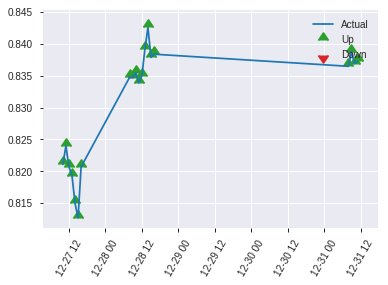


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3035627240065629
RMSE: 0.5509652656988124
LogLoss: 0.866762141029946
Mean Per-Class Error: 0.41590177133655404
AUC: 0.5695652173913044
pr_auc: 0.5107808871029808
Gini: 0.13913043478260878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5516453625055561: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      28   87   0.7565   (87.0/115.0)
1      10   98   0.0926   (10.0/108.0)
Total  38   185  0.435    (97.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.551645     0.668942  184
max f2                       0.304004     0.824427  222
max f0point5                 0.551645     0.57783   184
max accuracy                 0.688706     0.58296   118
max precision                0.757085     0.573034  88
max recall                   0.304004     1         222
max specificity              0.977897     0.991304  0
max absolute_mcc             0.551645     0.200554  184
max min_per_class_accuracy   0.703738     0.564815  110
max mean_per_class_accuracy  0.688706     0.584098  118

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 70.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.96365            0         0                  0                0.972136  0                           0.972136            0               0                          -100      -100
    2        0.0224215                   0.955054           1.03241   0.412963           0.5              0.95815   0.2                         0.966542            0.00925926      0.00925926                 3.24074   -58.7037
    3        0.0313901                   0.949985           1.03241   0.589947           0.5              0.953541  0.285714                    0.962827            0.00925926      0.0185185                  3.24074   -41.0053
    4        0.0403587                   0.944449           1.03241   0.688272           0.5              0.946497  0.333333                    0.959198            0.00925926      0.0277778                  3.24074   -31.1728
    5        0.0538117                   0.938655           2.06481   1.03241            1                0.941378  0.5                         0.954743            0.0277778       0.0555556                  106.481   3.24074
    6        0.103139                    0.902248           0.750842  0.897746           0.363636         0.920103  0.434783                    0.938176            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.881946           1.12626   0.971678           0.545455         0.888284  0.470588                    0.922034            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.8605             1.12626   1.00947            0.545455         0.869637  0.488889                    0.909226            0.0555556       0.203704                   12.6263   0.946502
    9        0.300448                    0.814601           1.31397   1.10945            0.636364         0.837562  0.537313                    0.885695            0.12963         0.333333                   31.3973   10.9453
    10       0.399103                    0.756307           1.40783   1.18321            0.681818         0.773016  0.573034                    0.857841            0.138889        0.472222                   40.7828   18.3208
    11       0.502242                    0.703619           0.897746  1.12459            0.434783         0.732721  0.544643                    0.832147            0.0925926       0.564815                   -10.2254  12.4587
    12       0.600897                    0.657329           0.938552  1.09404            0.454545         0.679506  0.529851                    0.807087            0.0925926       0.657407                   -6.14478  9.40437
    13       0.699552                    0.61247            0.938552  1.07212            0.454545         0.629771  0.519231                    0.782081            0.0925926       0.75                       -6.14478  7.21154
    14       0.798206                    0.568261           1.03241   1.06721            0.5              0.590655  0.516854                    0.758421            0.101852        0.851852                   3.24074   6.72077
    15       0.896861                    0.508689           0.750842  1.03241            0.363636         0.543266  0.5                         0.734754            0.0740741       0.925926                   -24.9158  3.24074
    16       1                           0.304004           0.718196  1                  0.347826         0.453615  0.484305                    0.705758      

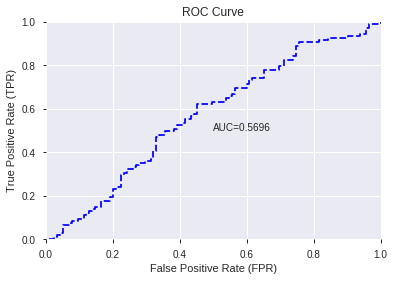

This function is available for GLM models only


--2019-08-27 16:47:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_164020_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_164020_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['AD',
 'CDLLONGLEGGEDDOJI',
 'CDLGAPSIDESIDEWHITE',
 'aroonup_8',
 'BETA_20',
 'CORREL_30',
 'CDLINVERTEDHAMMER',
 'day',
 'CDLSTALLEDPATTERN',
 'CDLMARUBOZU',
 'days_in_month',
 'MFI_14',
 'CDLTHRUSTING',
 'hour',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'aroonup_20',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'BETA_30',
 'DX_30',
 'HT_TRENDMODE',
 'HT_PHASOR_quadrature',
 'CDLDARKCLOUDCOVER',
 'aroonup_30',
 'SUB',
 'CDLEVENINGDOJISTAR',
 'ADOSC',
 'STOCH_slowd',
 'aroonup_12',
 'MFI_8',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'weekday',
 'CDLHOMINGPIGEON',
 'CCI_8',
 'aroondown_30',
 'MACDFIX_hist_8',
 'BOP',
 'CDLSHOOTINGSTAR',
 'dayofweek',
 'STOCHF_fastd',
 'WILLR_12',
 'WILLR_8',
 'CDLTASUKIGAP',
 'STOCHF_fastk',
 'OBV',
 'STOCHRSI_fastd',
 'CORREL_8',
 'weekday_name']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_164718_model_1  0.564171  0.693499              0.491304  0.500176  0.250176

variable  relative_importance  scaled_importance  percentage
0                     AD             0.009196           1.000000    0.059175
1              CORREL_30             0.007025           0.763925    0.045205
2         CDLEVENINGSTAR             0.006732           0.732000    0.043316
3                BETA_30             0.006727           0.731485    0.043286
4      CDLSTALLEDPATTERN             0.006653           0.723496    0.042813
5                BETA_20             0.006446           0.700894    0.041475
6                    OBV             0.006296           0.684629    0.040513
7            CDLMARUBOZU             0.006142           0.667851    0.039520
8           HT_TRENDMODE             0.005599           0.608838    0.036028
9        CDLLADDERBOTTOM             0.005245           0.570302    0.033748
10       CDLSHOOTINGSTAR             0.004931           0.536165    0.031728
11             aroonup_8             0.004908           0.533713    0.031582
12          CDLTHRUSTING             0.004253           0.462519    0.027370
13          CDLTASUKIGAP             0.004251           0.462257    0.027354
14    CDLEVENINGDOJISTAR             0.004034           0.438633    0.025956
15                  hour             0.003931           0.427436    0.025294
16        STOCHRSI_fastk             0.003770           0.409969    0.024260
17        is_month_start             0.003642           0.396089    0.023439
18     CDLINVERTEDHAMMER             0.003606           0.392149    0.023205
19       CDLUNIQUE3RIVER             0.003175           0.345215    0.020428
20            aroonup_12             0.003146           0.342119    0.020245
21          aroondown_30             0.003137           0.341099    0.020185
22          STOCHF_fastk             0.003089           0.335913    0.019878
23   CDLGAPSIDESIDEWHITE             0.003089           0.335911    0.019878
24                   BOP             0.003075           0.334412    0.019789
25            aroonup_30             0.003054           0.332070    0.019650
26     CDLLONGLEGGEDDOJI             0.002973           0.323264    0.019129
27                 MFI_8             0.002619           0.284774    0.016851
28              CORREL_8             0.002581           0.280648    0.016607
29            aroonup_20             0.002277           0.247586    0.014651
30                   day             0.002192           0.238307    0.014102
31              WILLR_12             0.002015           0.219129    0.012967
32               WILLR_8             0.001856           0.201794    0.011941
33                 CCI_8             0.001592           0.173068    0.010241
34       CDLHOMINGPIGEON             0.001534           0.166805    0.009871
35  HT_PHASOR_quadrature             0.001510           0.164202    0.009717
36        STOCHRSI_fastd             0.001478           0.160744    0.009512
37                 DX_30             0.001408           0.153131    0.009062
38        MACDFIX_hist_8             0.001396           0.151770    0.008981
39           STOCH_slowd             0.001312           0.142619    0.008440
40                 ADOSC             0.001166           0.126801    0.007503
41          STOCHF_fastd             0.000745           0.080995    0.004793
42                MFI_14             0.000565           0.061452    0.003636
43           AROONOSC_14             0.000556           0.060441    0.003577
44     CDLDARKCLOUDCOVER             0.000199           0.021679    0.001283
45          weekday_name             0.000129           0.014029    0.000830
46             dayofweek             0.000055           0.006032    0.000357
47               weekday             0.000052           0.005660    0.000335
48         days_in_month             0.000046           0.005015    0.000297
49                   SUB             0.000000           0.000000    0.000000

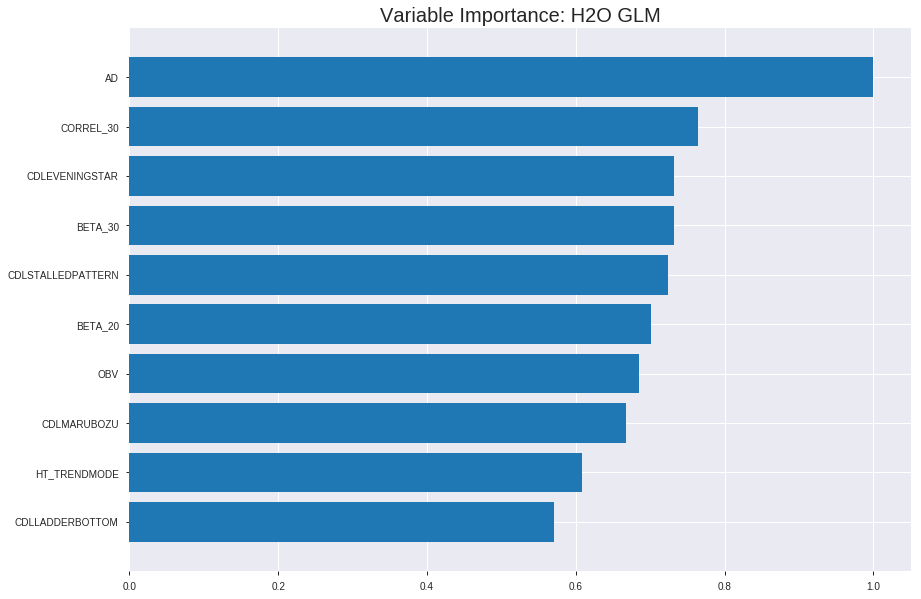

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_164718_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24833417107579345
RMSE: 0.4983313868058016
LogLoss: 0.6898105074308292
Null degrees of freedom: 1555
Residual degrees of freedom: 1506
Null deviance: 2155.940212106897
Residual deviance: 2146.6902991247402
AIC: 2246.6902991247402
AUC: 0.5959885457879153
pr_auc: 0.6162834420931889
Gini: 0.19197709157583054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49344391438501556: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    749   0.9894   (749.0/757.0)
1      1    798   0.0013   (1.0/799.0)
Total  9    1547  0.482    (750.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493444     0.680307  391
max f2                       0.490441     0.841407  395
max f0point5                 0.507541     0.585457  288
max accuracy                 0.515273     0.573265  176
max precision                0.566162     1         0
max recall                   0.490441     1         395
max specificity              0.566162     1         0
max absolute_mcc             0.515273     0.157696  176
max min_per_class_accuracy   0.512986     0.562748  211
max mean_per_class_accuracy  0.515273     0.576564  176

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.539308           1.70401   1.70401            0.875            0.547523  0.875                       0.547523            0.0175219       0.0175219                  70.4005   70.4005
    2        0.0205656                   0.532733           1.58229   1.64315            0.8125           0.535623  0.84375                     0.541573            0.0162703       0.0337922                  58.229    64.3148
    3        0.0302057                   0.530052           1.55795   1.61596            0.8              0.531294  0.829787                    0.538292            0.0150188       0.048811                   55.7947   61.5956
    4        0.0404884                   0.528155           1.46058   1.57649            0.75             0.529034  0.809524                    0.535941            0.0150188       0.0638298                  46.0576   57.6494
    5        0.0501285                   0.527159           1.42812   1.54796            0.733333         0.527507  0.794872                    0.534319            0.0137672       0.077597                   42.8118   54.7961
    6        0.100257                    0.52327            1.14849   1.34822            0.589744         0.524983  0.692308                    0.529651            0.057572        0.135169                   14.8487   34.8224
    7        0.150386                    0.521218           1.29829   1.33158            0.666667         0.52224   0.683761                    0.527181            0.0650814       0.20025                    29.829    33.1579
    8        0.200514                    0.519578           1.07359   1.26708            0.551282         0.520398  0.650641                    0.525485            0.0538173       0.254068                   7.35856   26.7081
    9        0.300129                    0.517103           1.06795   1.20099            0.548387         0.51843   0.616702                    0.523143            0.106383        0.360451                   6.79478   20.0987
    10       0.400386                    0.514908           1.07359   1.16909            0.551282         0.515935  0.600321                    0.521338            0.107635        0.468085                   7.35856   16.9086
    11       0.5                         0.513079           0.942307  1.1239             0.483871         0.51398   0.577121                    0.519872            0.0938673       0.561952                   -5.76931  12.3905
    12       0.600257                    0.511044           0.873849  1.08214            0.448718         0.512014  0.555675                    0.51856             0.0876095       0.649562                   -12.6151  8.21396
    13       0.699871                    0.50922            0.979999  1.0676             0.503226         0.510129  0.548209                    0.51736             0.097622        0.747184                   -2.00008  6.76017
    14       0.800129                    0.506959           0.923783  1.04958            0.474359         0.508064  0.538956                    0.516195            0.0926158       0.8398                     -7.62171  4.95811
    15       0.899743                    0.503859           0.904615  1.03353            0.464516         0.505583  0.530714                    0.51502             0.0901126       0.929912                   -9.53854  3.35312
    16       1                           0.473128           0.699079  1                  0.358974         0.49982   0.513496                    0.513496         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25050710748459587
RMSE: 0.5005068505870782
LogLoss: 0.6941617288390962
Null degrees of freedom: 443
Residual degrees of freedom: 394
Null deviance: 615.9463007458467
Residual deviance: 616.4156152091174
AIC: 716.4156152091174
AUC: 0.4875210518840168
pr_auc: 0.5072325016724056
Gini: -0.024957896231966425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47621359108991534: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476214     0.664662  399
max f2                       0.476214     0.832078  399
max f0point5                 0.476214     0.55333   399
max accuracy                 0.525838     0.52027   17
max precision                0.535923     0.8       4
max recall                   0.476214     1         399
max specificity              0.563781     0.995516  0
max absolute_mcc             0.4989       0.147738  387
max min_per_class_accuracy   0.513935     0.488789  197
max mean_per_class_accuracy  0.522482     0.518384  35

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.534662           1.60724   1.60724            0.8              0.547939  0.8                         0.547939            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.529778           1.00452   1.33937            0.5              0.531257  0.666667                    0.540525            0.00904977      0.0271493                  0.452489  33.9367
    3        0.0315315                   0.527011           1.20543   1.29153            0.6              0.527945  0.642857                    0.536032            0.0135747       0.040724                   20.543    29.1532
    4        0.0405405                   0.525826           2.00905   1.45098            1                0.526443  0.722222                    0.533901            0.0180995       0.0588235                  100.905   45.098
    5        0.0518018                   0.524513           0.40181   1.2229             0.2              0.52506   0.608696                    0.531979            0.00452489      0.0633484                  -59.819   22.29
    6        0.101351                    0.521745           1.09585   1.16078            0.545455         0.522975  0.577778                    0.527577            0.0542986       0.117647                   9.58453   16.0784
    7        0.150901                    0.520272           0.730564  1.01952            0.363636         0.521009  0.507463                    0.52542             0.0361991       0.153846                   -26.9436  1.95178
    8        0.20045                     0.518853           1.18717   1.06096            0.590909         0.519425  0.52809                     0.523938            0.0588235       0.21267                    18.7166   6.09589
    9        0.29955                     0.517349           0.821884  0.981866           0.409091         0.518001  0.488722                    0.521974            0.081448        0.294118                   -17.8116  -1.81336
    10       0.400901                    0.515712           0.892911  0.959378           0.444444         0.516596  0.477528                    0.520615            0.0904977       0.384615                   -10.7089  -4.06223
    11       0.5                         0.51394            1.05019   0.977376           0.522727         0.514716  0.486486                    0.519446            0.104072        0.488688                   5.01851   -2.26244
    12       0.599099                    0.511651           0.913204  0.966761           0.454545         0.512925  0.481203                    0.518367            0.0904977       0.579186                   -8.67956  -3.32392
    13       0.70045                     0.509449           0.937557  0.962535           0.466667         0.510544  0.4791                      0.517235            0.0950226       0.674208                   -6.24434  -3.74649
    14       0.79955                     0.507119           1.14151   0.984717           0.568182         0.508279  0.490141                    0.516125            0.113122        0.78733                    14.1506   -1.52826
    15       0.898649                    0.503782           1.09585   0.996972           0.545455         0.505708  0.496241                    0.514976            0.108597        0.895928                   9.58453   -0.302793
    16       1                           0.476214           1.02685   1                  0.511111         0.499329  0.497748                    0.51339      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:47:18  0.000 sec   2            3.9       50            1.37962           1.38832
    2019-08-27 16:47:18  0.019 sec   4            2.4       51            1.37671           1.389
    2019-08-27 16:47:18  0.039 sec   6            1.5       51            1.37281           1.39011
    2019-08-27 16:47:18  0.056 sec   8            0.93      51            1.36794           1.39185
    2019-08-27 16:47:18  0.072 sec   10           0.58      51            1.36231           1.3945

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6565349544072948)

('auc', 0.564170692431562)

('logloss', 0.6934992812886872)

('mean_per_class_error', 0.4341384863123994)

('rmse', 0.5001763639699363)

('mse', 0.2501763950741861)

glm prediction progress: |████████████████████████████████████████████████| 100%


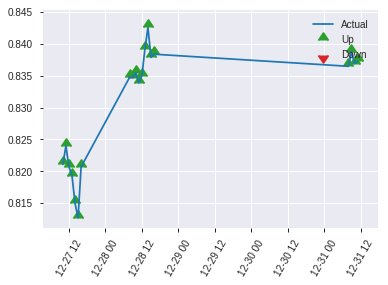


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501763950741861
RMSE: 0.5001763639699363
LogLoss: 0.6934992812886872
Null degrees of freedom: 222
Residual degrees of freedom: 173
Null deviance: 309.68415973716924
Residual deviance: 309.3006794547546
AIC: 409.3006794547546
AUC: 0.564170692431562
pr_auc: 0.5229341476671012
Gini: 0.12834138486312408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048715536517343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    108  0        (0.0/108.0)
Total  2    221  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504872     0.656535  220
max f2                       0.504872     0.826953  220
max f0point5                 0.510226     0.559955  193
max accuracy                 0.517823     0.565022  116
max precision                0.543758     1         0
max recall                   0.504872     1         220
max specificity              0.543758     1         0
max absolute_mcc             0.510226     0.134584  193
max min_per_class_accuracy   0.518053     0.547826  111
max mean_per_class_accuracy  0.517823     0.565862  116

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.540757           1.37654   1.37654            0.666667         0.542037  0.666667                    0.542037            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.536775           1.03241   1.23889            0.5              0.538517  0.6                         0.540629            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.532883           1.03241   1.17989            0.5              0.534591  0.571429                    0.538904            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.532419           1.03241   1.14712            0.5              0.53273   0.555556                    0.537532            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.53191            0.688272  1.03241            0.333333         0.532146  0.5                         0.536185            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.528647           0.750842  0.897746           0.363636         0.5304    0.434783                    0.533418            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.527526           1.12626   0.971678           0.545455         0.528052  0.470588                    0.531682            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.52501            1.50168   1.10123            0.727273         0.526384  0.533333                    0.530387            0.0740741       0.222222                   50.1684   10.1235
    9        0.300448                    0.522036           1.22012   1.14027            0.590909         0.523306  0.552239                    0.528062            0.12037         0.342593                   22.0118   14.0271
    10       0.399103                    0.51979            1.03241   1.11361            0.5              0.520866  0.539326                    0.526283            0.101852        0.444444                   3.24074   11.3608
    11       0.502242                    0.518053           1.07729   1.10615            0.521739         0.518922  0.535714                    0.524772            0.111111        0.555556                   7.72947   10.6151
    12       0.600897                    0.516736           0.938552  1.07863            0.454545         0.517379  0.522388                    0.523558            0.0925926       0.648148                   -6.14478  7.86346
    13       0.699552                    0.515116           1.03241   1.07212            0.5              0.516025  0.519231                    0.522496            0.101852        0.75                       3.24074   7.21154
    14       0.798206                    0.512692           0.938552  1.05561            0.454545         0.513886  0.511236                    0.521431            0.0925926       0.842593                   -6.14478  5.56076
    15       0.896861                    0.509291           0.844697  1.03241            0.409091         0.511082  0.5                         0.520293            0.0833333       0.925926                   -15.5303  3.24074
    16       1                           0.499862           0.718196  1                  0.347826         0.507127  0.484305                    0.518935       

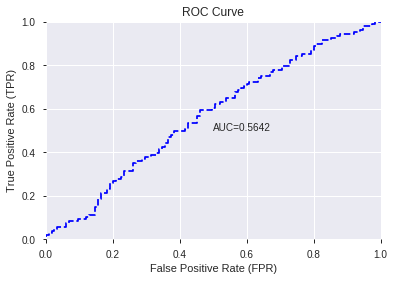

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


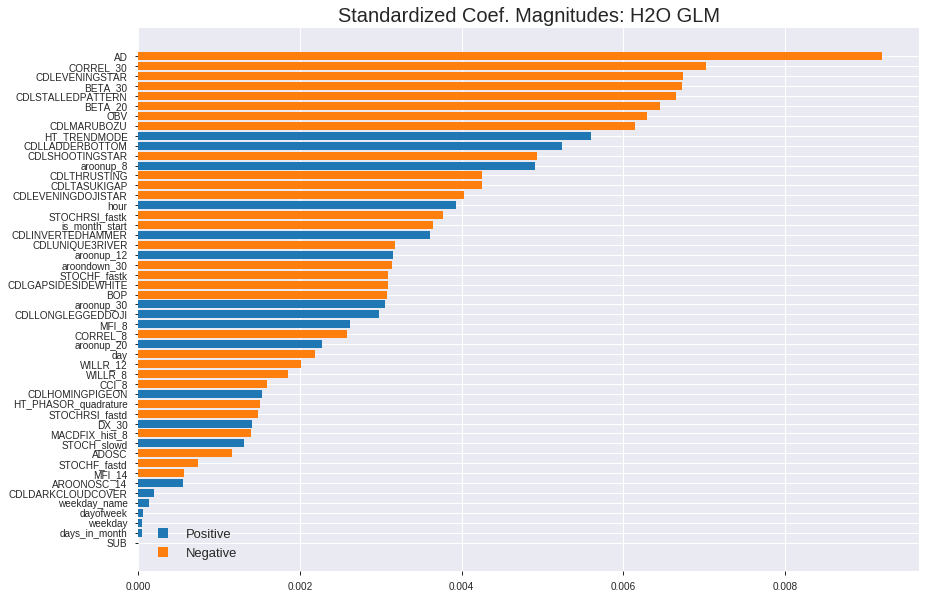

'log_likelihood'
--2019-08-27 16:47:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_164718_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_164718_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['AD',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'BETA_30',
 'CDLSTALLEDPATTERN',
 'BETA_20',
 'OBV',
 'CDLMARUBOZU',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLSHOOTINGSTAR',
 'aroonup_8',
 'CDLTHRUSTING',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'hour',
 'STOCHRSI_fastk',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLUNIQUE3RIVER',
 'aroonup_12',
 'aroondown_30',
 'STOCHF_fastk',
 'CDLGAPSIDESIDEWHITE',
 'BOP',
 'aroonup_30',
 'CDLLONGLEGGEDDOJI',
 'MFI_8',
 'CORREL_8',
 'aroonup_20',
 'day',
 'WILLR_12',
 'WILLR_8',
 'CCI_8',
 'CDLHOMINGPIGEON',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'DX_30',
 'MACDFIX_hist_8',
 'STOCH_slowd',
 'ADOSC',
 'STOCHF_fastd',
 'MFI_14',
 'AROONOSC_14',
 'CDLDARKCLOUDCOVER',
 'weekday_name',
 'dayofweek',
 'weekday',
 'days_in_month',
 'SUB']

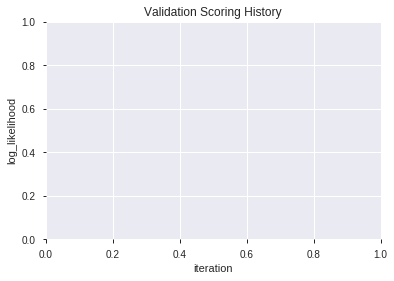

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_164734  0.587359  0.690160              0.482609  0.498413  0.248415
1               XGBoost_1_AutoML_20190827_164734  0.574155  0.697412              0.396095  0.501646  0.251649
2  XGBoost_grid_1_AutoML_20190827_164734_model_6  0.569565  0.700602              0.441385  0.503290  0.253301
3  XGBoost_grid_1_AutoML_20190827_164734_model_1  0.562238  0.706175              0.425121  0.505799  0.255833
4  XGBoost_grid_1_AutoML_20190827_164734_model_5  0.556280  0.724362              0.478261  0.513159  0.263332
5  XGBoost_grid_1_AutoML_20190827_164734_model_7  0.548631  0.704558              0.449799  0.504940  0.254965
6               XGBoost_2_AutoML_20190827_164734  0.547665  0.699303              0.495652  0.502913  0.252922
7  XGBoost_grid_1_AutoML_20190827_164734_model_2  0.542432  0.696027              0.470129  0.501296  0.251298
8  XGBoost_grid_1_AutoML_20190827_164734_model_3  0.534944  0.714051              0.469847  0.509648  0.259742
9  XGBoost_grid_1_AutoML_20190827_164734_model_4  0.531159  0.697614              0.491586  0.502167  0.252172

variable  relative_importance  scaled_importance  percentage
0              CORREL_30           300.678925           1.000000    0.073663
1                     AD           269.710388           0.897005    0.066076
2                BETA_20           248.336777           0.825920    0.060840
3                    BOP           212.819626           0.707797    0.052139
4                    OBV           211.199280           0.702408    0.051742
5   HT_PHASOR_quadrature           203.798752           0.677795    0.049929
6                BETA_30           170.598114           0.567376    0.041795
7                  CCI_8           165.900345           0.551752    0.040644
8                  DX_30           161.466049           0.537005    0.039558
9                  MFI_8           158.396942           0.526798    0.038806
10          STOCHF_fastd           149.077454           0.495803    0.036523
11                   SUB           144.352997           0.480090    0.035365
12        MACDFIX_hist_8           136.288116           0.453268    0.033389
13        STOCHRSI_fastd           130.707108           0.434707    0.032022
14                MFI_14           128.558350           0.427560    0.031496
15           AROONOSC_14           117.958809           0.392308    0.028899
16          STOCHF_fastk           110.947266           0.368989    0.027181
17              CORREL_8           104.978058           0.349137    0.025719
18              WILLR_12           103.383438           0.343833    0.025328
19                 ADOSC            99.749641           0.331748    0.024438
20                   day            84.684258           0.281643    0.020747
21                  hour            80.379738           0.267327    0.019692
22             aroonup_8            78.744385           0.261889    0.019292
23               WILLR_8            77.731964           0.258521    0.019044
24          aroondown_30            73.551193           0.244617    0.018019
25            aroonup_20            66.395935           0.220820    0.016266
26           STOCH_slowd            59.955193           0.199399    0.014688
27            aroonup_30            59.629501           0.198316    0.014609
28            aroonup_12            54.355438           0.180776    0.013317
29          HT_TRENDMODE            39.640884           0.131838    0.009712
30        STOCHRSI_fastk            36.774769           0.122306    0.009009
31             dayofweek            25.153675           0.083656    0.006162
32           CDLMARUBOZU             5.898708           0.019618    0.001445
33          weekday_name             5.607990           0.018651    0.001374
34               weekday             4.296232           0.014288    0.001053
35         days_in_month             0.084885           0.000282    0.000021

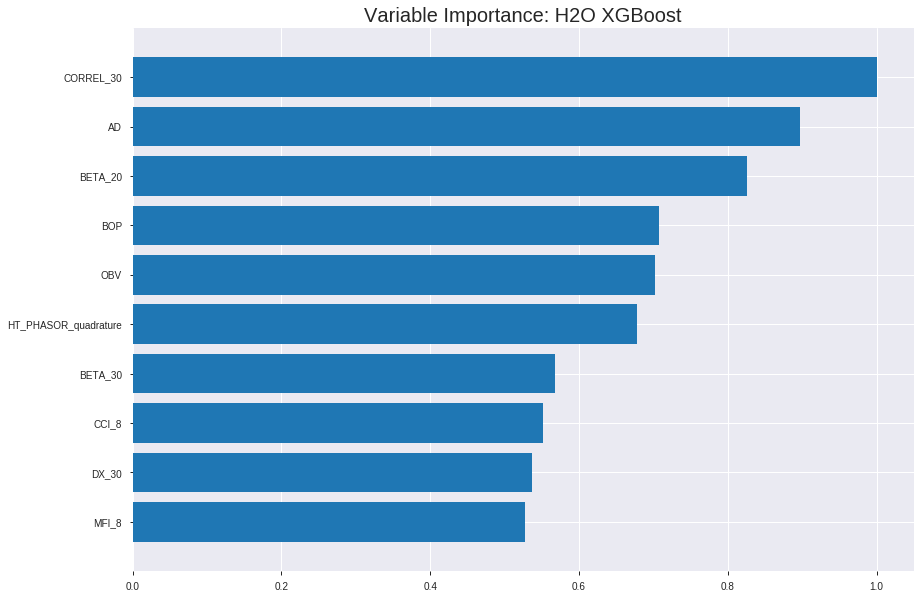

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_164734


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19003525975495236
RMSE: 0.43593033819057875
LogLoss: 0.5703208919166287
Mean Per-Class Error: 0.14882622432598214
AUC: 0.9256418607804009
pr_auc: 0.9251588627183707
Gini: 0.8512837215608018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5044951836268107: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      621  136  0.1797   (136.0/757.0)
1      96   703  0.1202   (96.0/799.0)
Total  717  839  0.1491   (232.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504495     0.858364  207
max f2                       0.465966     0.907153  247
max f0point5                 0.541963     0.861502  164
max accuracy                 0.508062     0.851542  203
max precision                0.81445      1         0
max recall                   0.343472     1         360
max specificity              0.81445      1         0
max absolute_mcc             0.508062     0.702844  203
max min_per_class_accuracy   0.512362     0.847309  198
max mean_per_class_accuracy  0.508062     0.851174  203

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.728419           1.94743    1.94743            1                0.748199  1                           0.748199            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.703062           1.94743    1.94743            1                0.716149  1                           0.732174            0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.685102           1.94743    1.94743            1                0.697012  1                           0.720952            0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.676095           1.82572    1.91652            0.9375           0.681267  0.984127                    0.710874            0.0187735       0.077597                   82.572    91.6523
    5        0.0501285                   0.667332           1.94743    1.92247            1                0.671733  0.987179                    0.703347            0.0187735       0.0963705                  94.7434   92.2467
    6        0.100257                    0.628309           1.94743    1.93495            1                0.646706  0.99359                     0.675026            0.097622        0.193992                   94.7434   93.4951
    7        0.150386                    0.613911           1.84757    1.90582            0.948718         0.620508  0.978632                    0.656854            0.0926158       0.286608                   84.7566   90.5822
    8        0.200514                    0.597897           1.8226     1.88502            0.935897         0.60505   0.967949                    0.643903            0.0913642       0.377972                   82.2599   88.5017
    9        0.300129                    0.567168           1.82179    1.86403            0.935484         0.581293  0.957173                    0.623122            0.181477        0.559449                   82.1793   86.4032
    10       0.400386                    0.543728           1.48554    1.76926            0.762821         0.553856  0.908507                    0.605778            0.148936        0.708385                   48.5543   76.9258
    11       0.5                         0.515792           1.28154    1.67209            0.658065         0.5292    0.858612                    0.590521            0.12766         0.836045                   28.1537   67.209
    12       0.600257                    0.484748           0.886332   1.54085            0.455128         0.500302  0.791221                    0.575453            0.0888611       0.924906                   -11.3668  54.085
    13       0.699871                    0.456009           0.464871   1.3877             0.23871          0.469228  0.71258                     0.560334            0.0463079       0.971214                   -53.5129  38.7703
    14       0.800129                    0.424427           0.21222    1.24041            0.108974         0.441259  0.636948                    0.545413            0.0212766       0.992491                   -78.778   24.0414
    15       0.899743                    0.379105           0.0628205  1.11004            0.0322581        0.403662  0.57                        0.529719            0.00625782      0.998748                   -93.718   11.0038
    16       1                           0.229949           0.0124836  1                  0.00641026       0.337918  0.513496                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24986995201618706
RMSE: 0.49986993509930866
LogLoss: 0.6929083684264996
Mean Per-Class Error: 0.4492725686342147
AUC: 0.5415559117748513
pr_auc: 0.5435869823008177
Gini: 0.08311182354970259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33607131242752075: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    222  0.9955   (222.0/223.0)
1      0    221  0        (0.0/221.0)
Total  1    443  0.5      (222.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336071     0.665663  398
max f2                       0.336071     0.832705  398
max f0point5                 0.37455      0.558717  383
max accuracy                 0.560771     0.551802  102
max precision                0.683572     1         0
max recall                   0.336071     1         398
max specificity              0.683572     1         0
max absolute_mcc             0.560771     0.116707  102
max min_per_class_accuracy   0.516474     0.529412  194
max mean_per_class_accuracy  0.559036     0.550727  105

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.668734           0.80362   0.80362            0.4              0.675311  0.4                         0.675311            0.00904977      0.00904977                 -19.638   -19.638
    2        0.0202703                   0.65121            2.00905   1.33937            1                0.659597  0.666667                    0.668327            0.0180995       0.0271493                  100.905   33.9367
    3        0.0315315                   0.641367           1.20543   1.29153            0.6              0.647567  0.642857                    0.660913            0.0135747       0.040724                   20.543    29.1532
    4        0.0405405                   0.629166           0.502262  1.11614            0.25             0.633929  0.555556                    0.654916            0.00452489      0.0452489                  -49.7738  11.6139
    5        0.0518018                   0.622963           1.60724   1.2229             0.8              0.626975  0.608696                    0.648842            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.602899           1.18717   1.20543            0.590909         0.612272  0.6                         0.630963            0.0588235       0.122172                   18.7166   20.543
    7        0.150901                    0.584335           1.18717   1.19943            0.590909         0.593351  0.597015                    0.618613            0.0588235       0.180995                   18.7166   19.9433
    8        0.20045                     0.571424           1.09585   1.17383            0.545455         0.576669  0.58427                     0.608245            0.0542986       0.235294                   9.58453   17.3827
    9        0.29955                     0.55047            1.05019   1.13292            0.522727         0.560633  0.56391                     0.592493            0.104072        0.339367                   5.01851   13.2923
    10       0.400901                    0.529574           1.02685   1.10611            0.511111         0.539491  0.550562                    0.579094            0.104072        0.443439                   2.68477   10.6106
    11       0.5                         0.514999           0.867544  1.05882            0.431818         0.52261   0.527027                    0.567899            0.0859729       0.529412                   -13.2456  5.88235
    12       0.599099                    0.500357           0.958865  1.04229            0.477273         0.506586  0.518797                    0.557757            0.0950226       0.624434                   -4.11353  4.2289
    13       0.70045                     0.479769           0.669683  0.988375           0.333333         0.491428  0.491961                    0.54816             0.0678733       0.692308                   -33.0317  -1.1625
    14       0.79955                     0.453843           1.14151   1.00735            0.568182         0.465967  0.501408                    0.537972            0.113122        0.80543                    14.1506   0.735453
    15       0.898649                    0.413712           1.09585   1.01711            0.545455         0.435401  0.506266                    0.526661            0.108597        0.914027                   9.58453   1.71129
    16       1                           0.300285           0.848265  1                  0.422222         0.377217  0.497748                    0.511515            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:47:37  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.486504                         0.5                0.693147              0.5               0                    1                  0.502252
    2019-08-27 16:47:38  0.130 sec   5                  0.49148          0.676229            0.770499        0.769021           1.82572          0.311697                         0.500057           0.69326               0.506838          0.50901              0.80362            0.5
    2019-08-27 16:47:38  0.197 sec   10                 0.483898         0.661342            0.810068        0.807311           1.94743          0.272494                         0.500409           0.693966              0.509324          0.526347             1.60724            0.502252
    2019-08-27 16:47:38  0.271 sec   15                 0.477191         0.648284            0.837494        0.837242           1.94743          0.264781                         0.500347           0.693832              0.51394           0.532406             1.20543            0.493243
    2019-08-27 16:47:38  0.332 sec   20                 0.469754         0.63396             0.86316         0.860253           1.94743          0.227506                         0.500145           0.693426              0.521458          0.540652             1.20543            0.495495
    2019-08-27 16:47:38  0.394 sec   25                 0.462074         0.619286            0.88246         0.881329           1.94743          0.196658                         0.500178           0.693452              0.519327          0.535781             1.60724            0.47973
    2019-08-27 16:47:38  0.454 sec   30                 0.456755         0.609207            0.894327        0.892372           1.94743          0.185733                         0.499481           0.692051              0.537143          0.55266              1.60724            0.484234
    2019-08-27 16:47:38  0.518 sec   35                 0.450573         0.597619            0.906982        0.906282           1.94743          0.163882                         0.499934           0.693026              0.539537          0.547495             1.60724            0.5
    2019-08-27 16:47:38  0.585 sec   40                 0.445612         0.588216            0.909537        0.908405           1.94743          0.163882                         0.499817           0.692765              0.539902          0.54897              1.20543            0.495495
    2019-08-27 16:47:38  0.646 sec   45                 0.440561         0.578843            0.917632        0.917953           1.94743          0.156812                         0.499933           0.693027              0.54116           0.540706             1.20543            0.495495
    2019-08-27 16:47:38  0.707 sec   50                 0.43593          0.570321            0.925642        0.925159           1.94743          0.1491                           0.49987            0.692908              0.541556          0.543587             0.80362            0.5

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ----------------------
CORREL_30      300.6789245605469      1.0                    0.07366347547461707
AD             269.71038818359375     0.8970046323592026     0.06607647873641002
BETA_20        248.33677673339844     0.8259201309049233     0.060840147306907344
BOP            212.8196258544922      0.7077969504032774     0.05213878329704059
OBV            211.19927978515625     0.7024079924917639     0.051741813928092066
---            ---                    ---                    ---
dayofweek      25.153675079345703     0.08365626262668296    0.0061624110502987856
CDLMARUBOZU    5.898707866668701      0.01961796250033113    0.0014451272995050996
weekday_name   5.607990264892578      0.018651091934989653   0.0013739042533279387
weekday        4.296232223510742      0.014288438173010766   0.0010525360149281609
days_in_month  0.0848846435546875     0.0002823099213845782  2.0795929970153948e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.6605504587155963)

('auc', 0.5873590982286634)

('logloss', 0.6901601216240327)

('mean_per_class_error', 0.40591787439613525)

('rmse', 0.4984125263170719)

('mse', 0.24841504638976586)

xgboost prediction progress: |████████████████████████████████████████████| 100%


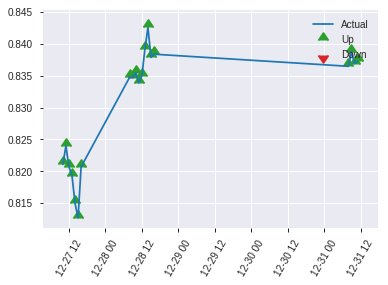


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24841504638976586
RMSE: 0.4984125263170719
LogLoss: 0.6901601216240327
Mean Per-Class Error: 0.40591787439613525
AUC: 0.5873590982286634
pr_auc: 0.5354422532886091
Gini: 0.17471819645732678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4264248013496399: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      0    108  0        (0.0/108.0)
Total  4    219  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426425     0.66055   218
max f2                       0.426425     0.829493  218
max f0point5                 0.513384     0.587838  157
max accuracy                 0.513384     0.587444  157
max precision                0.67118      0.666667  5
max recall                   0.426425     1         218
max specificity              0.695187     0.991304  0
max absolute_mcc             0.513384     0.206925  157
max min_per_class_accuracy   0.550258     0.565217  111
max mean_per_class_accuracy  0.513384     0.594082  157

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 54.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.689375           0.688272  0.688272           0.333333         0.694197  0.333333                    0.694197            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.6732             2.06481   1.23889            1                0.675586  0.6                         0.686753            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.65925            1.03241   1.17989            0.5              0.666541  0.571429                    0.680978            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.652292           1.03241   1.14712            0.5              0.655935  0.555556                    0.675413            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.646214           0.688272  1.03241            0.333333         0.64861   0.5                         0.668712            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.627577           1.12626   1.07729            0.545455         0.637243  0.521739                    0.653662            0.0555556       0.111111                   12.6263   7.72947
    7        0.152466                    0.614221           1.31397   1.15387            0.636364         0.618849  0.558824                    0.642399            0.0648148       0.175926                   31.3973   15.3867
    8        0.201794                    0.602368           1.31397   1.193              0.636364         0.60787   0.577778                    0.633959            0.0648148       0.240741                   31.3973   19.3004
    9        0.300448                    0.582452           1.03241   1.14027            0.5              0.590991  0.552239                    0.61985             0.101852        0.342593                   3.24074   14.0271
    10       0.399103                    0.568755           1.03241   1.11361            0.5              0.57566   0.539326                    0.608927            0.101852        0.444444                   3.24074   11.3608
    11       0.502242                    0.550258           1.25684   1.14302            0.608696         0.55948   0.553571                    0.598772            0.12963         0.574074                   25.6844   14.3022
    12       0.600897                    0.530432           1.03241   1.12486            0.5              0.540844  0.544776                    0.589262            0.101852        0.675926                   3.24074   12.4862
    13       0.699552                    0.516202           1.12626   1.12506            0.545455         0.522904  0.544872                    0.579904            0.111111        0.787037                   12.6263   12.5059
    14       0.798206                    0.496978           0.750842  1.07881            0.363636         0.506386  0.522472                    0.570817            0.0740741       0.861111                   -24.9158  7.88077
    15       0.896861                    0.470929           0.656987  1.03241            0.318182         0.484806  0.5                         0.561356            0.0648148       0.925926                   -34.3013  3.24074
    16       1                           0.365583           0.718196  1                  0.347826         0.444349  0.484305                    0.549288        

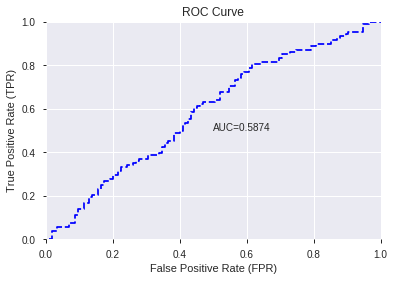

This function is available for GLM models only


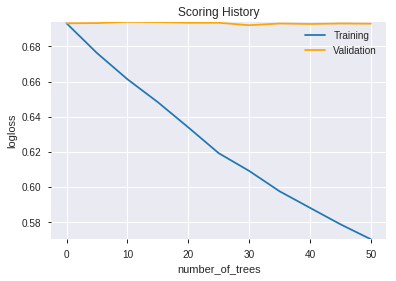

--2019-08-27 16:47:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.0
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.0|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.cons

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_164734',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_164734',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_a105',
   'type

['CORREL_30',
 'AD',
 'BETA_20',
 'BOP',
 'OBV',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'CCI_8',
 'DX_30',
 'MFI_8',
 'STOCHF_fastd',
 'SUB',
 'MACDFIX_hist_8',
 'STOCHRSI_fastd',
 'MFI_14',
 'AROONOSC_14',
 'STOCHF_fastk',
 'CORREL_8',
 'WILLR_12',
 'ADOSC',
 'day',
 'hour',
 'aroonup_8',
 'WILLR_8',
 'aroondown_30',
 'aroonup_20',
 'STOCH_slowd',
 'aroonup_30',
 'aroonup_12',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'dayofweek',
 'CDLMARUBOZU',
 'weekday_name',
 'weekday',
 'days_in_month']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 13] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_164803_model_2  0.550564  0.823830              0.458213  0.550227  0.302750
1  DeepLearning_grid_1_AutoML_20190827_164803_model_1  0.549517  3.604940              0.482890  0.670283  0.449280
2  DeepLearning_grid_1_AutoML_20190827_164803_model_3  0.545330  0.726186              0.456804  0.514039  0.264236
3  DeepLearning_grid_1_AutoML_20190827_164803_model_6  0.541063  0.706683              0.478261  0.506651  0.256695
4  DeepLearning_grid_1_AutoML_20190827_164803_model_9  0.535829  0.694835              0.469565  0.500842  0.250843
5  DeepLearning_grid_1_AutoML_20190827_164803_model_5  0.529549  0.692599              0.500000  0.499726  0.249726
6  DeepLearning_grid_1_AutoML_20190827_164803_model_4  0.519324  2.255457              0.452738  0.682030  0.465165
7  DeepLearning_grid_1_AutoML_20190827_164803_model_7  0.515700  0.794547              0.491304  0.543001  0.294851
8  DeepLearning_grid_1_AutoML_20190827_164803_model_8  0.486111  0.694054              0.500000  0.500453  0.250453
9               DeepLearning_1_AutoML_20190827_164803  0.474517  0.694267              0.500000  0.500560  0.250561

variable  relative_importance  scaled_importance  percentage
0                        hour             1.000000           1.000000    0.002277
1                         OBV             0.958546           0.958546    0.002183
2                HT_TRENDMODE             0.943920           0.943920    0.002149
3                          AD             0.940640           0.940640    0.002142
4                    CORREL_8             0.935187           0.935187    0.002129
...                       ...                  ...                ...         ...
1032   BBANDS_lowerband_8_7_5             0.342419           0.342419    0.000780
1033  BBANDS_lowerband_24_6_2             0.339844           0.339844    0.000774
1034                      EXP             0.336420           0.336420    0.000766
1035       CDLSEPARATINGLINES             0.334342           0.334342    0.000761
1036  BBANDS_lowerband_12_7_2             0.327346           0.327346    0.000745

[1037 rows x 4 columns]

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_164803_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2513996452417911
RMSE: 0.5013976916997037
LogLoss: 0.6973415483288377
Mean Per-Class Error: 0.43143261970461755
AUC: 0.578464990088337
pr_auc: 0.5938482207356021
Gini: 0.15692998017667392
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24471340511617057: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      14   743   0.9815   (743.0/757.0)
1      5    794   0.0063   (5.0/799.0)
Total  19   1537  0.4807   (748.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244713     0.679795  385
max f2                       0.21095      0.840708  393
max f0point5                 0.412974     0.57971   292
max accuracy                 0.612302     0.564267  142
max precision                0.920594     1         0
max recall                   0.135824     1         399
max specificity              0.920594     1         0
max absolute_mcc             0.612302     0.144433  142
max min_per_class_accuracy   0.552583     0.556946  190
max mean_per_class_accuracy  0.612302     0.568567  142

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 54.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.831648           1.94743   1.94743            1                0.873451  1                           0.873451            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.805893           0.973717  1.46058            0.5              0.81573   0.75                        0.84459             0.0100125       0.0300375                  -2.62829  46.0576
    3        0.0302057                   0.793902           1.29829   1.40878            0.666667         0.798513  0.723404                    0.829885            0.0125156       0.0425532                  29.829    40.8782
    4        0.0404884                   0.783705           1.33886   1.39102            0.6875           0.788765  0.714286                    0.819442            0.0137672       0.0563204                  33.8861   39.1024
    5        0.0501285                   0.776458           1.29829   1.37319            0.666667         0.780317  0.705128                    0.811918            0.0125156       0.068836                   29.829    37.3191
    6        0.100257                    0.726052           1.27332   1.32326            0.653846         0.750093  0.679487                    0.781005            0.0638298       0.132666                   27.3322   32.3257
    7        0.150386                    0.694639           0.923783  1.1901             0.474359         0.711132  0.611111                    0.757714            0.0463079       0.178974                   -7.62171  19.0099
    8        0.200514                    0.672445           1.12352   1.17345            0.576923         0.683645  0.602564                    0.739197            0.0563204       0.235294                   12.352    17.3454
    9        0.300129                    0.628883           1.19359   1.18014            0.612903         0.648053  0.605996                    0.708946            0.118899        0.354193                   19.3589   18.0137
    10       0.400386                    0.587612           1.09855   1.15971            0.564103         0.608538  0.595506                    0.683803            0.110138        0.46433                    9.85527   15.9708
    11       0.5                         0.55245            0.917179  1.11139            0.470968         0.570217  0.570694                    0.661174            0.0913642       0.555695                   -8.28213  11.1389
    12       0.600257                    0.509761           0.911299  1.07797            0.467949         0.529978  0.553533                    0.639261            0.0913642       0.647059                   -8.87006  7.79695
    13       0.699871                    0.466595           0.917179  1.05508            0.470968         0.490316  0.541781                    0.618061            0.0913642       0.738423                   -8.28213  5.50838
    14       0.800129                    0.409146           0.936266  1.0402             0.480769         0.438729  0.534137                    0.595591            0.0938673       0.83229                    -6.37335  4.01958
    15       0.899743                    0.341358           0.917179  1.02658            0.470968         0.376581  0.527143                    0.571343            0.0913642       0.923655                   -8.28213  2.65761
    16       1                           0.135824           0.761497  1                  0.391026         0.288811  0.513496                    0.543017         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26050468331468524
RMSE: 0.510396594144872
LogLoss: 0.7173637868057219
Mean Per-Class Error: 0.4454274293366881
AUC: 0.5418095489316803
pr_auc: 0.5267222232254837
Gini: 0.08361909786336064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21893910948381476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.218939     0.664662  399
max f2                       0.218939     0.832078  399
max f0point5                 0.481763     0.563612  284
max accuracy                 0.546238     0.554054  227
max precision                0.872862     1         0
max recall                   0.218939     1         399
max specificity              0.872862     1         0
max absolute_mcc             0.530922     0.112143  242
max min_per_class_accuracy   0.567645     0.529412  196
max mean_per_class_accuracy  0.530922     0.554573  242

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 55.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.802473           1.60724   1.60724            0.8              0.826882  0.8                         0.826882            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.774043           1.00452   1.33937            0.5              0.789291  0.666667                    0.810175            0.00904977      0.0271493                  0.452489  33.9367
    3        0.0315315                   0.766255           0.40181   1.00452            0.2              0.769334  0.5                         0.795589            0.00452489      0.0316742                  -59.819   0.452489
    4        0.0405405                   0.755389           1.00452   1.00452            0.5              0.760768  0.5                         0.787851            0.00904977      0.040724                   0.452489  0.452489
    5        0.0518018                   0.746452           1.20543   1.0482             0.6              0.750429  0.521739                    0.779716            0.0135747       0.0542986                  20.543    4.81999
    6        0.101351                    0.710052           1.00452   1.02685            0.5              0.723027  0.511111                    0.752001            0.0497738       0.104072                   0.452489  2.68477
    7        0.150901                    0.681218           1.09585   1.0495             0.545455         0.694667  0.522388                    0.733175            0.0542986       0.158371                   9.58453   4.95036
    8        0.20045                     0.656482           1.09585   1.06096            0.545455         0.669284  0.52809                     0.717382            0.0542986       0.21267                    9.58453   6.09589
    9        0.29955                     0.619314           1.00452   1.04229            0.5              0.63821   0.518797                    0.69119             0.0995475       0.312217                   0.452489  4.2289
    10       0.400901                    0.588544           1.07149   1.04967            0.533333         0.604837  0.522472                    0.669359            0.108597        0.420814                   7.14932   4.96721
    11       0.5                         0.567089           1.14151   1.06787            0.568182         0.577755  0.531532                    0.651203            0.113122        0.533937                   14.1506   6.78733
    12       0.599099                    0.533968           1.14151   1.08005            0.568182         0.552677  0.537594                    0.634906            0.113122        0.647059                   14.1506   8.00531
    13       0.70045                     0.497654           0.892911  1.05297            0.444444         0.516003  0.524116                    0.617701            0.0904977       0.737557                   -10.7089  5.29746
    14       0.79955                     0.449803           0.867544  1.02999            0.431818         0.474942  0.512676                    0.600007            0.0859729       0.823529                   -13.2456  2.99917
    15       0.898649                    0.376799           0.776224  1.00201            0.386364         0.415739  0.498747                    0.579687            0.0769231       0.900452                   -22.3776  0.200728
    16       1                           0.218939           0.982202  1                  0.488889         0.315492  0.497748                    0.55291         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:49:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:49:30  1 min 24.289 sec  486 obs/sec       0.483933  1             753        0.678851         5.10795             -0.844699      0.52431         0.444942           0.973717         0.486504                         0.67779            4.3397                -0.837633        0.50697           0.452067             1.20543            0.495495
    2019-08-27 16:49:39  1 min 33.423 sec  389 obs/sec       2.48136   5             3861       0.568046         1.04567             -0.291646      0.553056        0.553944           1.33886          0.479434                         0.560554           0.935721              -0.25691         0.535144          0.519398             1.20543            0.502252
    2019-08-27 16:49:48  1 min 42.570 sec  422 obs/sec       4.97237   10            7737       0.525075         0.760404            -0.10362       0.545807        0.560322           1.33886          0.48329                          0.532392           0.778744              -0.133789        0.52862           0.525982             1.60724            0.47973
    2019-08-27 16:49:57  1 min 51.273 sec  443 obs/sec       7.47429   15            11630      0.539969         0.804779            -0.167116      0.521378        0.523499           1.09543          0.483933                         0.544312           0.80085               -0.185125        0.464521          0.467105             0                  0.502252
    2019-08-27 16:50:05  1 min 59.657 sec  457 obs/sec       9.95823   20            15495      0.521956         0.759201            -0.0905476     0.543974        0.535432           1.09543          0.48072                          0.545091           0.816411              -0.188521        0.484366          0.482695             1.20543            0.5
    2019-08-27 16:50:14  2 min  7.788 sec  469 obs/sec       12.4486   25            19370      0.506528         0.710956            -0.0270328     0.557951        0.559568           1.09543          0.485861                         0.519515           0.736621              -0.0796063       0.464491          0.475924             1.20543            0.502252
    2019-08-27 16:50:21  2 min 15.656 sec  480 obs/sec       14.9235   30            23221      0.54597          0.862363            -0.193204      0.54589         0.555068           1.33886          0.486504                         0.547072           0.865589              -0.197177        0.548577          0.554887             1.20543            0.502252
    2019-08-27 16:50:30  2 min 24.662 sec  490 obs/sec       17.838    36            27756      0.501398         0.697342            -0.00633178    0.578465        0.593848           1.94743          0.48072                          0.510397           0.717364              -0.0420399       0.54181           0.526722             1.60724            0.502252
    2019-08-27 16:50:39  2 mi

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
hour                     1.0                    1.0                  0.0022769741099937135
OBV                      0.9585464596748352     0.9585464596748352   0.0021825854719057327
HT_TRENDMODE             0.9439201951026917     0.9439201951026917   0.002149281846149044
AD                       0.9406400918960571     0.9406400918960571   0.0021418131360694294
CORREL_8                 0.9351874589920044     0.9351874589920044   0.0021293976321156015
---                      ---                    ---                  ---
BBANDS_lowerband_8_7_5   0.34241941571235657    0.34241941571235657  0.0007796801443362105
BBANDS_lowerband_24_6_2  0.33984383940696716    0.33984383940696716  0.0007738156237705255
EXP                      0.3364204168319702     0.3364204168319702   0.0007660205791996895
CDLSEPARATINGLINES       0.3343418538570404     0.3343418538570404   0.0007612877451197829
BBANDS_lowerband_12_7_2  0.327345609664917      0.327345609664917    0.0007453574782271239


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6601941747572816)

('auc', 0.5505636070853462)

('logloss', 0.8238303877054329)

('mean_per_class_error', 0.4235909822866345)

('rmse', 0.5502269121962988)

('mse', 0.3027496549050735)

deeplearning prediction progress: |███████████████████████████████████████| 100%


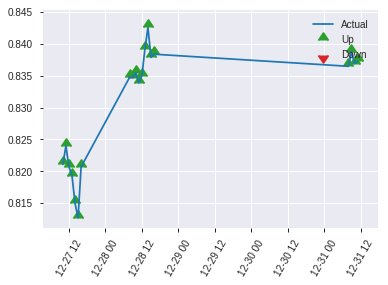


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3027496549050735
RMSE: 0.5502269121962988
LogLoss: 0.8238303877054329
Mean Per-Class Error: 0.4235909822866345
AUC: 0.5505636070853462
pr_auc: 0.5030010207071272
Gini: 0.10112721417069248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.608677977558076: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   99   0.8609   (99.0/115.0)
1      6    102  0.0556   (6.0/108.0)
Total  22   201  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.608678     0.660194  200
max f2                       0.519559     0.828221  219
max f0point5                 0.670956     0.574866  159
max accuracy                 0.670956     0.569507  159
max precision                0.87504      0.6       4
max recall                   0.519559     1         219
max specificity              0.883505     0.991304  0
max absolute_mcc             0.670956     0.169631  159
max min_per_class_accuracy   0.719165     0.518519  109
max mean_per_class_accuracy  0.670956     0.576409  159

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 71.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.87885            0.688272  0.688272           0.333333         0.880974  0.333333                    0.880974            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.87478            2.06481   1.23889            1                0.876446  0.6                         0.879163            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.874136           0         0.884921           0                0.874314  0.428571                    0.877777            0               0.0277778                  -100      -11.5079
    4        0.0403587                   0.872331           1.03241   0.917695           0.5              0.873755  0.444444                    0.876884            0.00925926      0.037037                   3.24074   -8.23045
    5        0.0538117                   0.870179           0.688272  0.86034            0.333333         0.870993  0.416667                    0.875411            0.00925926      0.0462963                  -31.1728  -13.966
    6        0.103139                    0.85641            0.938552  0.897746           0.454545         0.862984  0.434783                    0.869467            0.0462963       0.0925926                  -6.14478  -10.2254
    7        0.152466                    0.837062           1.31397   1.03241            0.636364         0.843557  0.5                         0.861085            0.0648148       0.157407                   31.3973   3.24074
    8        0.201794                    0.785443           1.31397   1.10123            0.636364         0.817074  0.533333                    0.850326            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.746245           0.844697  1.017              0.409091         0.756999  0.492537                    0.819682            0.0833333       0.305556                   -15.5303  1.69983
    10       0.399103                    0.734979           1.03241   1.02081            0.5              0.7415    0.494382                    0.800356            0.101852        0.407407                   3.24074   2.08073
    11       0.502242                    0.71806            1.07729   1.03241            0.521739         0.727272  0.5                         0.785348            0.111111        0.518519                   7.72947   3.24074
    12       0.600897                    0.694714           1.31397   1.07863            0.636364         0.70672   0.522388                    0.772439            0.12963         0.648148                   31.3973   7.86346
    13       0.699552                    0.674924           1.12626   1.08535            0.545455         0.683625  0.525641                    0.759914            0.111111        0.759259                   12.6263   8.53514
    14       0.798206                    0.644925           0.844697  1.05561            0.409091         0.660199  0.511236                    0.747589            0.0833333       0.842593                   -15.5303  5.56076
    15       0.896861                    0.609              0.938552  1.04273            0.454545         0.630955  0.505                       0.73476             0.0925926       0.935185                   -6.14478  4.27315
    16       1                           0.499964           0.628422  1                  0.304348         0.554788  0.484305                    0.716197     

This function is available for GLM models only


--2019-08-27 17:10:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_164803_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_164803_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'OBV',
 'HT_TRENDMODE',
 'AD',
 'CORREL_8',
 'day',
 'CDLSTALLEDPATTERN',
 'aroonup_8',
 'dayofweek',
 'STOCHRSI_fastk',
 'aroondown_24',
 'weekday',
 'MFI_14',
 'aroonup_12',
 'CORREL_12',
 'weekday_name',
 'CDLHOMINGPIGEON',
 'BOP',
 'BETA_20',
 'HT_DCPERIOD',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'aroonup_30',
 'AROONOSC_30',
 'SAREXT',
 'BETA_8',
 'CORREL_20',
 'aroondown_20',
 'BETA_30',
 'CDLLADDERBOTTOM',
 'BETA_24',
 'aroondown_8',
 'aroondown_30',
 'CDL3BLACKCROWS',
 'DX_8',
 'aroondown_12',
 'CDLSPINNINGTOP',
 'aroondown_14',
 'aroonup_14',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'CORREL_30',
 'CDLDOJI',
 'CDLUNIQUE3RIVER',
 'Volume',
 'CDLEVENINGSTAR',
 'STOCHF_fastk',
 'AROONOSC_12',
 'HT_PHASOR_quadrature',
 'MFI_12',
 'aroonup_20',
 'DIV',
 'aroonup_24',
 'CDLIDENTICAL3CROWS',
 'days_in_month',
 'AROONOSC_24',
 'AROONOSC_20',
 'CDLLONGLEGGEDDOJI',
 'FLOOR',
 'CORREL_14',
 'CDLTASUKIGAP',
 'ADXR_12',
 'BETA_12',
 'DX_30',
 'is_month_end',
 'ADXR_14',
 'CDLGAPSIDESI

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_171036_model_1  0.578422  0.695637              0.457931  0.501239  0.251241

variable  relative_importance  scaled_importance  percentage
0                           AD             0.008672           1.000000    0.017075
1                    CORREL_30             0.006635           0.765114    0.013064
2               CDLEVENINGSTAR             0.006632           0.764793    0.013058
3            CDLSTALLEDPATTERN             0.006540           0.754193    0.012878
4                      BETA_30             0.006210           0.716138    0.012228
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_14_1_2             0.000000           0.000000    0.000000
1033  BBANDS_middleband_14_1_3             0.000000           0.000000    0.000000
1034  BBANDS_middleband_14_1_4             0.000000           0.000000    0.000000
1035  BBANDS_middleband_14_1_5             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000

[1037 rows x 4 columns]

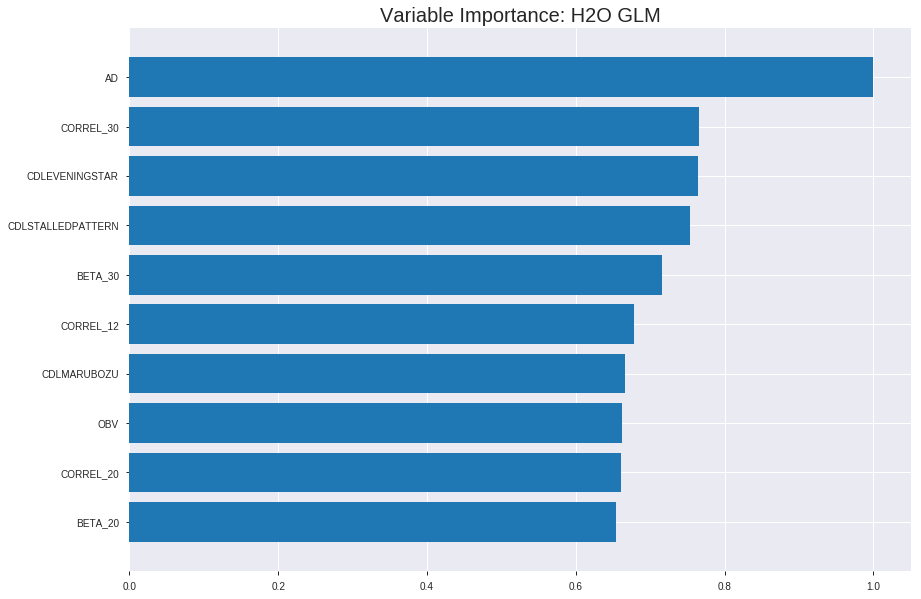

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_171036_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24693796272670532
RMSE: 0.49692852879131955
LogLoss: 0.6870088256200565
Null degrees of freedom: 1555
Residual degrees of freedom: 527
Null deviance: 2155.940212106897
Residual deviance: 2137.971465329616
AIC: 4195.971465329616
AUC: 0.5992199628663968
pr_auc: 0.6113966890180089
Gini: 0.19843992573279357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4782635029850976: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   742   0.9802   (742.0/757.0)
1      4    795   0.005    (4.0/799.0)
Total  19   1537  0.4794   (746.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478264     0.680651  383
max f2                       0.471342     0.840885  393
max f0point5                 0.498329     0.592929  302
max accuracy                 0.513863     0.573907  204
max precision                0.585764     1         0
max recall                   0.465573     1         398
max specificity              0.585764     1         0
max absolute_mcc             0.520796     0.151208  159
max min_per_class_accuracy   0.512035     0.568032  216
max mean_per_class_accuracy  0.513863     0.574933  204

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.558459           1.58229   1.58229            0.8125           0.565981  0.8125                      0.565981            0.0162703       0.0162703                  58.229    58.229
    2        0.0205656                   0.551784           1.58229   1.58229            0.8125           0.555243  0.8125                      0.560612            0.0162703       0.0325407                  58.229    58.229
    3        0.0302057                   0.548635           1.68778   1.61596            0.866667         0.550217  0.829787                    0.557294            0.0162703       0.048811                   68.7776   61.5956
    4        0.0404884                   0.546248           1.33886   1.54558            0.6875           0.547473  0.793651                    0.5548              0.0137672       0.0625782                  33.8861   54.5583
    5        0.0501285                   0.544709           1.03863   1.44809            0.533333         0.545429  0.74359                     0.552998            0.0100125       0.0725907                  3.86316   44.8092
    6        0.100257                    0.536878           1.24836   1.34822            0.641026         0.540103  0.692308                    0.546551            0.0625782       0.135169                   24.8355   34.8224
    7        0.150386                    0.531843           1.22339   1.30661            0.628205         0.534335  0.67094                     0.542479            0.0613267       0.196496                   22.3388   30.6612
    8        0.200514                    0.528059           1.12352   1.26084            0.576923         0.529991  0.647436                    0.539357            0.0563204       0.252816                   12.352    26.0839
    9        0.300129                    0.521888           1.1182    1.2135             0.574194         0.524466  0.623126                    0.534414            0.111389        0.364205                   11.8204   21.3498
    10       0.400386                    0.517073           1.02365   1.16596            0.525641         0.519431  0.598716                    0.530662            0.102628        0.466834                   2.36514   16.596
    11       0.5                         0.512174           1.00513   1.13392            0.516129         0.514526  0.582262                    0.527448            0.100125        0.566959                   0.512738  13.3917
    12       0.600257                    0.507864           0.873849  1.09048            0.448718         0.510075  0.559957                    0.524546            0.0876095       0.654568                   -12.6151  9.04798
    13       0.699871                    0.503635           0.967435  1.07297            0.496774         0.505818  0.550964                    0.52188             0.0963705       0.750939                   -3.25649  7.29666
    14       0.800129                    0.498614           1.03613   1.06835            0.532051         0.500942  0.548594                    0.519257            0.10388         0.854819                   3.61349   6.83515
    15       0.899743                    0.491935           0.703589  1.02797            0.36129          0.495352  0.527857                    0.51661             0.0700876       0.924906                   -29.6411  2.79671
    16       1                           0.457779           0.749013  1                  0.384615         0.48555   0.513496                    0.513496            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24981842175325378
RMSE: 0.49981838877061513
LogLoss: 0.6927809569455985
Null degrees of freedom: 443
Residual degrees of freedom: -585
Null deviance: 615.9463007458467
Residual deviance: 615.1894897676915
AIC: 2673.1894897676916
AUC: 0.5193981697542763
pr_auc: 0.5200068189413309
Gini: 0.03879633950855266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46710467031731173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467105     0.664662  399
max f2                       0.467105     0.832078  399
max f0point5                 0.491963     0.560976  362
max accuracy                 0.535155     0.533784  40
max precision                0.57996      1         0
max recall                   0.467105     1         399
max specificity              0.57996      1         0
max absolute_mcc             0.535155     0.107024  40
max min_per_class_accuracy   0.51477      0.506726  200
max mean_per_class_accuracy  0.535155     0.531979  40

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.552673           1.20543   1.20543            0.6              0.565597  0.6                         0.565597            0.0135747       0.0135747                  20.543    20.543
    2        0.0202703                   0.54656            1.50679   1.33937            0.75             0.549799  0.666667                    0.558576            0.0135747       0.0271493                  50.6787   33.9367
    3        0.0315315                   0.543271           0.40181   1.00452            0.2              0.544976  0.5                         0.553719            0.00452489      0.0316742                  -59.819   0.452489
    4        0.0405405                   0.542108           1.50679   1.11614            0.75             0.54298   0.555556                    0.551332            0.0135747       0.0452489                  50.6787   11.6139
    5        0.0518018                   0.540916           1.60724   1.2229             0.8              0.541442  0.608696                    0.549182            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.534856           1.36981   1.29472            0.681818         0.538141  0.644444                    0.543784            0.0678733       0.131222                   36.9807   29.4721
    7        0.150901                    0.531166           0.639243  1.07949            0.318182         0.53256   0.537313                    0.540099            0.0316742       0.162896                   -36.0757  7.94894
    8        0.20045                     0.528699           0.913204  1.03839            0.454545         0.529846  0.516854                    0.537564            0.0452489       0.208145                   -8.67956  3.83853
    9        0.29955                     0.522813           1.00452   1.02718            0.5              0.525149  0.511278                    0.533457            0.0995475       0.307692                   0.452489  2.71833
    10       0.400901                    0.517971           1.02685   1.0271             0.511111         0.520346  0.511236                    0.530142            0.104072        0.411765                   2.68477   2.70985
    11       0.5                         0.514718           0.958865  1.01357            0.477273         0.516441  0.504505                    0.527427            0.0950226       0.506787                   -4.11353  1.35747
    12       0.599099                    0.511451           0.958865  1.00452            0.477273         0.513058  0.5                         0.52505             0.0950226       0.60181                    -4.11353  0.452489
    13       0.70045                     0.507517           1.02685   1.00775            0.511111         0.50963   0.501608                    0.522819            0.104072        0.705882                   2.68477   0.775487
    14       0.79955                     0.502289           1.18717   1.02999            0.590909         0.505103  0.512676                    0.520623            0.117647        0.823529                   18.7166   2.99917
    15       0.898649                    0.493126           0.867544  1.01208            0.431818         0.498019  0.503759                    0.51813             0.0859729       0.909502                   -13.2456  1.20777
    16       1                           0.467105           0.892911  1                  0.444444         0.485473  0.497748                    0.514821         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:10:39  0.000 sec   2            3.9       1029          1.37402           1.38556
    2019-08-27 17:10:41  1.874 sec   4            2.8       1029          1.37085           1.38581
    2019-08-27 17:10:43  3.724 sec   6            2.1       1031          1.36702           1.38627
    2019-08-27 17:10:44  5.576 sec   8            1.5       1037          1.36249           1.38713
    2019-08-27 17:10:46  7.400 sec   10           1.1       1037          1.35727           1.38853
    2019-08-27 17:10:48  9.250 sec   12           0.79      1038          1.35143           1.39067

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.662379421221865)

('auc', 0.5784219001610306)

('logloss', 0.6956365067634369)

('mean_per_class_error', 0.39851046698872783)

('rmse', 0.5012392508149394)

('mse', 0.2512407865575217)

glm prediction progress: |████████████████████████████████████████████████| 100%


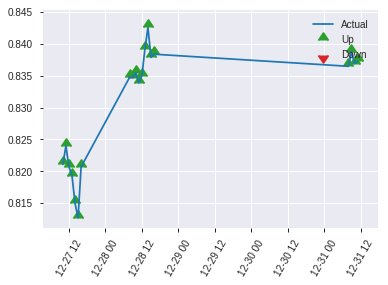


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2512407865575217
RMSE: 0.5012392508149394
LogLoss: 0.6956365067634369
Null degrees of freedom: 222
Residual degrees of freedom: -806
Null deviance: 309.68415973716924
Residual deviance: 310.25388201649287
AIC: 2368.2538820164928
AUC: 0.5784219001610306
pr_auc: 0.523991395903372
Gini: 0.15684380032206113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5204949809735862: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   100  0.8696   (100.0/115.0)
1      5    103  0.0463   (5.0/108.0)
Total  20   203  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520495     0.662379  202
max f2                       0.514708     0.825688  221
max f0point5                 0.535903     0.589789  114
max accuracy                 0.535903     0.600897  114
max precision                0.56437      0.714286  6
max recall                   0.514708     1         221
max specificity              0.5714       0.991304  0
max absolute_mcc             0.535903     0.202979  114
max min_per_class_accuracy   0.536716     0.592593  109
max mean_per_class_accuracy  0.535903     0.60149   114

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 53.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.569392           0.688272  0.688272           0.333333         0.57045   0.333333                    0.57045             0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.566774           2.06481   1.23889            1                0.567989  0.6                         0.569466            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.564212           2.06481   1.47487            1                0.565184  0.714286                    0.568242            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.562739           1.03241   1.37654            0.5              0.563657  0.666667                    0.567223            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.561673           0         1.03241            0                0.562373  0.5                         0.566011            0               0.0555556                  -100      3.24074
    6        0.103139                    0.556193           0.750842  0.897746           0.363636         0.558975  0.434783                    0.562646            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.552449           1.12626   0.971678           0.545455         0.554001  0.470588                    0.559849            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.549319           1.50168   1.10123            0.727273         0.550648  0.533333                    0.5576              0.0740741       0.222222                   50.1684   10.1235
    9        0.300448                    0.543565           0.938552  1.04782            0.454545         0.546873  0.507463                    0.554078            0.0925926       0.314815                   -6.14478  4.78165
    10       0.399103                    0.538714           1.59554   1.18321            0.772727         0.541307  0.573034                    0.550921            0.157407        0.472222                   59.5539   18.3208
    11       0.502242                    0.536307           1.25684   1.19833            0.608696         0.537475  0.580357                    0.54816             0.12963         0.601852                   25.6844   19.833
    12       0.600897                    0.533161           0.750842  1.12486            0.363636         0.534783  0.544776                    0.545963            0.0740741       0.675926                   -24.9158  12.4862
    13       0.699552                    0.52981            0.656987  1.05888            0.318182         0.531677  0.512821                    0.543949            0.0648148       0.740741                   -34.3013  5.88794
    14       0.798206                    0.525713           1.03241   1.05561            0.5              0.528077  0.511236                    0.541987            0.101852        0.842593                   3.24074   5.56076
    15       0.896861                    0.520559           1.03241   1.05306            0.5              0.522959  0.51                        0.539894            0.101852        0.944444                   3.24074   5.30556
    16       1                           0.500034           0.538647  1                  0.26087          0.517442  0.484305                    0.537578       

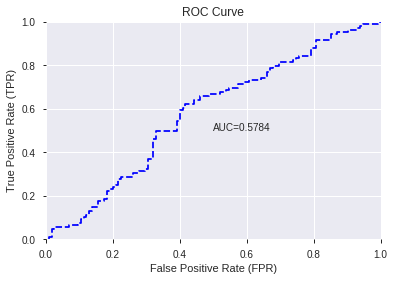

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


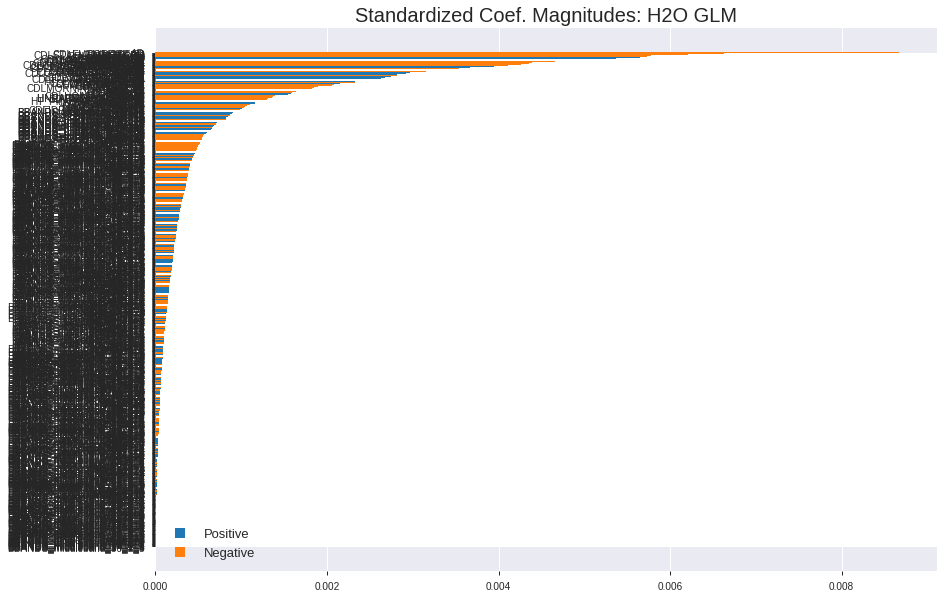

'log_likelihood'
--2019-08-27 17:11:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_171036_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_171036_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['AD',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'BETA_30',
 'CORREL_12',
 'CDLMARUBOZU',
 'OBV',
 'CORREL_20',
 'BETA_20',
 'CDLHIGHWAVE',
 'CDL3INSIDE',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLMATCHINGLOW',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'CORREL_24',
 'aroonup_8',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'BETA_24',
 'aroondown_24',
 'CORREL_14',
 'CDLTHRUSTING',
 'CDLTASUKIGAP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'MFI_30',
 'hour',
 'CDLINVERTEDHAMMER',
 'CDLHARAMICROSS',
 'BETA_14',
 'is_month_start',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'CDLUNIQUE3RIVER',
 'AROONOSC_24',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'MFI_24',
 'VAR_8',
 'quarter',
 'CDLDOJI',
 'aroonup_12',
 'MFI_20',
 'STOCHF_fastk',
 'BOP',
 'AROONOSC_8',
 'CDL3BLACKCROWS',
 'AROONOSC_30',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'month',
 'aroonup_30',
 'VAR_20',
 'HT_PHASOR_inphase',
 'MFI_8',
 'dayofyear',
 'week',
 'weekofyear',
 'CDLMORNI

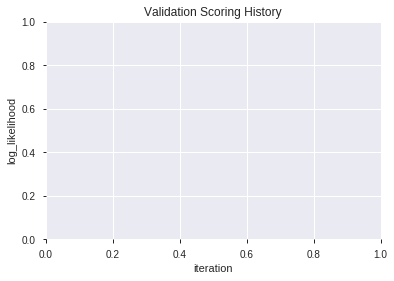

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_171123_model_5  0.588164  0.687032              0.482609  0.496798  0.246808
1  XGBoost_grid_1_AutoML_20190827_171123_model_3  0.572705  0.686515              0.461151  0.496672  0.246683
2  XGBoost_grid_1_AutoML_20190827_171123_model_6  0.553623  0.691926              0.478824  0.499237  0.249237
3  XGBoost_grid_1_AutoML_20190827_171123_model_1  0.545692  0.693211              0.452174  0.499942  0.249942
4               XGBoost_3_AutoML_20190827_171123  0.544605  0.690127              0.475040  0.498549  0.248551
5  XGBoost_grid_1_AutoML_20190827_171123_model_4  0.536111  0.695404              0.475040  0.501021  0.251022
6  XGBoost_grid_1_AutoML_20190827_171123_model_2  0.522625  0.696652              0.449235  0.501672  0.251675
7  XGBoost_grid_1_AutoML_20190827_171123_model_7  0.507729  0.716003              0.487520  0.510503  0.260614
8               XGBoost_1_AutoML_20190827_171123  0.500161  0.706774              0.478543  0.506694  0.256739
9               XGBoost_2_AutoML_20190827_171123  0.495813  0.711289              0.495652  0.508619  0.258694

variable  relative_importance  scaled_importance  percentage
0                     Volume           451.518982           1.000000    0.021026
1                        BOP           358.503296           0.793994    0.016695
2                       Open           340.492889           0.754105    0.015856
3                       High           230.243698           0.509931    0.010722
4                      CCI_8           223.402054           0.494779    0.010403
..                       ...                  ...                ...         ...
650                  MA_14_0             1.189709           0.002635    0.000055
651  BBANDS_lowerband_14_1_4             1.188967           0.002633    0.000055
652   BBANDS_upperband_8_5_4             1.130653           0.002504    0.000053
653  BBANDS_lowerband_12_3_4             1.089744           0.002414    0.000051
654  BBANDS_middleband_8_5_2             0.228620           0.000506    0.000011

[655 rows x 4 columns]

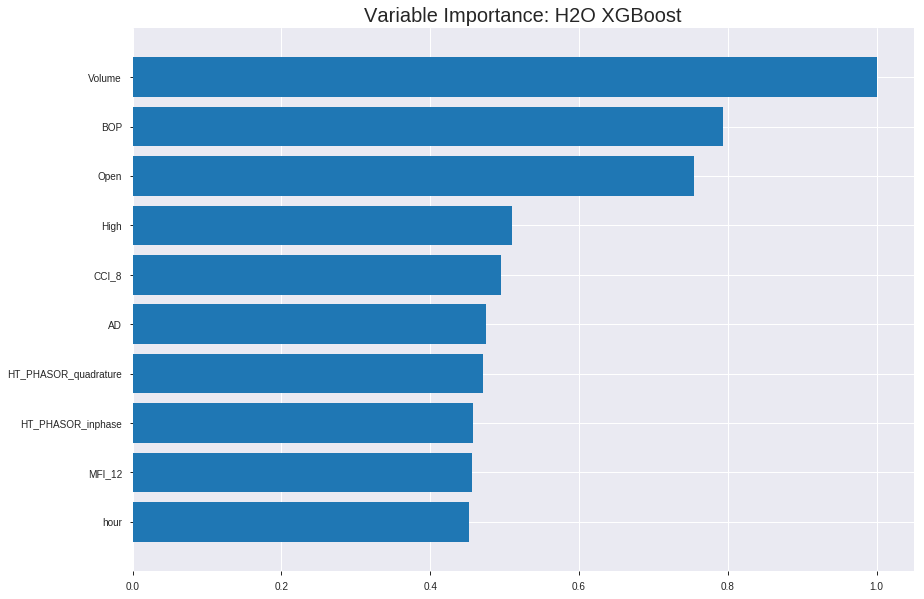

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_171123_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.040673970103633286
RMSE: 0.20167788699714526
LogLoss: 0.21517744454995225
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9974968710888611
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5376829206943512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      757  0    0        (0.0/757.0)
1      0    799  0        (0.0/799.0)
Total  757  799  0        (0.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.537683     1        193
max f2                       0.537683     1        193
max f0point5                 0.537683     1        193
max accuracy                 0.537683     1        193
max precision                0.930153     1        0
max recall                   0.537683     1        193
max specificity              0.930153     1        0
max absolute_mcc             0.537683     1        193
max min_per_class_accuracy   0.537683     1        193
max mean_per_class_accuracy  0.537683     1        193

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.908572           1.94743   1.94743            1                0.917728  1                           0.917728            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.900263           1.94743   1.94743            1                0.903172  1                           0.91045             0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.893446           1.94743   1.94743            1                0.896018  1                           0.905844            0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.888351           1.94743   1.94743            1                0.890844  1                           0.902034            0.020025        0.0788486                  94.7434   94.7434
    5        0.0501285                   0.885045           1.94743   1.94743            1                0.886856  1                           0.899115            0.0187735       0.097622                   94.7434   94.7434
    6        0.100257                    0.868476           1.94743   1.94743            1                0.876401  1                           0.887758            0.097622        0.195244                   94.7434   94.7434
    7        0.150386                    0.853191           1.94743   1.94743            1                0.860396  1                           0.878638            0.097622        0.292866                   94.7434   94.7434
    8        0.200514                    0.836774           1.94743   1.94743            1                0.845012  1                           0.870231            0.097622        0.390488                   94.7434   94.7434
    9        0.300129                    0.807821           1.94743   1.94743            1                0.822466  1                           0.854378            0.193992        0.584481                   94.7434   94.7434
    10       0.400386                    0.767653           1.94743   1.94743            1                0.787971  1                           0.83775             0.195244        0.779725                   94.7434   94.7434
    11       0.5                         0.676605           1.94743   1.94743            1                0.73102   1                           0.816486            0.193992        0.973717                   94.7434   94.7434
    12       0.600257                    0.251134           0.262155  1.66595            0.134615         0.349004  0.85546                     0.738406            0.0262829       1                          -73.7845  66.5953
    13       0.699871                    0.206549           0         1.42883            0                0.225599  0.733701                    0.665416            0               1                          -100      42.8834
    14       0.800129                    0.169637           0         1.2498             0                0.188517  0.641767                    0.60566             0               1                          -100      24.9799
    15       0.899743                    0.133601           0         1.11143            0                0.152866  0.570714                    0.55553             0               1                          -100      11.1429
    16       1                           0.0744449          0         1                  0                0.111422  0.513496                    0.511005         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27064228352227687
RMSE: 0.5202329127633861
LogLoss: 0.7393166308555121
Mean Per-Class Error: 0.4732057707525922
AUC: 0.4941156179615689
pr_auc: 0.4888087985708035
Gini: -0.011768764076862226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15494941174983978: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    223  1        (223.0/223.0)
1      0    221  0        (0.0/221.0)
Total  0    444  0.5023   (223.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.154949     0.664662   399
max f2                       0.154949     0.832078   399
max f0point5                 0.318025     0.553466   367
max accuracy                 0.557363     0.527027   179
max precision                0.786707     0.8        4
max recall                   0.154949     1          399
max specificity              0.834821     0.995516   0
max absolute_mcc             0.684637     0.0810145  49
max min_per_class_accuracy   0.541606     0.511312   197
max mean_per_class_accuracy  0.557363     0.526794   179

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 52.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.780794           1.60724   1.60724            0.8              0.814151  0.8                         0.814151            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.754778           0.502262  1.11614            0.25             0.766818  0.555556                    0.793114            0.00452489      0.0226244                  -49.7738  11.6139
    3        0.0315315                   0.743358           0.80362   1.00452            0.4              0.748383  0.5                         0.777139            0.00904977      0.0316742                  -19.638   0.452489
    4        0.0405405                   0.737776           0.502262  0.892911           0.25             0.740395  0.444444                    0.768973            0.00452489      0.0361991                  -49.7738  -10.7089
    5        0.0518018                   0.727045           0.40181   0.78615            0.2              0.730726  0.391304                    0.760659            0.00452489      0.040724                   -59.819   -21.385
    6        0.101351                    0.699628           1.00452   0.892911           0.5              0.711027  0.444444                    0.736394            0.0497738       0.0904977                  0.452489  -10.7089
    7        0.150901                    0.671137           0.913204  0.899575           0.454545         0.683276  0.447761                    0.718952            0.0452489       0.135747                   -8.67956  -10.0425
    8        0.20045                     0.646715           1.00452   0.925517           0.5              0.656052  0.460674                    0.703404            0.0497738       0.18552                    0.452489  -7.44827
    9        0.29955                     0.604813           1.14151   0.996972           0.568182         0.627269  0.496241                    0.678217            0.113122        0.298643                   14.1506   -0.302793
    10       0.400901                    0.569389           1.11614   1.0271             0.555556         0.586521  0.511236                    0.655035            0.113122        0.411765                   11.6139   2.70985
    11       0.5                         0.539102           1.00452   1.02262            0.5              0.55589   0.509009                    0.635385            0.0995475       0.511312                   0.452489  2.26244
    12       0.599099                    0.500333           0.958865  1.01208            0.477273         0.519379  0.503759                    0.616196            0.0950226       0.606335                   -4.11353  1.20777
    13       0.70045                     0.465603           0.848265  0.988375           0.422222         0.480962  0.491961                    0.596628            0.0859729       0.692308                   -15.1735  -1.1625
    14       0.79955                     0.416236           1.05019   0.996036           0.522727         0.439497  0.495775                    0.577153            0.104072        0.79638                    5.01851   -0.396406
    15       0.898649                    0.3495             1.00452   0.996972           0.5              0.384418  0.496241                    0.555899            0.0995475       0.895928                   0.452489  -0.302793
    16       1                           0.154949           1.02685   1                  0.511111         0.284669  0.497748                    0.52840


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:11:54  15.903 sec  0                  0.5              0.693147            0.5             0                  1                0.486504                         0.5                0.693147              0.5               0                    1                  0.502252
    2019-08-27 17:11:56  17.444 sec  5                  0.448241         0.594187            0.968248        0.967719           1.94743          0.0835476                        0.501876           0.696929              0.502161          0.500393             0.40181            0.495495
    2019-08-27 17:11:56  18.127 sec  10                 0.404355         0.516454            0.993183        0.990118           1.94743          0.0392031                        0.505126           0.703625              0.486375          0.489016             1.20543            0.493243
    2019-08-27 17:11:57  18.856 sec  15                 0.363147         0.4481              0.998841        0.997647           1.94743          0.0128535                        0.508169           0.710141              0.483879          0.481646             1.20543            0.502252
    2019-08-27 17:11:58  19.544 sec  20                 0.331824         0.398611            0.99972         0.998485           1.94743          0.00771208                       0.510262           0.714863              0.487896          0.478161             0.80362            0.502252
    2019-08-27 17:11:59  20.240 sec  25                 0.305125         0.358199            0.999913        0.998667           1.94743          0.00514139                       0.511381           0.717842              0.498691          0.481275             0.40181            0.502252
    2019-08-27 17:11:59  21.010 sec  30                 0.277541         0.318008            0.999945        0.998696           1.94743          0.00321337                       0.511709           0.719081              0.505539          0.492667             0.80362            0.502252
    2019-08-27 17:12:00  21.715 sec  35                 0.256174         0.287538            0.999972        0.998722           1.94743          0.00192802                       0.514005           0.724381              0.501431          0.488201             0.40181            0.502252
    2019-08-27 17:12:01  22.437 sec  40                 0.236951         0.261006            0.999993        0.998742           1.94743          0.00128535                       0.515048           0.726892              0.500933          0.492758             0.80362            0.502252
    2019-08-27 17:12:01  23.178 sec  45                 0.219126         0.237512            0.999998        0.998747           1.94743          0.000642674                      0.517809           0.733368              0.496753          0.493069             1.60724            0.502252
    2019-08-27 17:12:02  23.951 sec  50                 0.201678         0.215177            1               0.997497           1.94743          0                                0.520233           0.739317              0.494116          0.488809             1.60724            0.502252

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   451.51898193359375     1.0                    0.021026157194278458
BOP                      358.5032958984375      0.7939938524027849     0.016694639551911684
Open                     340.4928894042969      0.7541053710436789     0.015855938072614074
High                     230.2436981201172      0.5099313812547084     0.010721897380557038
CCI_8                    223.4020538330078      0.4947788748023538     0.010403298398002511
---                      ---                    ---                    ---
MA_14_0                  1.1897088289260864     0.002634903241124557   5.540188973959873e-05
BBANDS_lowerband_14_1_4  1.1889667510986328     0.0026332597269930454  5.536733295311855e-05
BBANDS_upperband_8_5_4   1.130652666091919      0.002504108822291346   5.2651785729077336e-05
BBANDS_lowerband_12_3_4  1.0897443294525146     0.00241350723459238    5.074678250406768e-05
BBANDS_middleband_8_5_2  0.22862038016319275    0.000506336143796534   1.0646303352610705e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6605504587155963)

('auc', 0.5881642512077294)

('logloss', 0.687031719045957)

('mean_per_class_error', 0.4035829307568438)

('rmse', 0.4967975021317255)

('mse', 0.24680775812432182)

xgboost prediction progress: |████████████████████████████████████████████| 100%


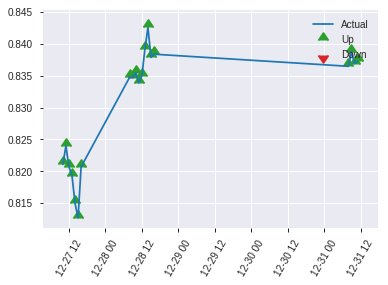


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24680775812432182
RMSE: 0.4967975021317255
LogLoss: 0.687031719045957
Mean Per-Class Error: 0.4035829307568438
AUC: 0.5881642512077294
pr_auc: 0.5606437280349916
Gini: 0.17632850241545883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28595954179763794: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      0    108  0        (0.0/108.0)
Total  4    219  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28596      0.66055   218
max f2                       0.28596      0.829493  218
max f0point5                 0.516039     0.578231  119
max accuracy                 0.578847     0.600897  76
max precision                0.741828     0.8       4
max recall                   0.28596      1         218
max specificity              0.772146     0.991304  0
max absolute_mcc             0.578847     0.202093  76
max min_per_class_accuracy   0.527931     0.556522  111
max mean_per_class_accuracy  0.576192     0.596417  78

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.749793           1.37654   1.37654            0.666667         0.76302   0.666667                    0.76302             0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.737391           2.06481   1.65185            1                0.7444    0.8                         0.755572            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.726901           0         1.17989            0                0.729719  0.571429                    0.748186            0               0.037037                   -100      17.9894
    4        0.0403587                   0.722584           2.06481   1.37654            1                0.725585  0.666667                    0.743163            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.714284           1.37654   1.37654            0.666667         0.71803   0.666667                    0.73688             0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.681473           1.31397   1.34662            0.636364         0.698196  0.652174                    0.718379            0.0648148       0.138889                   31.3973   34.6618
    7        0.152466                    0.656856           1.12626   1.27533            0.545455         0.664986  0.617647                    0.701105            0.0555556       0.194444                   12.6263   27.5327
    8        0.201794                    0.631229           0.938552  1.193              0.454545         0.641844  0.577778                    0.686619            0.0462963       0.240741                   -6.14478  19.3004
    9        0.300448                    0.594217           1.31397   1.23273            0.636364         0.609529  0.597015                    0.661306            0.12963         0.37037                    31.3973   23.2725
    10       0.399103                    0.564072           0.938552  1.16001            0.454545         0.57714   0.561798                    0.640501            0.0925926       0.462963                   -6.14478  16.0008
    11       0.502242                    0.527931           0.98752   1.12459            0.478261         0.544506  0.544643                    0.620787            0.101852        0.564815                   -1.24799  12.4587
    12       0.600897                    0.492905           0.844697  1.07863            0.409091         0.507854  0.522388                    0.602246            0.0833333       0.648148                   -15.5303  7.86346
    13       0.699552                    0.451684           1.12626   1.08535            0.545455         0.473511  0.525641                    0.584091            0.111111        0.759259                   12.6263   8.53514
    14       0.798206                    0.408608           0.656987  1.03241            0.318182         0.432215  0.5                         0.56532             0.0648148       0.824074                   -34.3013  3.24074
    15       0.896861                    0.345473           1.12626   1.04273            0.545455         0.383066  0.505                       0.545272            0.111111        0.935185                   12.6263   4.27315
    16       1                           0.233116           0.628422  1                  0.304348         0.308451  0.484305                    0.520847         

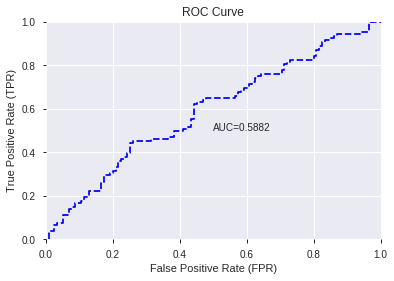

This function is available for GLM models only


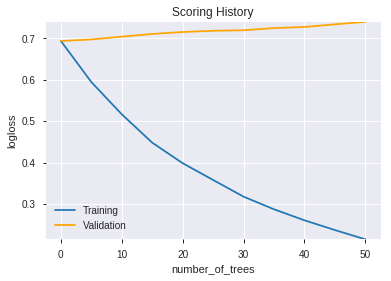

--2019-08-27 17:12:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_171123_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_171123_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'BOP',
 'Open',
 'High',
 'CCI_8',
 'AD',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'MFI_12',
 'hour',
 'BETA_8',
 'TRANGE',
 'MFI_14',
 'BETA_14',
 'STOCHRSI_fastd',
 'DX_8',
 'CORREL_12',
 'WILLR_8',
 'MOM_14',
 'DIV',
 'ADOSC',
 'MFI_20',
 'MOM_8',
 'SAREXT',
 'STOCHF_fastk',
 'BETA_20',
 'MFI_8',
 'CORREL_30',
 'CCI_12',
 'ADX_8',
 'MFI_30',
 'ATR_8',
 'MINUS_DM_30',
 'OBV',
 'day',
 'STDDEV_8',
 'WILLR_24',
 'Close',
 'ADXR_12',
 'MFI_24',
 'BETA_30',
 'ULTOSC',
 'CORREL_14',
 'ADXR_8',
 'CCI_20',
 'STOCH_slowk',
 'DX_12',
 'MACDEXT_hist',
 'PLUS_DI_8',
 'BETA_24',
 'BETA_12',
 'ADX_12',
 'ROC_12',
 'ROC_30',
 'MINUS_DM_8',
 'STOCH_slowd',
 'PLUS_DM_8',
 'STDDEV_20',
 'CCI_14',
 'MINUS_DM_12',
 'SUB',
 'aroondown_24',
 'MOM_30',
 'CORREL_24',
 'WILLR_12',
 'ADXR_14',
 'WILLR_20',
 'MOM_20',
 'WILLR_30',
 'LINEARREG_ANGLE_20',
 'DX_30',
 'MACDFIX_hist_8',
 'CORREL_20',
 'DX_14',
 'HT_DCPERIOD',
 'MINUS_DI_8',
 'MACDEXT_signal',
 'MOM_24',
 'ROC_8',
 'CCI_30',
 'CM

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

62

['BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_1_3',
 'BBANDS_lowerband_24_7_4',
 'BOP',
 'ADX_8',
 'aroondown_8',
 'MINUS_DI_8',
 'ROC_8',
 'ADX_12',
 'CCI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROCR100_12',
 'AROONOSC_14',
 'CMO_14',
 'MFI_14',
 'MINUS_DM_14',
 'ROC_14',
 'ROCR_14',
 'RSI_14',
 'WILLR_14',
 'ADX_20',
 'aroondown_20',
 'MACDFIX_hist_20',
 'MOM_20',
 'PLUS_DM_20',
 'aroondown_24',
 'MACDFIX_hist_24',
 'MFI_24',
 'MOM_24',
 'PLUS_DI_24',
 'ROCP_24',
 'ROCR_24',
 'WILLR_24',
 'DX_30',
 'MFI_30',
 'MINUS_DM_30',
 'MOM_30',
 'ROCP_30',
 'ROCR100_30',
 'MACDEXT',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'ULTOSC',
 'AD',
 'ADOSC',
 'ATR_12',
 'ATR_20',
 'ATR_30',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'LINEARREG_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_INTERCEPT_8',
 'LINEARREG_SLOPE_8',
 'STDDEV_8',
 'VAR_8',
 'BETA_12',
 'CORREL_12',
 'LINEARREG_ANGLE_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_171332_model_9  0.566868  0.697211              0.453583  0.501976  0.251980
1               DeepLearning_1_AutoML_20190827_171332  0.557246  0.961356              0.424275  0.543158  0.295020
2  DeepLearning_grid_1_AutoML_20190827_171332_model_6  0.554589  0.730872              0.500000  0.513403  0.263583
3  DeepLearning_grid_1_AutoML_20190827_171332_model_3  0.553382  1.058540              0.448390  0.583644  0.340640
4  DeepLearning_grid_1_AutoML_20190827_171332_model_5  0.543519  0.753055              0.500000  0.520424  0.270841
5  DeepLearning_grid_1_AutoML_20190827_171332_model_2  0.532448  1.037405              0.449799  0.582252  0.339017
6  DeepLearning_grid_1_AutoML_20190827_171332_model_7  0.528261  0.717725              0.491304  0.511366  0.261495
7  DeepLearning_grid_1_AutoML_20190827_171332_model_1  0.504992  1.224631              0.500000  0.606000  0.367236
8  DeepLearning_grid_1_AutoML_20190827_171332_model_8  0.504348  0.692690              0.495652  0.499771  0.249771
9  DeepLearning_grid_1_AutoML_20190827_171332_model_4  0.500805  1.296591              0.491304  0.627966  0.394341

variable  relative_importance  scaled_importance  percentage
0            CORREL_12             1.000000           1.000000    0.023811
1                   AD             0.979801           0.979801    0.023330
2         aroondown_24             0.903975           0.903975    0.021525
3                  BOP             0.830493           0.830493    0.019775
4               MFI_24             0.786327           0.786327    0.018723
..                 ...                  ...                ...         ...
57               ROC_8             0.609061           0.609061    0.014502
58              RSI_14             0.608556           0.608556    0.014490
59              ULTOSC             0.608035           0.608035    0.014478
60              ROC_14             0.605510           0.605510    0.014418
61  LINEARREG_ANGLE_12             0.579892           0.579892    0.013808

[62 rows x 4 columns]

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_171332_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24748883533919575
RMSE: 0.49748249752046125
LogLoss: 0.6880838351223952
Mean Per-Class Error: 0.45576372711596225
AUC: 0.5569114629746893
pr_auc: 0.5655635857493759
Gini: 0.1138229259493786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640587782870435: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   739   0.9762   (739.0/757.0)
1      3    796   0.0038   (3.0/799.0)
Total  21   1535  0.4769   (742.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464059     0.682091  387
max f2                       0.464059     0.84126   387
max f0point5                 0.494858     0.576282  318
max accuracy                 0.510898     0.543059  262
max precision                0.684711     1         0
max recall                   0.458697     1         396
max specificity              0.684711     1         0
max absolute_mcc             0.548486     0.103359  155
max min_per_class_accuracy   0.50512      0.535007  280
max mean_per_class_accuracy  0.510898     0.544236  262

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102828                   0.634141           1.46058   1.46058            0.75             0.650963  0.75                        0.650963            0.0150188       0.0150188                  46.0576    46.0576
    2        0.0205656                   0.623662           0.973717  1.21715            0.5              0.627828  0.625                       0.639395            0.0100125       0.0250313                  -2.62829   21.7146
    3        0.0302057                   0.614204           1.03863   1.16017            0.533333         0.618394  0.595745                    0.632693            0.0100125       0.0350438                  3.86316    16.0174
    4        0.0404884                   0.608768           1.46058   1.23647            0.75             0.611207  0.634921                    0.627236            0.0150188       0.0500626                  46.0576    23.6466
    5        0.0501285                   0.603867           1.42812   1.27332            0.733333         0.606241  0.653846                    0.623198            0.0137672       0.0638298                  42.8118    27.3322
    6        0.100257                    0.579746           1.02365   1.14849            0.525641         0.590959  0.589744                    0.607079            0.0513141       0.115144                   2.36514    14.8487
    7        0.150386                    0.565297           1.27332   1.1901             0.653846         0.572138  0.611111                    0.595432            0.0638298       0.178974                   27.3322    19.0099
    8        0.200514                    0.552024           1.17345   1.18594            0.602564         0.558109  0.608974                    0.586101            0.0588235       0.237797                   17.3454    18.5938
    9        0.300129                    0.537427           0.979999  1.11759            0.503226         0.544113  0.573876                    0.572165            0.097622        0.335419                   -2.00008   11.7585
    10       0.400386                    0.521075           0.986201  1.08469            0.50641          0.529968  0.556982                    0.561599            0.0988736       0.434293                   -1.37993   8.46865
    11       0.5                         0.505058           0.992563  1.06633            0.509677         0.512207  0.547558                    0.551758            0.0988736       0.533166                   -0.743672  6.63329
    12       0.796272                    0.502549           0.967381  1.02952            0.496746         0.502666  0.528652                    0.533492            0.286608        0.819775                   -3.26194   2.95153
    13       0.800129                    0.502297           0         1.02455            0                0.502418  0.526104                    0.533342            0               0.819775                   -100       2.45538
    14       0.899743                    0.491489           0.992563  1.02101            0.509677         0.498674  0.524286                    0.529504            0.0988736       0.918648                   -0.743672  2.1012
    15       1                           0.450677           0.811431  1                  0.416667         0.477051  0.513496                    0.524245            0.0813517       1                          -18.8569   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24929884951679693
RMSE: 0.4992983572141981
LogLoss: 0.6917439026198235
Mean Per-Class Error: 0.4601789663778585
AUC: 0.5316742081447964
pr_auc: 0.5276023636469557
Gini: 0.06334841628959276
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46060647326464665: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    222  0.9955   (222.0/223.0)
1      0    221  0        (0.0/221.0)
Total  1    443  0.5      (222.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.460606     0.665663   277
max f2                       0.460606     0.832705   277
max f0point5                 0.474312     0.557884   256
max accuracy                 0.50275      0.540541   150
max precision                0.53701      0.621622   36
max recall                   0.460606     1          277
max specificity              0.574925     0.995516   0
max absolute_mcc             0.526885     0.0880198  58
max min_per_class_accuracy   0.50275      0.38009    150
max mean_per_class_accuracy  0.50275      0.539821   150

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.563709           0.80362   0.80362            0.4              0.568504  0.4                         0.568504            0.00904977      0.00904977                 -19.638   -19.638
    2        0.0202703                   0.554725           1.00452   0.892911           0.5              0.557549  0.444444                    0.563635            0.00904977      0.0180995                  0.452489  -10.7089
    3        0.0315315                   0.550987           1.20543   1.00452            0.6              0.552796  0.5                         0.559764            0.0135747       0.0316742                  20.543    0.452489
    4        0.0405405                   0.546812           1.50679   1.11614            0.75             0.547973  0.555556                    0.557144            0.0135747       0.0452489                  50.6787   11.6139
    5        0.0518018                   0.544858           1.60724   1.2229             0.8              0.545741  0.608696                    0.554665            0.0180995       0.0633484                  60.724    22.29
    6        0.101351                    0.532815           1.09585   1.16078            0.545455         0.538331  0.577778                    0.54668             0.0542986       0.117647                   9.58453   16.0784
    7        0.150901                    0.523656           1.18717   1.16945            0.590909         0.528235  0.58209                     0.540623            0.0588235       0.176471                   18.7166   16.9447
    8        0.20045                     0.514956           0.730564  1.06096            0.363636         0.51908   0.52809                     0.535298            0.0361991       0.21267                    -26.9436  6.09589
    9        0.29955                     0.504987           1.18717   1.10271            0.590909         0.511013  0.548872                    0.527264            0.117647        0.330317                   18.7166   10.2712
    10       0.716216                    0.502549           0.933937  1.00452            0.464865         0.502694  0.5                         0.51297             0.38914         0.719457                   -6.60633  0.452489
    11       0.79955                     0.496634           1.03167   1.00735            0.513514         0.50075   0.501408                    0.511697            0.0859729       0.80543                    3.16742   0.735453
    12       0.898649                    0.484039           1.05019   1.01208            0.522727         0.489945  0.503759                    0.509298            0.104072        0.909502                   5.01851   1.20777
    13       1                           0.449208           0.892911  1                  0.444444         0.473084  0.497748                    0.505628            0.0904977       1                          -10.7089  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:18:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:18:42  1 min 39.070 sec  559 obs/sec       0.737147  1             1147       0.549785         0.82155             -0.209935      0.519827        0.517946           0.730288         0.472365                         0.567918           0.872255              -0.290149        0.508553          0.51904              1.60724            0.502252
    2019-08-27 17:18:52  1 min 48.109 sec  880 obs/sec       5.82005   8             9056       0.501298         0.695749            -0.00593041    0.517616        0.520728           0.973717         0.482005                         0.501              0.695154              -0.00402566      0.476818          0.473964             0.80362            0.502252
    2019-08-27 17:19:00  1 min 56.867 sec  1055 obs/sec      12.3933   17            19284      0.501498         0.696156            -0.00673364    0.522779        0.535278           1.33886          0.481362                         0.501704           0.696575              -0.00684738      0.47417           0.489451             1.60724            0.502252
    2019-08-27 17:19:08  2 min  4.927 sec  1155 obs/sec      18.9788   26            29531      0.500861         0.694882            -0.00417962    0.538843        0.544764           0.973717         0.484576                         0.502457           0.698094              -0.00987173      0.452215          0.453288             0.40181            0.502252
    2019-08-27 17:19:17  2 min 13.123 sec  1311 obs/sec      27.7564   38            43189      0.499847         0.692842            -0.000117981   0.526938        0.574333           1.21715          0.486504                         0.500465           0.694079              -0.00188246      0.500162          0.500995             1.20543            0.502252
    2019-08-27 17:19:25  2 min 21.387 sec  1464 obs/sec      38.0379   52            59187      0.505186         0.703643            -0.0215975     0.530018        0.565307           1.58229          0.482648                         0.503556           0.700342              -0.0142961       0.497738          0.264595             0.999695           0.497748
    2019-08-27 17:19:33  2 min 29.596 sec  1547 obs/sec      47.5508   65            73989      0.497482         0.688084            0.00932287     0.556911        0.565564           1.46058          0.476864                         0.499298           0.691744              0.00278437       0.531674          0.527602             0.80362            0.5

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CORREL_12           1.0                    1.0                  0.02381112746493604
AD                  0.9798014760017395     0.9798014760017395   0.02333017783540989
aroondown_24        0.903975248336792      0.903975248336792    0.021524669863294564
BOP                 0.8304929733276367     0.8304929733276367   0.019774974046638086
MFI_24              0.78632652759552       0.78632652759552     0.018723321177637475
---                 ---                    ---                  ---
ROC_8               0.6090613603591919     0.6090613603591919   0.014502437685480062
RSI_14              0.6085556149482727     0.6085556149482727   0.014490395317035857
ULTOSC              0.6080347895622253     0.6080347895622253   0.014477993877381709
ROC_14              0.6055095791816711     0.6055095791816711   0.014417865771134554
LINEARREG_ANGLE_12  0.5798918604850769     0.5798918604850769   0.013807879005889073


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6645161290322581)

('auc', 0.5668679549114332)

('logloss', 0.6972112205746988)

('mean_per_class_error', 0.43313204508856684)

('rmse', 0.5019759329100212)

('mse', 0.25197983722088607)

deeplearning prediction progress: |███████████████████████████████████████| 100%


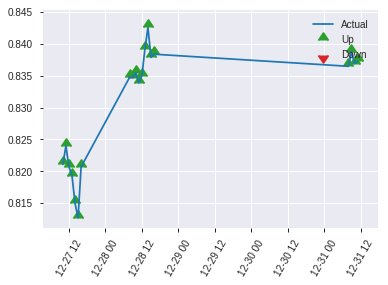


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25197983722088607
RMSE: 0.5019759329100212
LogLoss: 0.6972112205746988
Mean Per-Class Error: 0.43313204508856684
AUC: 0.5668679549114332
pr_auc: 0.5171412681138847
Gini: 0.13373590982286632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049916263879568: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   99   0.8609   (99.0/115.0)
1      5    103  0.0463   (5.0/108.0)
Total  21   202  0.4664   (104.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504992     0.664516  201
max f2                       0.502549     0.825688  204
max f0point5                 0.518271     0.571934  184
max accuracy                 0.565584     0.565022  62
max precision                0.642054     1         0
max recall                   0.502549     1         204
max specificity              0.642054     1         0
max absolute_mcc             0.518271     0.176689  184
max min_per_class_accuracy   0.548353     0.53913   111
max mean_per_class_accuracy  0.537324     0.566868  155

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 55.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.638744           1.37654   1.37654            0.666667         0.641218  0.666667                    0.641218            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.63194            0         0.825926           0                0.632744  0.4                         0.637828            0               0.0185185                  -100      -17.4074
    3        0.0313901                   0.617663           0         0.589947           0                0.624869  0.285714                    0.634126            0               0.0185185                  -100      -41.0053
    4        0.0403587                   0.613754           1.03241   0.688272           0.5              0.616906  0.333333                    0.630299            0.00925926      0.0277778                  3.24074   -31.1728
    5        0.0538117                   0.608288           2.06481   1.03241            1                0.61169   0.5                         0.625647            0.0277778       0.0555556                  106.481   3.24074
    6        0.103139                    0.587914           1.12626   1.07729            0.545455         0.596586  0.521739                    0.611748            0.0555556       0.111111                   12.6263   7.72947
    7        0.152466                    0.577931           1.12626   1.09314            0.545455         0.582954  0.529412                    0.602432            0.0555556       0.166667                   12.6263   9.31373
    8        0.201794                    0.571322           1.12626   1.10123            0.545455         0.574044  0.533333                    0.595493            0.0555556       0.222222                   12.6263   10.1235
    9        0.300448                    0.563986           1.31397   1.17109            0.636364         0.567925  0.567164                    0.586441            0.12963         0.351852                   31.3973   17.1089
    10       0.399103                    0.558451           0.938552  1.11361            0.454545         0.560948  0.539326                    0.580139            0.0925926       0.444444                   -6.14478  11.3608
    11       0.502242                    0.548353           0.98752   1.08771            0.478261         0.55397   0.526786                    0.574765            0.101852        0.546296                   -1.24799  8.77149
    12       0.600897                    0.543243           0.844697  1.04782            0.409091         0.546188  0.507463                    0.570073            0.0833333       0.62963                    -15.5303  4.78165
    13       0.699552                    0.537142           1.40783   1.09859            0.681818         0.540246  0.532051                    0.565867            0.138889        0.768519                   40.7828   9.85874
    14       0.798206                    0.523003           0.844697  1.06721            0.409091         0.529985  0.516854                    0.561432            0.0833333       0.851852                   -15.5303  6.72077
    15       0.896861                    0.505479           0.938552  1.05306            0.454545         0.514931  0.51                        0.556317            0.0925926       0.944444                   -6.14478  5.30556
    16       1                           0.493223           0.538647  1                  0.26087          0.502444  0.484305                    0.550761      

This function is available for GLM models only


--2019-08-27 17:19:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_171332_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_171332_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_12',
 'AD',
 'aroondown_24',
 'BOP',
 'MFI_24',
 'BETA_12',
 'MFI_30',
 'STOCHF_fastk',
 'ADX_12',
 'ADX_20',
 'BETA_8',
 'ATR_30',
 'ADX_8',
 'ATR_20',
 'BBANDS_lowerband_24_7_4',
 'STDDEV_8',
 'aroondown_20',
 'MINUS_DM_14',
 'PLUS_DM_20',
 'WILLR_14',
 'HT_PHASOR_inphase',
 'MINUS_DI_8',
 'DX_30',
 'MINUS_DM_12',
 'aroondown_8',
 'AROONOSC_14',
 'BBANDS_upperband_20_1_3',
 'PLUS_DI_24',
 'ROCR100_30',
 'STOCH_slowk',
 'BBANDS_middleband_20_1_3',
 'MFI_14',
 'LINEARREG_8',
 'ROCR_24',
 'ROCP_30',
 'MOM_12',
 'LINEARREG_ANGLE_8',
 'ATR_12',
 'VAR_8',
 'MACDFIX_hist_20',
 'MACDEXT',
 'MOM_20',
 'WILLR_24',
 'CCI_12',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_24',
 'CMO_14',
 'HT_PHASOR_quadrature',
 'LINEARREG_INTERCEPT_8',
 'ADOSC',
 'ROCR_14',
 'MINUS_DM_30',
 'ROCR100_12',
 'MOM_30',
 'MOM_24',
 'ROCP_24',
 'STOCHF_fastd',
 'ROC_8',
 'RSI_14',
 'ULTOSC',
 'ROC_14',
 'LINEARREG_ANGLE_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_171950_model_1  0.565499  0.708759              0.436192  0.507131  0.257182

variable  relative_importance  scaled_importance  percentage
0                         AD             0.122028           1.000000    0.085508
1                  CORREL_12             0.084901           0.695752    0.059492
2               aroondown_24             0.076229           0.624687    0.053416
3                      VAR_8             0.054861           0.449579    0.038442
4                     MFI_14             0.054784           0.448951    0.038389
..                       ...                  ...                ...         ...
57  BBANDS_middleband_20_1_3             0.001003           0.008220    0.000703
58                     ADX_8             0.000706           0.005788    0.000495
59                    MOM_30             0.000305           0.002501    0.000214
60     LINEARREG_INTERCEPT_8             0.000053           0.000431    0.000037
61                PLUS_DM_20             0.000035           0.000290    0.000025

[62 rows x 4 columns]

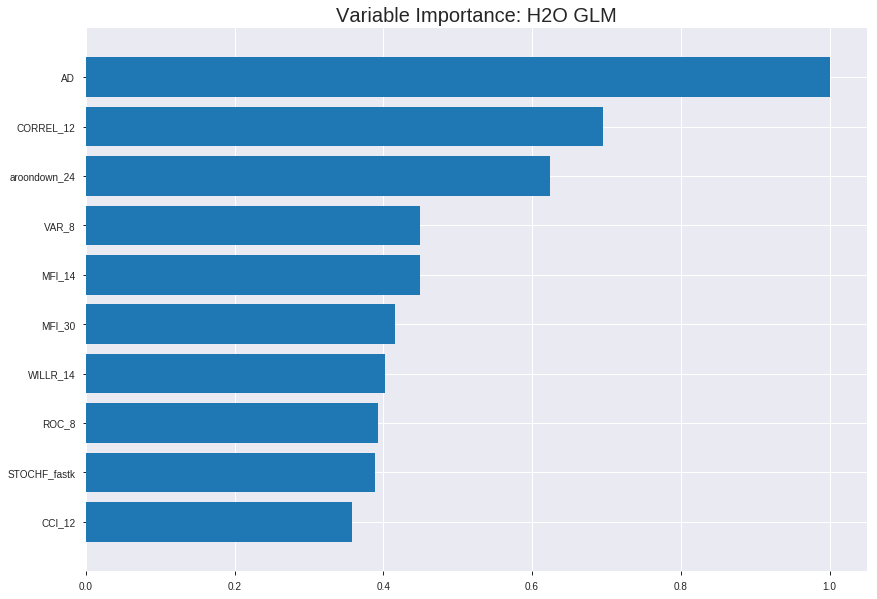

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_171950_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24478713123283552
RMSE: 0.494759670176173
LogLoss: 0.6825949534619454
Null degrees of freedom: 1555
Residual degrees of freedom: 1493
Null deviance: 2155.940212106897
Residual deviance: 2124.2354951735742
AIC: 2250.2354951735742
AUC: 0.5810061453964087
pr_auc: 0.5971192930320112
Gini: 0.16201229079281743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4404656424412801: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      43   714   0.9432   (714.0/757.0)
1      17   782   0.0213   (17.0/799.0)
Total  60   1496  0.4698   (731.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440466     0.681481  365
max f2                       0.407453     0.84124   390
max f0point5                 0.491913     0.580145  256
max accuracy                 0.516161     0.560411  199
max precision                0.674178     1         0
max recall                   0.390802     1         396
max specificity              0.674178     1         0
max absolute_mcc             0.555515     0.135873  113
max min_per_class_accuracy   0.511474     0.546934  210
max mean_per_class_accuracy  0.522128     0.562486  183

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.621286           1.82572   1.82572            0.9375           0.642244  0.9375                      0.642244            0.0187735       0.0187735                  82.572    82.572
    2        0.0205656                   0.613487           1.21715   1.52143            0.625            0.617168  0.78125                     0.629706            0.0125156       0.0312891                  21.7146   52.1433
    3        0.0302057                   0.60673            1.42812   1.49165            0.733333         0.610165  0.765957                    0.623469            0.0137672       0.0450563                  42.8118   49.1652
    4        0.0404884                   0.601745           1.21715   1.42194            0.625            0.604233  0.730159                    0.618584            0.0125156       0.057572                   21.7146   42.1936
    5        0.0501285                   0.598676           0.778974  1.29829            0.4              0.600224  0.666667                    0.615053            0.00750939      0.0650814                  -22.1026  29.829
    6        0.100257                    0.579615           1.34822   1.32326            0.692308         0.587787  0.679487                    0.60142             0.0675845       0.132666                   34.8224   32.3257
    7        0.150386                    0.565612           1.22339   1.28997            0.628205         0.571872  0.662393                    0.591571            0.0613267       0.193992                   22.3388   28.9967
    8        0.200514                    0.554567           1.12352   1.24836            0.576923         0.559569  0.641026                    0.58357             0.0563204       0.250313                   12.352    24.8355
    9        0.300129                    0.53757            1.04282   1.18014            0.535484         0.545371  0.605996                    0.570892            0.10388         0.354193                   4.28197   18.0137
    10       0.400386                    0.522054           1.0611    1.15033            0.544872         0.529718  0.59069                     0.560582            0.106383        0.460576                   6.1102    15.033
    11       0.5                         0.511274           0.866922  1.09387            0.445161         0.51647   0.561697                    0.551793            0.0863579       0.546934                   -13.3078  9.38673
    12       0.600257                    0.498338           1.08607   1.09256            0.557692         0.504381  0.561028                    0.543875            0.108886        0.65582                    8.60691   9.25648
    13       0.699871                    0.48512            0.791538  1.04972            0.406452         0.49163   0.539027                    0.536438            0.0788486       0.734668                   -20.8462  4.97189
    14       0.800129                    0.471524           0.986201  1.04176            0.50641          0.478808  0.53494                     0.529217            0.0988736       0.833542                   -1.37993  4.176
    15       0.899743                    0.455186           0.879486  1.02379            0.451613         0.463628  0.525714                    0.521956            0.0876095       0.921151                   -12.0514  2.3794
    16       1                           0.316696           0.786464  1                  0.403846         0.437578  0.513496                    0.513496            0.0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24925923969967606
RMSE: 0.4992586901593963
LogLoss: 0.6916527830090571
Null degrees of freedom: 443
Residual degrees of freedom: 381
Null deviance: 615.9463007458467
Residual deviance: 614.1876713120428
AIC: 740.1876713120428
AUC: 0.5240448024673823
pr_auc: 0.5293216025669562
Gini: 0.04808960493476455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4512403733430033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   204  0.9148   (204.0/223.0)
1      8    213  0.0362   (8.0/221.0)
Total  27   417  0.4775   (212.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45124      0.667712  374
max f2                       0.418733     0.832078  399
max f0point5                 0.460548     0.565428  366
max accuracy                 0.509286     0.542793  180
max precision                0.609905     1         0
max recall                   0.418733     1         399
max specificity              0.609905     1         0
max absolute_mcc             0.460548     0.107338  366
max min_per_class_accuracy   0.504411     0.520362  203
max mean_per_class_accuracy  0.509286     0.54251   180

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 50.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.580468           1.20543   1.20543            0.6              0.591889  0.6                         0.591889            0.0135747       0.0135747                  20.543    20.543
    2        0.0202703                   0.574509           1.50679   1.33937            0.75             0.576155  0.666667                    0.584896            0.0135747       0.0271493                  50.6787   33.9367
    3        0.0315315                   0.567531           1.20543   1.29153            0.6              0.571524  0.642857                    0.580121            0.0135747       0.040724                   20.543    29.1532
    4        0.0405405                   0.564553           1.50679   1.33937            0.75             0.565698  0.666667                    0.576915            0.0135747       0.0542986                  50.6787   33.9367
    5        0.0518018                   0.562112           0         1.0482             0                0.563778  0.521739                    0.574059            0               0.0542986                  -100      4.81999
    6        0.101351                    0.550733           1.18717   1.11614            0.590909         0.555426  0.555556                    0.56495             0.0588235       0.113122                   18.7166   11.6139
    7        0.150901                    0.54361            1.27849   1.16945            0.636364         0.546734  0.58209                     0.558969            0.0633484       0.176471                   27.8486   16.9447
    8        0.20045                     0.53384            1.00452   1.12868            0.5              0.538114  0.561798                    0.553813            0.0497738       0.226244                   0.452489  12.868
    9        0.29955                     0.521772           0.958865  1.0725             0.477273         0.527461  0.533835                    0.545095            0.0950226       0.321267                   -4.11353  7.25003
    10       0.400901                    0.51178            1.02685   1.06096            0.511111         0.516469  0.52809                     0.537858            0.104072        0.425339                   2.68477   6.09589
    11       0.5                         0.503703           0.958865  1.04072            0.477273         0.508161  0.518018                    0.531972            0.0950226       0.520362                   -4.11353  4.0724
    12       0.599099                    0.494067           0.821884  1.00452            0.409091         0.499172  0.5                         0.526547            0.081448        0.60181                    -17.8116  0.452489
    13       0.70045                     0.485035           0.80362   0.975455           0.4              0.490156  0.485531                    0.521281            0.081448        0.683258                   -19.638   -2.4545
    14       0.79955                     0.476884           1.14151   0.996036           0.568182         0.481615  0.495775                    0.516365            0.113122        0.79638                    14.1506   -0.396406
    15       0.898649                    0.465161           1.27849   1.02718            0.636364         0.471644  0.511278                    0.511433            0.126697        0.923077                   27.8486   2.71833
    16       1                           0.418733           0.758974  1                  0.377778         0.448496  0.497748                    0.505054         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:19:51  0.000 sec   2            3.9       63            1.38315           1.38666
    2019-08-27 17:19:51  0.024 sec   4            2.4       63            1.38202           1.38639
    2019-08-27 17:19:51  0.042 sec   6            1.5       63            1.38051           1.38602
    2019-08-27 17:19:51  0.077 sec   8            0.93      63            1.37861           1.38554
    2019-08-27 17:19:51  0.108 sec   10           0.58      63            1.37634           1.38498
    2019-08-27 17:19:51  0.126 sec   12           0.36      63            1.37376           1.38438
    2019-08-27 17:19:51  0.151 sec   14           0.22      63            1.37097           1.38383
    2019-08-27 17:19:51  0.185 sec   16           0.14      63            1.36809           1.38343
    2019-08-27 17:19:51  0.210 sec   18           0.086     63            1.36519           1.38331
    2019-08-27 17:19:51  0.236 sec   20           0.053     63            1.36234           1.38348
    2019-08-27 17:19:51  0.258 sec   22           0.033     63            1.35953           1.38422
    2019-08-27 17:19:51  0.285 sec   24           0.021     63            1.35688           1.38558
    2019-08-27 17:19:51  0.313 sec   26           0.013     63            1.35447           1.38758
    2019-08-27 17:19:51  0.330 sec   28           0.0079    63            1.35242           1.39005

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6732026143790849)

('auc', 0.5654991948470209)

('logloss', 0.7087594250579973)

('mean_per_class_error', 0.41855877616747184)

('rmse', 0.5071308678298428)

('mse', 0.2571817171058495)

glm prediction progress: |████████████████████████████████████████████████| 100%


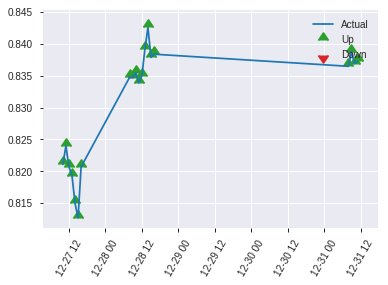


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2571817171058495
RMSE: 0.5071308678298428
LogLoss: 0.7087594250579973
Null degrees of freedom: 222
Residual degrees of freedom: 160
Null deviance: 309.68415973716924
Residual deviance: 316.1067035758668
AIC: 442.1067035758668
AUC: 0.5654991948470209
pr_auc: 0.5052275989391697
Gini: 0.13099838969404187
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5057895815362076: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   95   0.8261   (95.0/115.0)
1      5    103  0.0463   (5.0/108.0)
Total  25   198  0.4484   (100.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50579      0.673203  196
max f2                       0.491396     0.835913  212
max f0point5                 0.52123      0.579268  176
max accuracy                 0.566197     0.578475  130
max precision                0.72569      1         0
max recall                   0.491396     1         212
max specificity              0.72569      1         0
max absolute_mcc             0.50579      0.202146  196
max min_per_class_accuracy   0.590278     0.537037  109
max mean_per_class_accuracy  0.566197     0.581441  130

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 58.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.712937           0.688272  0.688272           0.333333         0.719271  0.333333                    0.719271            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.711315           1.03241   0.825926           0.5              0.711759  0.4                         0.716266            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.705003           1.03241   0.884921           0.5              0.710937  0.428571                    0.714744            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.695154           1.03241   0.917695           0.5              0.701228  0.444444                    0.71174             0.00925926      0.037037                   3.24074   -8.23045
    5        0.0538117                   0.692254           1.37654   1.03241            0.666667         0.693072  0.5                         0.707073            0.0185185       0.0555556                  37.6543   3.24074
    6        0.103139                    0.675178           0.563131  0.807971           0.272727         0.684808  0.391304                    0.696424            0.0277778       0.0833333                  -43.6869  -19.2029
    7        0.152466                    0.661903           1.12626   0.910948           0.545455         0.668515  0.441176                    0.687395            0.0555556       0.138889                   12.6263   -8.90523
    8        0.201794                    0.646975           1.50168   1.05535            0.727273         0.652297  0.511111                    0.678815            0.0740741       0.212963                   50.1684   5.53498
    9        0.300448                    0.623134           1.22012   1.10945            0.590909         0.634297  0.537313                    0.664197            0.12037         0.333333                   22.0118   10.9453
    10       0.399103                    0.608196           0.656987  0.997607           0.318182         0.616465  0.483146                    0.652398            0.0648148       0.398148                   -34.3013  -0.239284
    11       0.502242                    0.587861           1.34662   1.06928            0.652174         0.597907  0.517857                    0.641208            0.138889        0.537037                   34.6618   6.92791
    12       0.600897                    0.564554           1.40783   1.12486            0.681818         0.575038  0.544776                    0.630344            0.138889        0.675926                   40.7828   12.4862
    13       0.699552                    0.538105           0.938552  1.09859            0.454545         0.551184  0.532051                    0.619181            0.0925926       0.768519                   -6.14478  9.85874
    14       0.798206                    0.520682           1.12626   1.10201            0.545455         0.530019  0.533708                    0.608161            0.111111        0.87963                    12.6263   10.2008
    15       0.896861                    0.504526           0.750842  1.06338            0.363636         0.51152   0.515                       0.59753             0.0740741       0.953704                   -24.9158  6.33796
    16       1                           0.444457           0.448873  1                  0.217391         0.488484  0.484305                    0.586283 

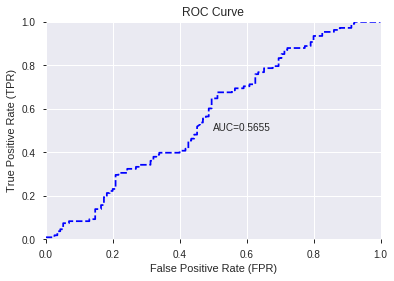

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


'log_likelihood'
--2019-08-27 17:19:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_171950_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_171950_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['AD',
 'CORREL_12',
 'aroondown_24',
 'VAR_8',
 'MFI_14',
 'MFI_30',
 'WILLR_14',
 'ROC_8',
 'STOCHF_fastk',
 'CCI_12',
 'HT_PHASOR_inphase',
 'BOP',
 'MFI_24',
 'aroondown_20',
 'ADX_12',
 'BETA_12',
 'MINUS_DM_12',
 'MINUS_DM_30',
 'PLUS_DI_24',
 'ROC_14',
 'ROCR_14',
 'BETA_8',
 'MINUS_DM_14',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_24',
 'ROCR100_12',
 'MACDFIX_hist_20',
 'MOM_24',
 'MACDEXT',
 'ATR_20',
 'ROCR100_30',
 'ROCP_30',
 'MOM_20',
 'ADOSC',
 'ATR_12',
 'ULTOSC',
 'STOCH_slowk',
 'STOCHF_fastd',
 'HT_PHASOR_quadrature',
 'CMO_14',
 'RSI_14',
 'DX_30',
 'STDDEV_8',
 'MOM_12',
 'WILLR_24',
 'LINEARREG_ANGLE_8',
 'ROCR_24',
 'LINEARREG_SLOPE_8',
 'ROCP_24',
 'ADX_20',
 'BBANDS_upperband_20_1_3',
 'MINUS_DI_8',
 'AROONOSC_14',
 'BBANDS_lowerband_24_7_4',
 'aroondown_8',
 'ATR_30',
 'LINEARREG_8',
 'BBANDS_middleband_20_1_3',
 'ADX_8',
 'MOM_30',
 'LINEARREG_INTERCEPT_8',
 'PLUS_DM_20']

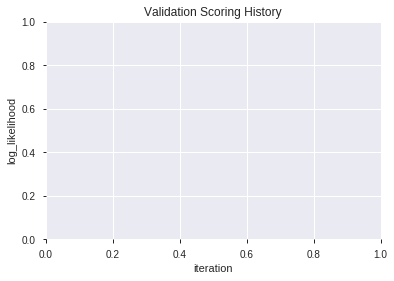

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_172007  0.559662  0.691209              0.491304  0.498989  0.248990
1  XGBoost_grid_1_AutoML_20190827_172007_model_6  0.554670  0.694458              0.452738  0.500515  0.250516
2  XGBoost_grid_1_AutoML_20190827_172007_model_4  0.536715  0.698579              0.500000  0.502590  0.252597
3  XGBoost_grid_1_AutoML_20190827_172007_model_2  0.534461  0.698329              0.471256  0.502460  0.252466
4  XGBoost_grid_1_AutoML_20190827_172007_model_5  0.529630  0.724551              0.491304  0.513597  0.263782
5               XGBoost_3_AutoML_20190827_172007  0.518035  0.707916              0.457367  0.506882  0.256929
6  XGBoost_grid_1_AutoML_20190827_172007_model_1  0.503462  0.709209              0.491304  0.507623  0.257682
7  XGBoost_grid_1_AutoML_20190827_172007_model_3  0.498390  0.720406              0.465499  0.512381  0.262534
8               XGBoost_1_AutoML_20190827_172007  0.497021  0.717072              0.478824  0.511045  0.261167
9  XGBoost_grid_1_AutoML_20190827_172007_model_7  0.478663  0.728008              0.460870  0.515856  0.266107

variable  relative_importance  scaled_importance  percentage
0                     AD           231.054504           1.000000    0.048988
1      HT_PHASOR_inphase           168.867691           0.730857    0.035803
2                    BOP           164.792068           0.713217    0.034939
3              CORREL_12           164.495102           0.711932    0.034876
4   HT_PHASOR_quadrature           137.474045           0.594985    0.029147
..                   ...                  ...                ...         ...
57            ROCR100_30            25.941950           0.112276    0.005500
58           AROONOSC_14            25.369978           0.109801    0.005379
59               ROCR_24            24.256304           0.104981    0.005143
60                 VAR_8            18.418663           0.079716    0.003905
61                RSI_14            13.210594           0.057175    0.002801

[62 rows x 4 columns]

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_172007


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18422875128633645
RMSE: 0.42921876856253205
LogLoss: 0.5580278163842408
Mean Per-Class Error: 0.1545632502980112
AUC: 0.9242762171340332
pr_auc: 0.9270763187435561
Gini: 0.8485524342680664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5022936122758048: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  143  0.1889   (143.0/757.0)
1      98   701  0.1227   (98.0/799.0)
Total  712  844  0.1549   (241.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502294     0.853317  206
max f2                       0.433099     0.903877  274
max f0point5                 0.533391     0.866261  175
max accuracy                 0.502906     0.845758  205
max precision                0.777368     1         0
max recall                   0.347328     1         348
max specificity              0.777368     1         0
max absolute_mcc             0.502906     0.691713  205
max min_per_class_accuracy   0.512169     0.843554  196
max mean_per_class_accuracy  0.51747      0.845437  191

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.714184           1.94743    1.94743            1                0.734674  1                           0.734674            0.020025        0.020025                   94.7434   94.7434
    2        0.0205656                   0.698415           1.94743    1.94743            1                0.705492  1                           0.720083            0.020025        0.0400501                  94.7434   94.7434
    3        0.0302057                   0.688624           1.94743    1.94743            1                0.694756  1                           0.712               0.0187735       0.0588235                  94.7434   94.7434
    4        0.0404884                   0.68095            1.94743    1.94743            1                0.684472  1                           0.705008            0.020025        0.0788486                  94.7434   94.7434
    5        0.0501285                   0.675761           1.94743    1.94743            1                0.677963  1                           0.699807            0.0187735       0.097622                   94.7434   94.7434
    6        0.100257                    0.650588           1.8975     1.92247            0.974359         0.663957  0.987179                    0.681882            0.0951189       0.192741                   89.75     92.2467
    7        0.150386                    0.630295           1.92247    1.92247            0.987179         0.639592  0.987179                    0.667785            0.0963705       0.289111                   92.2467   92.2467
    8        0.200514                    0.614434           1.87253    1.90998            0.961538         0.622217  0.980769                    0.656393            0.0938673       0.382979                   87.2533   90.9984
    9        0.300129                    0.579683           1.75897    1.85986            0.903226         0.595893  0.955032                    0.636313            0.175219        0.558198                   75.8973   85.9862
    10       0.400386                    0.548459           1.54796    1.78176            0.794872         0.563717  0.914928                    0.618135            0.155194        0.713392                   54.7961   78.1762
    11       0.5                         0.515543           1.23128    1.67209            0.632258         0.533255  0.858612                    0.601224            0.122653        0.836045                   23.1281   67.209
    12       0.600257                    0.484022           0.823915   1.53042            0.423077         0.498698  0.785867                    0.5841              0.0826033       0.918648                   -17.6085  53.0425
    13       0.699871                    0.447827           0.452307   1.37697            0.232258         0.465837  0.707071                    0.567267            0.0450563       0.963705                   -54.7693  37.6974
    14       0.800129                    0.410572           0.274638   1.23885            0.141026         0.43087   0.636145                    0.550177            0.0275344       0.991239                   -72.5362  23.885
    15       0.899743                    0.364103           0.0628205  1.10865            0.0322581        0.389089  0.569286                    0.532342            0.00625782      0.997497                   -93.718   10.8647
    16       1                           0.221982           0.0249671  1                  0.0128205        0.323753  0.513496                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.255117098342927
RMSE: 0.5050911782469845
LogLoss: 0.7036936585013541
Mean Per-Class Error: 0.47642188990118295
AUC: 0.5062597650305379
pr_auc: 0.5150734238002316
Gini: 0.012519530061075868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34448760747909546: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    218  0.9776   (218.0/223.0)
1      2    219  0.009    (2.0/221.0)
Total  7    437  0.4955   (220.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.344488     0.665653   392
max f2                       0.277778     0.832078   399
max f0point5                 0.408514     0.560872   372
max accuracy                 0.590475     0.524775   94
max precision                0.765674     1          0
max recall                   0.277778     1          399
max specificity              0.765674     1          0
max absolute_mcc             0.681696     0.0917612  9
max min_per_class_accuracy   0.532352     0.488688   198
max mean_per_class_accuracy  0.590475     0.523578   94

Gains/Lift Table: Avg response rate: 49.77 %, avg score: 53.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.694201           1.60724   1.60724            0.8              0.728317  0.8                         0.728317            0.0180995       0.0180995                  60.724    60.724
    2        0.0202703                   0.681709           1.50679   1.56259            0.75             0.683673  0.777778                    0.708475            0.0135747       0.0316742                  50.6787   56.2594
    3        0.0315315                   0.664023           0.80362   1.29153            0.4              0.67583   0.642857                    0.696816            0.00904977      0.040724                   -19.638   29.1532
    4        0.0405405                   0.662006           1.00452   1.22775            0.5              0.663015  0.611111                    0.689304            0.00904977      0.0497738                  0.452489  22.7753
    5        0.0518018                   0.655267           1.20543   1.2229             0.6              0.659441  0.608696                    0.682812            0.0135747       0.0633484                  20.543    22.29
    6        0.101351                    0.630673           0.913204  1.07149            0.454545         0.641027  0.533333                    0.662384            0.0452489       0.108597                   -8.67956  7.14932
    7        0.150901                    0.615372           1.18717   1.10948            0.590909         0.623531  0.552239                    0.649626            0.0588235       0.167421                   18.7166   10.9475
    8        0.20045                     0.598098           1.00452   1.08353            0.5              0.606718  0.539326                    0.63902             0.0497738       0.217195                   0.452489  8.35325
    9        0.29955                     0.570337           0.821884  0.996972           0.409091         0.584949  0.496241                    0.621132            0.081448        0.298643                   -17.8116  -0.302793
    10       0.400901                    0.551332           0.937557  0.981951           0.466667         0.561168  0.488764                    0.605972            0.0950226       0.393665                   -6.24434  -1.80487
    11       0.5                         0.532219           0.958865  0.977376           0.477273         0.542958  0.486486                    0.593483            0.0950226       0.488688                   -4.11353  -2.26244
    12       0.599099                    0.512268           1.09585   0.996972           0.545455         0.522768  0.496241                    0.581786            0.108597        0.597285                   9.58453   -0.302793
    13       0.70045                     0.493046           1.02685   1.00129            0.511111         0.503153  0.498392                    0.570408            0.104072        0.701357                   2.68477   0.12949
    14       0.79955                     0.471869           1.09585   1.01301            0.545455         0.482502  0.504225                    0.559513            0.108597        0.809955                   9.58453   1.30138
    15       0.898649                    0.436496           1.00452   1.01208            0.5              0.454382  0.503759                    0.547919            0.0995475       0.909502                   0.452489  1.20777
    16       1                           0.277778           0.892911  1                  0.444444         0.385688  0.497748                    0.531477      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:20:10  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.486504                         0.5                0.693147              0.5               0                    1                  0.502252
    2019-08-27 17:20:10  0.058 sec   5                  0.491535         0.676332            0.725225        0.717828           1.83288          0.357969                         0.498589           0.690323              0.543707          0.538324             1.20543            0.457207
    2019-08-27 17:20:10  0.105 sec   10                 0.482911         0.659417            0.787142        0.78038            1.94743          0.303985                         0.499299           0.691735              0.522148          0.527518             1.20543            0.488739
    2019-08-27 17:20:10  0.159 sec   15                 0.474944         0.643968            0.828329        0.824773           1.94743          0.250643                         0.500032           0.693215              0.521214          0.535426             1.60724            0.502252
    2019-08-27 17:20:10  0.215 sec   20                 0.46733          0.629331            0.851649        0.854206           1.94743          0.248715                         0.500448           0.694055              0.522716          0.535601             1.20543            0.502252
    2019-08-27 17:20:10  0.272 sec   25                 0.45956          0.614504            0.869191        0.873061           1.94743          0.225578                         0.500864           0.694902              0.518556          0.518818             1.60724            0.502252
    2019-08-27 17:20:10  0.335 sec   30                 0.453082         0.602254            0.882548        0.886934           1.94743          0.201157                         0.501917           0.696994              0.508583          0.520318             1.60724            0.5
    2019-08-27 17:20:10  0.391 sec   35                 0.446789         0.590507            0.900257        0.9031             1.94743          0.181234                         0.502395           0.69799               0.508634          0.516986             1.20543            0.5
    2019-08-27 17:20:10  0.451 sec   40                 0.441054         0.579875            0.909872        0.914086           1.94743          0.166452                         0.503189           0.699687              0.51048           0.514091             1.20543            0.502252
    2019-08-27 17:20:10  0.510 sec   45                 0.435251         0.569119            0.917565        0.920556           1.94743          0.155527                         0.504137           0.701713              0.510267          0.509798             1.20543            0.481982
    2019-08-27 17:20:10  0.584 sec   50                 0.429219         0.558028            0.924276        0.927076           1.94743          0.154884                         0.505091           0.703694              0.50626           0.515073             1.60724            0.495495

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
AD                    231.05450439453125     1.0                   0.04898840548045668
HT_PHASOR_inphase     168.86769104003906     0.7308565201208687    0.03580349555571666
BOP                   164.7920684814453      0.7132172943924037    0.03493937801336931
CORREL_12             164.49510192871094     0.7119320281583064    0.034876414869943015
HT_PHASOR_quadrature  137.4740447998047      0.5949853484140019    0.029147383503035914
---                   ---                    ---                   ---
ROCR100_30            25.94194984436035      0.11227632160792604   0.005500237968783241
AROONOSC_14           25.369977951049805     0.1098008368957393    0.005378967919941966
ROCR_24               24.256303787231445     0.10498087388858349   0.005142845617746615
VAR_8                 18.418663024902344     0.0797156630777127    0.0039051432259944595
RSI_14                13.210594177246094     0.057175228900487825  0.002800923296815023


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6565349544072948)

('auc', 0.5596618357487922)

('logloss', 0.6912094070479441)

('mean_per_class_error', 0.42600644122383247)

('rmse', 0.4989887261245408)

('mse', 0.248989748799392)

xgboost prediction progress: |████████████████████████████████████████████| 100%


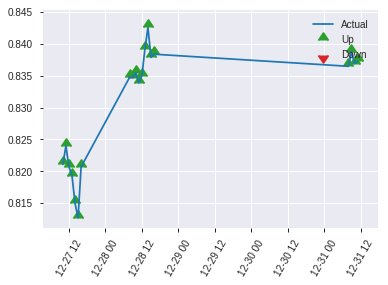


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.248989748799392
RMSE: 0.4989887261245408
LogLoss: 0.6912094070479441
Mean Per-Class Error: 0.42600644122383247
AUC: 0.5596618357487922
pr_auc: 0.5311500487915932
Gini: 0.1193236714975845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32248491048812866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    108  0        (0.0/108.0)
Total  2    221  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322485     0.656535  220
max f2                       0.322485     0.826953  220
max f0point5                 0.470771     0.564516  158
max accuracy                 0.515628     0.573991  108
max precision                0.652451     0.714286  6
max recall                   0.322485     1         220
max specificity              0.717094     0.991304  0
max absolute_mcc             0.514919     0.147916  110
max min_per_class_accuracy   0.514919     0.573913  110
max mean_per_class_accuracy  0.514919     0.573994  110

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.671088           1.37654   1.37654            0.666667         0.688812  0.666667                    0.688812            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.659043           1.03241   1.23889            0.5              0.662913  0.6                         0.678453            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.648425           2.06481   1.47487            1                0.653971  0.714286                    0.671458            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.642178           1.03241   1.37654            0.5              0.645761  0.666667                    0.665747            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.631436           1.37654   1.37654            0.666667         0.63698   0.666667                    0.658556            0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.617611           0.938552  1.16707            0.454545         0.623537  0.565217                    0.641807            0.0462963       0.12037                    -6.14478  16.7069
    7        0.152466                    0.597207           0.938552  1.09314            0.454545         0.608589  0.529412                    0.63106             0.0462963       0.166667                   -6.14478  9.31373
    8        0.201794                    0.580845           1.12626   1.10123            0.545455         0.588806  0.533333                    0.620732            0.0555556       0.222222                   12.6263   10.1235
    9        0.300448                    0.555074           1.03241   1.07863            0.5              0.565196  0.522388                    0.602496            0.101852        0.324074                   3.24074   7.86346
    10       0.399103                    0.538004           1.31397   1.13681            0.636364         0.547993  0.550562                    0.589023            0.12963         0.453704                   31.3973   13.6808
    11       0.502242                    0.514251           1.16707   1.14302            0.565217         0.524384  0.553571                    0.575749            0.12037         0.574074                   16.7069   14.3022
    12       0.600897                    0.496996           0.750842  1.07863            0.363636         0.504965  0.522388                    0.564128            0.0740741       0.648148                   -24.9158  7.86346
    13       0.699552                    0.472469           1.12626   1.08535            0.545455         0.484238  0.525641                    0.552861            0.111111        0.759259                   12.6263   8.53514
    14       0.798206                    0.449297           0.844697  1.05561            0.409091         0.461016  0.511236                    0.54151             0.0833333       0.842593                   -15.5303  5.56076
    15       0.896861                    0.414109           0.563131  1.00144            0.272727         0.436608  0.485                       0.52997             0.0555556       0.898148                   -43.6869  0.143519
    16       1                           0.241044           0.98752   1                  0.478261         0.370864  0.484305                    0.51356         

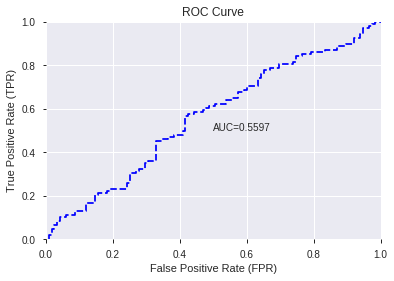

This function is available for GLM models only


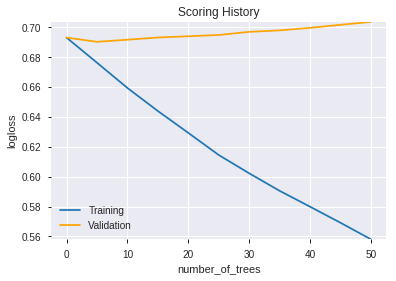

--2019-08-27 17:20:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_172007',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_172007',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a105',
   'ty

['AD',
 'HT_PHASOR_inphase',
 'BOP',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'ADX_12',
 'STDDEV_8',
 'BBANDS_upperband_20_1_3',
 'ADX_8',
 'MFI_14',
 'DX_30',
 'STOCHF_fastk',
 'STOCH_slowk',
 'ROCP_30',
 'MFI_30',
 'BETA_8',
 'ATR_30',
 'ADX_20',
 'CCI_12',
 'aroondown_24',
 'LINEARREG_ANGLE_8',
 'WILLR_14',
 'ROC_8',
 'ATR_20',
 'MFI_24',
 'LINEARREG_ANGLE_12',
 'MOM_30',
 'ULTOSC',
 'MACDEXT',
 'MINUS_DM_14',
 'PLUS_DI_24',
 'MOM_24',
 'BETA_12',
 'MINUS_DM_12',
 'ATR_12',
 'PLUS_DM_20',
 'WILLR_24',
 'MACDFIX_hist_24',
 'MOM_12',
 'ROC_14',
 'MINUS_DM_30',
 'BBANDS_lowerband_24_7_4',
 'MINUS_DI_8',
 'MACDFIX_hist_20',
 'ROCP_24',
 'LINEARREG_8',
 'MOM_20',
 'BBANDS_middleband_20_1_3',
 'STOCHF_fastd',
 'LINEARREG_SLOPE_8',
 'aroondown_20',
 'ADOSC',
 'ROCR_14',
 'LINEARREG_INTERCEPT_8',
 'CMO_14',
 'ROCR100_12',
 'aroondown_8',
 'ROCR100_30',
 'AROONOSC_14',
 'ROCR_24',
 'VAR_8',
 'RSI_14']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.587
GLM             0.601
XGBoost         0.601
dtype: float64

DeepLearning    GLM  XGBoost
All          0.561  0.601    0.601
DLF          0.587  0.565    0.587
Fwe          0.570  0.601    0.601
RFE          0.565  0.578    0.574
XGBF         0.583  0.565    0.587





F1


DeepLearning    0.669
GLM             0.673
XGBoost         0.661
dtype: float64

DeepLearning    GLM  XGBoost
All          0.655  0.662    0.661
DLF          0.663  0.657    0.661
Fwe          0.660  0.662    0.661
RFE          0.665  0.673    0.657
XGBF         0.669  0.657    0.661





auc


DeepLearning    0.581
GLM             0.578
XGBoost         0.588
dtype: float64

DeepLearning    GLM  XGBoost
All          0.539  0.578    0.588
DLF          0.581  0.564    0.587
Fwe          0.551  0.578    0.588
RFE          0.567  0.565    0.560
XGBF         0.570  0.564    0.587





logloss


DeepLearning    0.875
GLM             0.709
XGBoost         0.691
dtype: float64

DeepLearning    GLM  XGBoost
All          0.875  0.696    0.687
DLF          0.701  0.693    0.690
Fwe          0.824  0.696    0.687
RFE          0.697  0.709    0.691
XGBF         0.867  0.693    0.690





mean_per_class_error


DeepLearning    0.444
GLM             0.434
XGBoost         0.426
dtype: float64

DeepLearning    GLM  XGBoost
All          0.444  0.399    0.404
DLF          0.410  0.434    0.406
Fwe          0.424  0.399    0.404
RFE          0.433  0.419    0.426
XGBF         0.416  0.434    0.406





rmse


DeepLearning    0.566
GLM             0.507
XGBoost         0.499
dtype: float64

DeepLearning    GLM  XGBoost
All          0.566  0.501    0.497
DLF          0.504  0.500    0.498
Fwe          0.550  0.501    0.497
RFE          0.502  0.507    0.499
XGBF         0.551  0.500    0.498





mse


DeepLearning    0.321
GLM             0.257
XGBoost         0.249
dtype: float64

DeepLearning    GLM  XGBoost
All          0.321  0.251    0.247
DLF          0.254  0.250    0.248
Fwe          0.303  0.251    0.247
RFE          0.252  0.257    0.249
XGBF         0.304  0.250    0.248

{'F1':       DeepLearning    GLM  XGBoost
 All          0.655    NaN      NaN
 DLF          0.663    NaN      NaN
 DLF            NaN  0.657      NaN
 DLF            NaN    NaN    0.661
 All            NaN  0.662      NaN
 All            NaN    NaN    0.661
 XGBF         0.669    NaN      NaN
 XGBF           NaN  0.657      NaN
 XGBF           NaN    NaN    0.661
 Fwe          0.660    NaN      NaN
 Fwe            NaN  0.662      NaN
 Fwe            NaN    NaN    0.661
 RFE          0.665    NaN      NaN
 RFE            NaN  0.673      NaN
 RFE            NaN    NaN    0.657,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.561    NaN      NaN
 DLF          0.587    NaN      NaN
 DLF            NaN  0.565      NaN
 DLF            NaN    NaN    0.587
 All            NaN  0.601      NaN
 All            NaN    NaN    0.601
 XGBF         0.583    NaN      NaN
 XGBF           NaN  0.565      NaN
 XGBF           NaN    NaN    0.587
 Fwe          0.570    NaN      NaN
 Fwe     